In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer

In [3]:
application_data = pd.read_csv('input/home-credit-default-risk/application_train.csv')
application_data.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [4]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
application_data.shape

(307511, 122)

In [6]:
application_data.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

## Null values

In [7]:
missing_values = application_data.isnull().sum().sort_values(ascending=False)
missing_values

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
FLAG_DOCUMENT_15                 0
FLAG_DOCUMENT_16                 0
FLAG_DOCUMENT_17                 0
FLAG_DOCUMENT_18                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

In [8]:
missing_percentage = (missing_values / len(application_data)) * 100
missing_percentage

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
FLAG_DOCUMENT_15             0.000000
FLAG_DOCUMENT_16             0.000000
FLAG_DOCUMENT_17             0.000000
FLAG_DOCUMENT_18             0.000000
SK_ID_CURR                   0.000000
Length: 122, dtype: float64

In [9]:
missing_data =pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])

                          Missing Values  Percentage
COMMONAREA_MEDI                   214865   69.872297
COMMONAREA_AVG                    214865   69.872297
COMMONAREA_MODE                   214865   69.872297
NONLIVINGAPARTMENTS_AVG           213514   69.432963
NONLIVINGAPARTMENTS_MODE          213514   69.432963
...                                  ...         ...
EXT_SOURCE_2                         660    0.214626
AMT_GOODS_PRICE                      278    0.090403
AMT_ANNUITY                           12    0.003902
CNT_FAM_MEMBERS                        2    0.000650
DAYS_LAST_PHONE_CHANGE                 1    0.000325

[67 rows x 2 columns]


In [10]:
columns_to_keep=missing_percentage[missing_percentage<=58].index
application_data=application_data[columns_to_keep]
application_data.shape

(307511, 99)

In [11]:
columns_to_impute_20 = missing_percentage[missing_percentage <= 20].index
for column in columns_to_impute_20:
    if application_data[column].dtype in ['int64', 'float64']:  
        median_value = application_data[column].median()
        application_data.loc[:, column] = application_data[column].fillna(median_value) 
    else:  
        mode_value = application_data[column].mode()[0] 
        application_data.loc[:, column] = application_data[column].fillna(mode_value)  
print(application_data[columns_to_impute_20].isnull().sum())


EXT_SOURCE_3                  0
AMT_REQ_CREDIT_BUREAU_YEAR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_MON     0
                             ..
FLAG_DOCUMENT_15              0
FLAG_DOCUMENT_16              0
FLAG_DOCUMENT_17              0
FLAG_DOCUMENT_18              0
SK_ID_CURR                    0
Length: 72, dtype: int64


In [12]:
from sklearn.impute import IterativeImputer, SimpleImputer
columns_to_impute_20_58 = missing_percentage[(missing_percentage > 20) & (missing_percentage <= 58)].index
numerical_cols_20_58 = application_data[columns_to_impute_20_58].select_dtypes(include=['int64', 'float64']).columns
categorical_cols_20_58 = application_data[columns_to_impute_20_58].select_dtypes(include=['object', 'category']).columns
iterative_imputer = IterativeImputer(max_iter=100, random_state=0, n_nearest_features=10, imputation_order='ascending')
application_data.loc[:, numerical_cols_20_58] = iterative_imputer.fit_transform(application_data[numerical_cols_20_58])
mode_imputer = SimpleImputer(strategy="most_frequent")
application_data.loc[:, categorical_cols_20_58] = mode_imputer.fit_transform(application_data[categorical_cols_20_58])
print(application_data[columns_to_impute_20_58].isnull().sum())

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


EXT_SOURCE_1                    0
NONLIVINGAREA_MODE              0
NONLIVINGAREA_AVG               0
NONLIVINGAREA_MEDI              0
ELEVATORS_MODE                  0
ELEVATORS_AVG                   0
ELEVATORS_MEDI                  0
WALLSMATERIAL_MODE              0
APARTMENTS_AVG                  0
APARTMENTS_MODE                 0
APARTMENTS_MEDI                 0
ENTRANCES_AVG                   0
ENTRANCES_MODE                  0
ENTRANCES_MEDI                  0
LIVINGAREA_AVG                  0
LIVINGAREA_MODE                 0
LIVINGAREA_MEDI                 0
HOUSETYPE_MODE                  0
FLOORSMAX_MODE                  0
FLOORSMAX_MEDI                  0
FLOORSMAX_AVG                   0
YEARS_BEGINEXPLUATATION_AVG     0
YEARS_BEGINEXPLUATATION_MEDI    0
YEARS_BEGINEXPLUATATION_MODE    0
TOTALAREA_MODE                  0
EMERGENCYSTATE_MODE             0
OCCUPATION_TYPE                 0
dtype: int64


In [13]:
print("Total missing values after imputing:", application_data.isnull().sum().sum())
application_data.shape

Total missing values after imputing: 0


(307511, 99)

### Dropping any column which has 80% of values with the same value 

In [14]:
application_data = application_data.drop(columns=['TARGET'])
def check_and_drop_repeated_columns(data, threshold=0.8):
    repeated_columns = []  
    for column in data.columns:
        most_common_value_count = data[column].value_counts(normalize=True).max()
        if most_common_value_count > threshold:
            repeated_columns.append(column) 
    data = data.drop(columns=repeated_columns)
    return data
application_data = check_and_drop_repeated_columns(application_data)
print(f"Shape of application_data: {application_data.shape}")

Shape of application_data: (307511, 57)


In [15]:
original_data = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_data['TARGET'] = original_data['TARGET']
print(f"Shape of train_data after adding TARGET: {application_data.shape}")

Shape of train_data after adding TARGET: (307511, 58)


In [16]:
print(application_data.columns.tolist())  
print('-------------------------------------------')
print('shape = ',application_data.shape[1])  

['EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'WALLSMATERIAL_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE', 'OCCUPATION_TYPE', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AMT_CREDIT', 'FLAG_OWN_REALTY', 'CODE_GENDER', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'DAYS_BIRTH', 'WEEKDAY_APPR_PROCESS_START', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_EMP

## Outlires

In [17]:
numeric_columns = application_data.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    Q1 = application_data[column].quantile(0.25)
    Q3 = application_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_condition = (application_data[column] < lower_bound) | (application_data[column] > upper_bound)
    num_outliers = outliers_condition.sum()
    if num_outliers > 0:
        print(f"Column '{column}' has {num_outliers} outliers.")

Column 'EXT_SOURCE_1' has 101304 outliers.
Column 'NONLIVINGAREA_MODE' has 18877 outliers.
Column 'NONLIVINGAREA_AVG' has 19746 outliers.
Column 'NONLIVINGAREA_MEDI' has 19627 outliers.
Column 'ELEVATORS_MODE' has 22754 outliers.
Column 'ELEVATORS_AVG' has 24560 outliers.
Column 'ELEVATORS_MEDI' has 24520 outliers.
Column 'APARTMENTS_AVG' has 57899 outliers.
Column 'APARTMENTS_MODE' has 66078 outliers.
Column 'APARTMENTS_MEDI' has 59854 outliers.
Column 'ENTRANCES_AVG' has 120858 outliers.
Column 'ENTRANCES_MODE' has 122444 outliers.
Column 'ENTRANCES_MEDI' has 121477 outliers.
Column 'LIVINGAREA_AVG' has 50185 outliers.
Column 'LIVINGAREA_MODE' has 52852 outliers.
Column 'LIVINGAREA_MEDI' has 50150 outliers.
Column 'FLOORSMAX_MODE' has 79763 outliers.
Column 'FLOORSMAX_MEDI' has 72553 outliers.
Column 'FLOORSMAX_AVG' has 71881 outliers.
Column 'YEARS_BEGINEXPLUATATION_AVG' has 35956 outliers.
Column 'YEARS_BEGINEXPLUATATION_MEDI' has 35973 outliers.
Column 'YEARS_BEGINEXPLUATATION_MOD

In [18]:
application_data['AGE_YEARS'] = abs(application_data['DAYS_BIRTH']) / 365
application_data = application_data.drop(columns=['DAYS_BIRTH'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


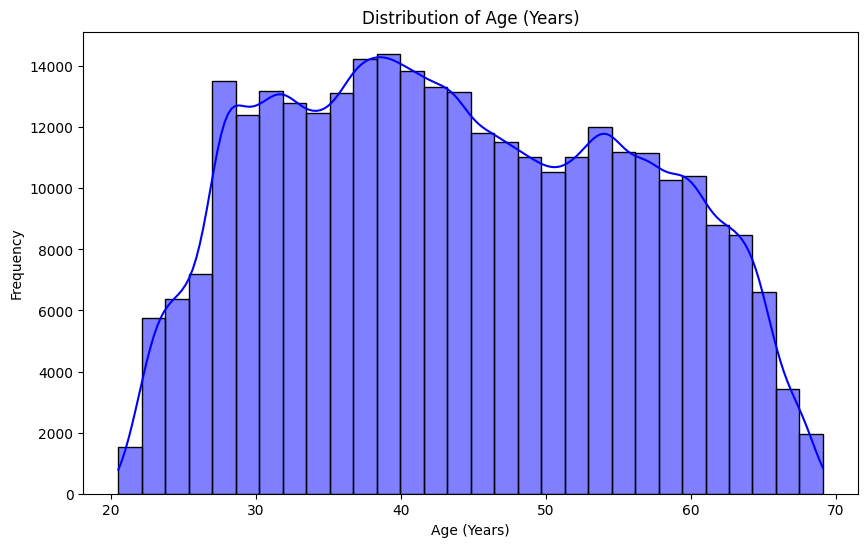

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(application_data['AGE_YEARS'], bins=30, kde=True, color='blue')
plt.title("Distribution of Age (Years)")
plt.xlabel("Age (Years)")
plt.ylabel("Frequency")
plt.show()

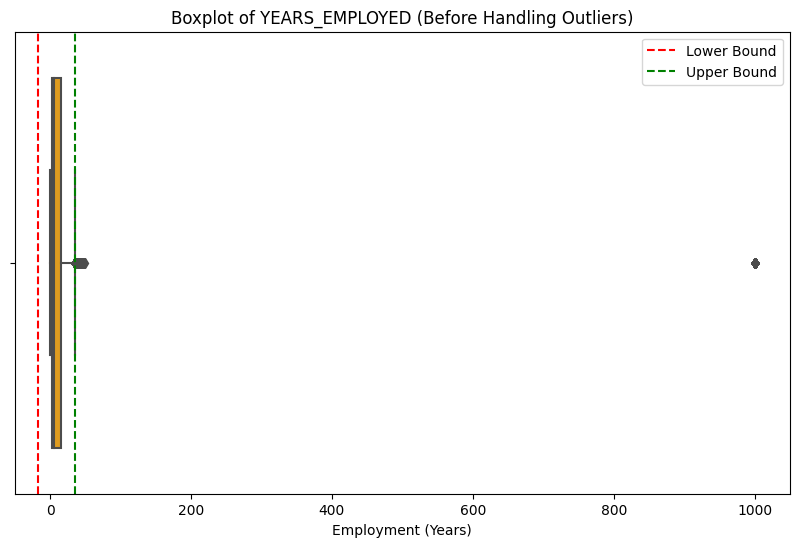

Number of outliers after handling: 0


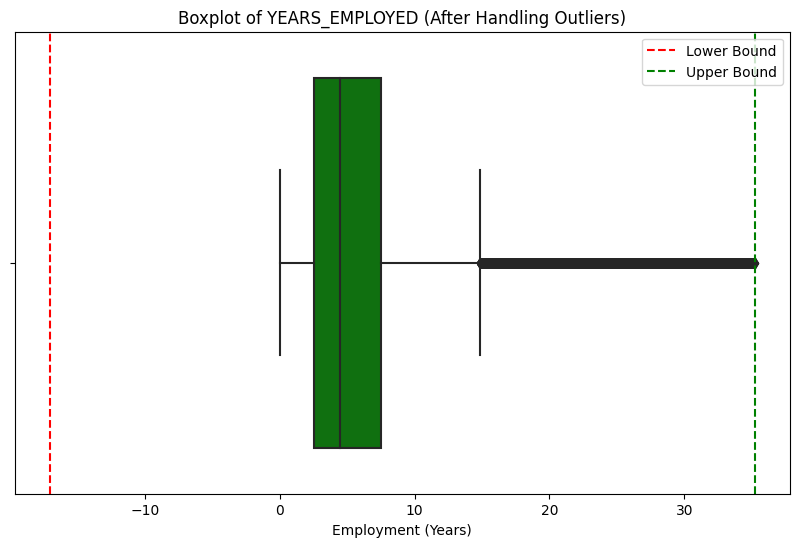

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


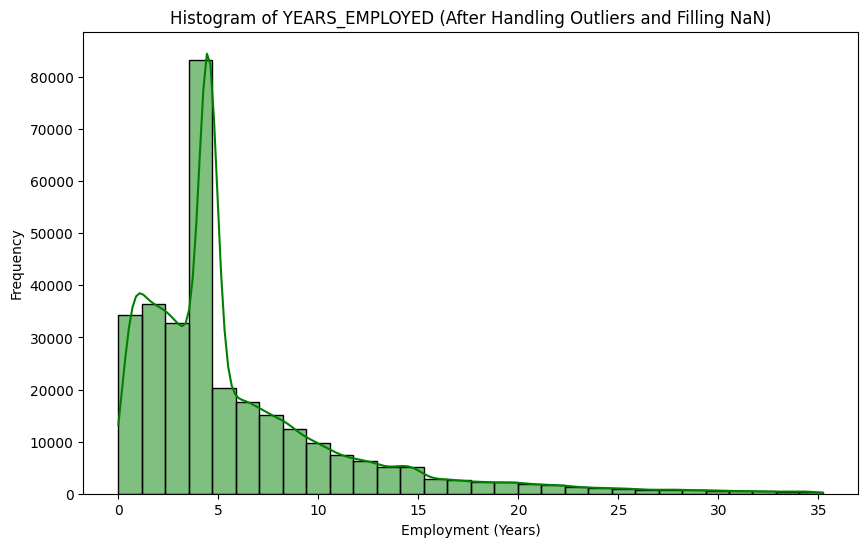

In [20]:
application_data['YEARS_EMPLOYED'] = abs(application_data['DAYS_EMPLOYED']) / 365.25
Q1 = application_data['YEARS_EMPLOYED'].quantile(0.25)
Q3 = application_data['YEARS_EMPLOYED'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
sns.boxplot(x=application_data['YEARS_EMPLOYED'], color='orange')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.title("Boxplot of YEARS_EMPLOYED (Before Handling Outliers)")
plt.xlabel("Employment (Years)")
plt.legend()
plt.show()

outliers_condition = (application_data['YEARS_EMPLOYED'] < lower_bound) | (application_data['YEARS_EMPLOYED'] > upper_bound)
application_data.loc[outliers_condition, 'YEARS_EMPLOYED'] = np.nan

median_years_employed = application_data['YEARS_EMPLOYED'].median()
application_data['YEARS_EMPLOYED'].fillna(median_years_employed, inplace=True)

remaining_outliers_condition = (application_data['YEARS_EMPLOYED'] < lower_bound) | (application_data['YEARS_EMPLOYED'] > upper_bound)
num_remaining_outliers = remaining_outliers_condition.sum()

print(f"Number of outliers after handling: {num_remaining_outliers}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=application_data['YEARS_EMPLOYED'], color='green')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.title("Boxplot of YEARS_EMPLOYED (After Handling Outliers)")
plt.xlabel("Employment (Years)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(application_data['YEARS_EMPLOYED'], bins=30, kde=True, color='green')
plt.title("Histogram of YEARS_EMPLOYED (After Handling Outliers and Filling NaN)")
plt.xlabel("Employment (Years)")
plt.ylabel("Frequency")
plt.show()


In [21]:
application_data = application_data.drop(columns=['DAYS_EMPLOYED'])

IQR: 14.974674880219029
Lower Bound: -16.95893223819302, Upper Bound: 42.93976728268309


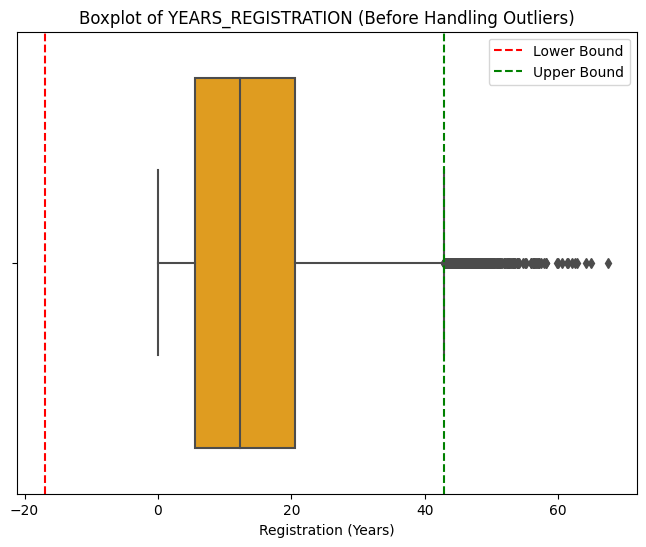

Number of outliers before handling: 659
Number of NaN values after replacing outliers: 659
Number of outliers after handling: 0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


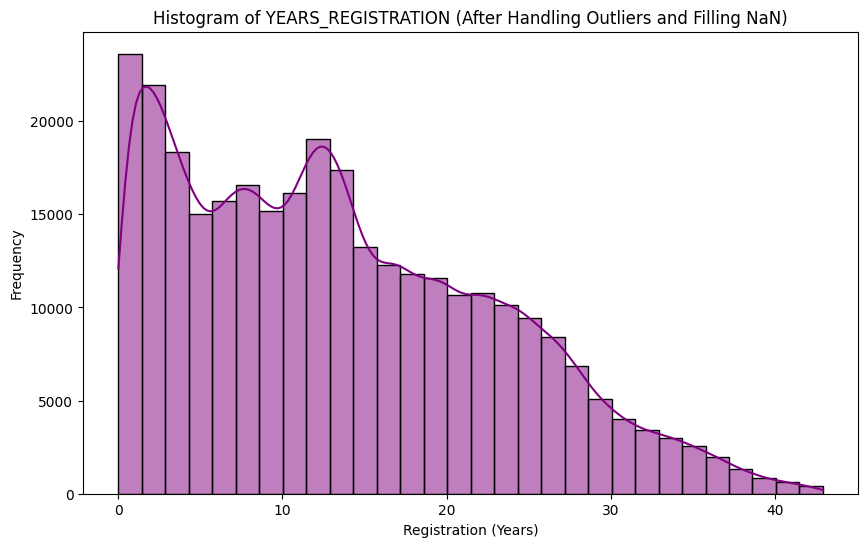

In [22]:
application_data['YEARS_REGISTRATION'] = abs(application_data['DAYS_REGISTRATION']) / 365.25
Q1 = application_data['YEARS_REGISTRATION'].quantile(0.25)
Q3 = application_data['YEARS_REGISTRATION'].quantile(0.75)
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

plt.figure(figsize=(8, 6))
sns.boxplot(x=application_data['YEARS_REGISTRATION'], color='orange')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.title("Boxplot of YEARS_REGISTRATION (Before Handling Outliers)")
plt.xlabel("Registration (Years)")
plt.legend()
plt.show()

outliers_condition = (application_data['YEARS_REGISTRATION'] < lower_bound) | (application_data['YEARS_REGISTRATION'] > upper_bound)

num_outliers = outliers_condition.sum()
print(f"Number of outliers before handling: {num_outliers}")

application_data.loc[outliers_condition, 'YEARS_REGISTRATION'] = np.nan

print(f"Number of NaN values after replacing outliers: {application_data['YEARS_REGISTRATION'].isnull().sum()}")

median_years_registration = application_data['YEARS_REGISTRATION'].median()
application_data['YEARS_REGISTRATION'].fillna(median_years_registration, inplace=True)

remaining_outliers_condition = (application_data['YEARS_REGISTRATION'] < lower_bound) | (application_data['YEARS_REGISTRATION'] > upper_bound)
num_remaining_outliers = remaining_outliers_condition.sum()

print(f"Number of outliers after handling: {num_remaining_outliers}")

plt.figure(figsize=(10, 6))
sns.histplot(application_data['YEARS_REGISTRATION'], bins=30, kde=True, color='purple')
plt.title("Histogram of YEARS_REGISTRATION (After Handling Outliers and Filling NaN)")
plt.xlabel("Registration (Years)")
plt.ylabel("Frequency")
plt.show()

In [23]:
application_data.drop(columns=['DAYS_REGISTRATION'], inplace=True)

IQR: 7.060917180013688
Lower Bound: -5.8822724161533175, Upper Bound: 22.361396303901437


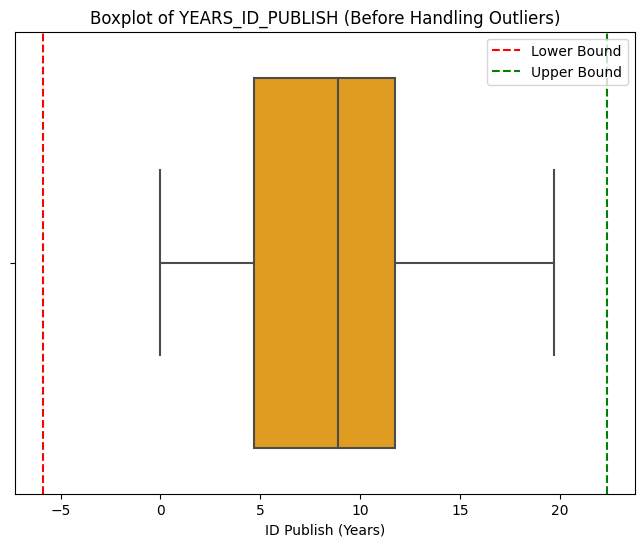

In [24]:
application_data['YEARS_ID_PUBLISH'] = abs(application_data['DAYS_ID_PUBLISH']) / 365.25
Q1 = application_data['YEARS_ID_PUBLISH'].quantile(0.25)
Q3 = application_data['YEARS_ID_PUBLISH'].quantile(0.75)
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

plt.figure(figsize=(8, 6))
sns.boxplot(x=application_data['YEARS_ID_PUBLISH'], color='orange')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.title("Boxplot of YEARS_ID_PUBLISH (Before Handling Outliers)")
plt.xlabel("ID Publish (Years)")
plt.legend()
plt.show()

application_data.drop(columns=['DAYS_ID_PUBLISH'], inplace=True)


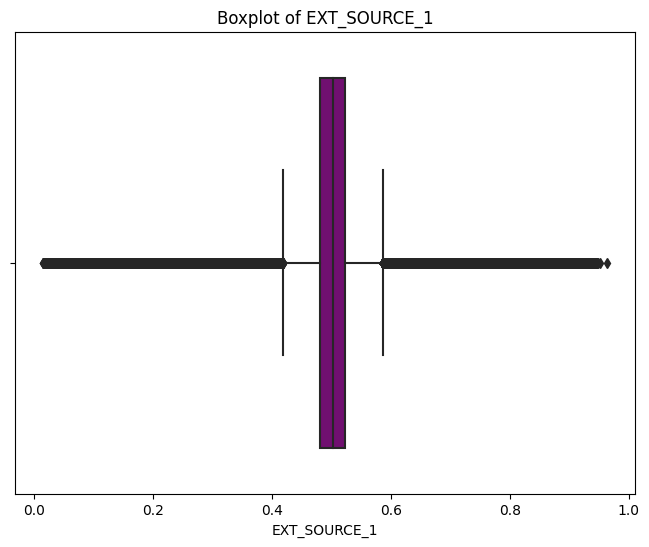

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=application_data['EXT_SOURCE_1'], color='purple')
plt.title("Boxplot of EXT_SOURCE_1")
plt.xlabel("EXT_SOURCE_1")
plt.show()


In [26]:
application_data.shape

(307511, 58)

## aggregated Bureau_balance

In [27]:
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
bureau_balance.head(50)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0        5715448               0      C
1        5715448              -1      C
2        5715448              -2      C
3        5715448              -3      C
4        5715448              -4      C
5        5715448              -5      C
6        5715448              -6      C
7        5715448              -7      C
8        5715448              -8      C
9        5715448              -9      0
10       5715448             -10      0
11       5715448             -11      X
12       5715448             -12      X
13       5715448             -13      X
14       5715448             -14      0
15       5715448             -15      0
16       5715448             -16      0
17       5715448             -17      0
18       5715448             -18      0
19       5715448             -19      0
20       5715448             -20      X
21       5715448             -21      X
22       5715448             -22      X
23       5715448             -23      X
24       5715448             -24      X
25       5715448             -25      X
26       5715448             -26      X
27       5715449               0      C
28       5715449              -1      C
29       5715449              -2      C
30       5715449              -3      C
31       5715449              -4      C
32       5715449              -5      C
33       5715449              -6      0
34       5715449              -7      0
35       5715449              -8      0
36       5715449              -9      0
37       5715449             -10      0
38       5715449             -11      X
39       5715451              -5      C
40       5715451              -6      C
41       5715451              -7      C
42       5715451              -8      C
43       5715451              -9      C
44       5715451             -10      0
45       5715451             -11      0
46       5715451             -12      0
47       5715451             -13      0
48       5715451             -14      0
49       5715451             -15      0

In [28]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [29]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [30]:
grouped_status = bureau_balance.groupby(['SK_ID_BUREAU', 'STATUS']).size()
print(grouped_status)


SK_ID_BUREAU  STATUS
5001709       C         86
              X         11
5001710       0          5
              C         48
              X         30
                        ..
6842887       0          6
              C         31
6842888       0          9
              1          1
              C         52
Length: 1714229, dtype: int64


In [31]:
pivoted_status = grouped_status.unstack(fill_value=0)
print(pivoted_status)

STATUS         0  1  2  3  4   5   C   X
SK_ID_BUREAU                            
5001709        0  0  0  0  0   0  86  11
5001710        5  0  0  0  0   0  48  30
5001711        3  0  0  0  0   0   0   1
5001712       10  0  0  0  0   0   9   0
5001713        0  0  0  0  0   0   0  22
...           .. .. .. .. ..  ..  ..  ..
6842884        9  0  0  0  0   0  20  19
6842885       12  0  0  0  0  12   0   0
6842886        8  0  0  0  0   0  25   0
6842887        6  0  0  0  0   0  31   0
6842888        9  1  0  0  0   0  52   0

[817395 rows x 8 columns]


In [32]:
pivoted_status.columns = [f'STATUS_{col}' for col in pivoted_status.columns]
pivoted_status

STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
SK_ID_BUREAU                                                               
5001709              0         0         0         0         0         0   
5001710              5         0         0         0         0         0   
5001711              3         0         0         0         0         0   
5001712             10         0         0         0         0         0   
5001713              0         0         0         0         0         0   
...                ...       ...       ...       ...       ...       ...   
6842884              9         0         0         0         0         0   
6842885             12         0         0         0         0        12   
6842886              8         0         0         0         0         0   
6842887              6         0         0         0         0         0   
6842888              9         1         0         0         0         0   

              STATUS_C  STATUS_X  
SK_ID_BUREAU                      
5001709             86        11  
5001710             48        30  
5001711              0         1  
5001712              9         0  
5001713              0        22  
...                ...       ...  
6842884             20        19  
6842885              0         0  
6842886             25         0  
6842887             31         0  
6842888             52         0  

[817395 rows x 8 columns]

In [33]:
aggregated_months_balance = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].agg(['count']).reset_index()
aggregated_months_balance.rename(columns={'count' :'TOTAL_MONTHS'}, inplace=True)
aggregated_months_balance

SK_ID_BUREAU  TOTAL_MONTHS
0            5001709            97
1            5001710            83
2            5001711             4
3            5001712            19
4            5001713            22
...              ...           ...
817390       6842884            48
817391       6842885            24
817392       6842886            33
817393       6842887            37
817394       6842888            62

[817395 rows x 2 columns]

In [34]:
pivoted_status['STATUS_DELAYED'] = pivoted_status[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis=1)
pivoted_status.head(20)

STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
SK_ID_BUREAU                                                               
5001709              0         0         0         0         0         0   
5001710              5         0         0         0         0         0   
5001711              3         0         0         0         0         0   
5001712             10         0         0         0         0         0   
5001713              0         0         0         0         0         0   
5001714              0         0         0         0         0         0   
5001715              0         0         0         0         0         0   
5001716             27         0         0         0         0         0   
5001717             17         0         0         0         0         0   
5001718             24         2         0         0         0         0   
5001719              2         0         0         0         0         0   
5001720             29         7         0         0         0         0   
5001721             13         0         0         0         0         0   
5001722             27        20         0         0         0         0   
5001723              8         0         0         0         0         0   
5001724              0         0         0         0         0         0   
5001725              7         0         0         0         0         0   
5001726              6         0         0         0         0         0   
5001727             23         0         0         0         0         0   
5001728              1         0         0         0         0         0   

              STATUS_C  STATUS_X  STATUS_DELAYED  
SK_ID_BUREAU                                      
5001709             86        11               0  
5001710             48        30               0  
5001711              0         1               0  
5001712              9         0               0  
5001713              0        22               0  
5001714              0        15               0  
5001715              0        60               0  
5001716             39        20               0  
5001717              5         0               0  
5001718              3        10               2  
5001719             41         0               0  
5001720              0         0               7  
5001721             72         0               0  
5001722             39         0              20  
5001723              0        23               0  
5001724             22         9               0  
5001725              0         1               0  
5001726             33         0               0  
5001727             72         0               0  
5001728              0         0               0

In [35]:
pivoted_status['STATUS_DELAYED'] = pivoted_status[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis=1)
pivoted_status = pivoted_status.reset_index().merge(aggregated_months_balance, on='SK_ID_BUREAU', how='left')
pivoted_status.head(20)

SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
0        5001709         0         0         0         0         0         0   
1        5001710         5         0         0         0         0         0   
2        5001711         3         0         0         0         0         0   
3        5001712        10         0         0         0         0         0   
4        5001713         0         0         0         0         0         0   
5        5001714         0         0         0         0         0         0   
6        5001715         0         0         0         0         0         0   
7        5001716        27         0         0         0         0         0   
8        5001717        17         0         0         0         0         0   
9        5001718        24         2         0         0         0         0   
10       5001719         2         0         0         0         0         0   
11       5001720        29         7         0         0         0         0   
12       5001721        13         0         0         0         0         0   
13       5001722        27        20         0         0         0         0   
14       5001723         8         0         0         0         0         0   
15       5001724         0         0         0         0         0         0   
16       5001725         7         0         0         0         0         0   
17       5001726         6         0         0         0         0         0   
18       5001727        23         0         0         0         0         0   
19       5001728         1         0         0         0         0         0   

    STATUS_C  STATUS_X  STATUS_DELAYED  TOTAL_MONTHS  
0         86        11               0            97  
1         48        30               0            83  
2          0         1               0             4  
3          9         0               0            19  
4          0        22               0            22  
5          0        15               0            15  
6          0        60               0            60  
7         39        20               0            86  
8          5         0               0            22  
9          3        10               2            39  
10        41         0               0            43  
11         0         0               7            36  
12        72         0               0            85  
13        39         0              20            86  
14         0        23               0            31  
15        22         9               0            31  
16         0         1               0             8  
17        33         0               0            39  
18        72         0               0            95  
19         0         0               0             1

In [36]:
pivoted_status = pivoted_status.reset_index().merge(aggregated_months_balance, on='SK_ID_BUREAU', how='left', suffixes=('', '_y'))

pivoted_status.drop(columns=['TOTAL_MONTHS_y'], inplace=True)

pivoted_status['STATUS_DELAYED'] = pivoted_status[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis=1)

pivoted_status['CREDIT_STATUS'] = pivoted_status.apply(
    lambda x: 'Completed' if x['STATUS_C'] > x['STATUS_DELAYED'] and x['STATUS_C'] > x['STATUS_X'] else
              'Delayed' if x['STATUS_DELAYED'] > x['STATUS_C'] and x['STATUS_DELAYED'] > x['STATUS_X'] else
              'X' if x['STATUS_X'] > x['STATUS_C'] and x['STATUS_X'] > x['STATUS_DELAYED'] else
              'No Data', axis=1
)
pivoted_status.head(30)


index  SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  \
0       0       5001709         0         0         0         0         0   
1       1       5001710         5         0         0         0         0   
2       2       5001711         3         0         0         0         0   
3       3       5001712        10         0         0         0         0   
4       4       5001713         0         0         0         0         0   
5       5       5001714         0         0         0         0         0   
6       6       5001715         0         0         0         0         0   
7       7       5001716        27         0         0         0         0   
8       8       5001717        17         0         0         0         0   
9       9       5001718        24         2         0         0         0   
10     10       5001719         2         0         0         0         0   
11     11       5001720        29         7         0         0         0   
12     12       5001721        13         0         0         0         0   
13     13       5001722        27        20         0         0         0   
14     14       5001723         8         0         0         0         0   
15     15       5001724         0         0         0         0         0   
16     16       5001725         7         0         0         0         0   
17     17       5001726         6         0         0         0         0   
18     18       5001727        23         0         0         0         0   
19     19       5001728         1         0         0         0         0   
20     20       5001729         6         0         0         0         0   
21     21       5001730         5         0         0         0         0   
22     22       5001731         0         0         0         0         0   
23     23       5001732         0         0         0         0         0   
24     24       5001733         0         0         0         0         0   
25     25       5001734         3         0         0         0         0   
26     26       5001735         1         0         0         0         0   
27     27       5001736         4         0         0         0         0   
28     28       5001737        12         0         0         0         0   
29     29       5001738        12         0         0         0         0   

    STATUS_5  STATUS_C  STATUS_X  STATUS_DELAYED  TOTAL_MONTHS CREDIT_STATUS  
0          0        86        11               0            97     Completed  
1          0        48        30               0            83     Completed  
2          0         0         1               0             4             X  
3          0         9         0               0            19     Completed  
4          0         0        22               0            22             X  
5          0         0        15               0            15             X  
6          0         0        60               0            60             X  
7          0        39        20               0            86     Completed  
8          0         5         0               0            22     Completed  
9          0         3        10               2            39             X  
10         0        41         0               0            43     Completed  
11         0         0         0               7            36       Delayed  
12         0        72         0               0            85     Completed  
13         0        39         0              20            86     Completed  
14         0         0        23               0            31             X  
15         0        22         9               0            31     Completed  
16         0         0         1               0             8             X  
17         0        33         0               0            39     Completed  
18         0        72         0               0            95     Completed  
19         0         0         0    

In [37]:
aggregated_bureau = pivoted_status
aggregated_bureau

index  SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  \
0            0       5001709         0         0         0         0   
1            1       5001710         5         0         0         0   
2            2       5001711         3         0         0         0   
3            3       5001712        10         0         0         0   
4            4       5001713         0         0         0         0   
...        ...           ...       ...       ...       ...       ...   
817390  817390       6842884         9         0         0         0   
817391  817391       6842885        12         0         0         0   
817392  817392       6842886         8         0         0         0   
817393  817393       6842887         6         0         0         0   
817394  817394       6842888         9         1         0         0   

        STATUS_4  STATUS_5  STATUS_C  STATUS_X  STATUS_DELAYED  TOTAL_MONTHS  \
0              0         0        86        11               0            97   
1              0         0        48        30               0            83   
2              0         0         0         1               0             4   
3              0         0         9         0               0            19   
4              0         0         0        22               0            22   
...          ...       ...       ...       ...             ...           ...   
817390         0         0        20        19               0            48   
817391         0        12         0         0              12            24   
817392         0         0        25         0               0            33   
817393         0         0        31         0               0            37   
817394         0         0        52         0               1            62   

       CREDIT_STATUS  
0          Completed  
1          Completed  
2                  X  
3          Completed  
4                  X  
...              ...  
817390     Completed  
817391       Delayed  
817392     Completed  
817393     Completed  
817394     Completed  

[817395 rows x 13 columns]

In [38]:
aggregated_bureau.shape

(817395, 13)

In [39]:
aggregated_bureau

index  SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  \
0            0       5001709         0         0         0         0   
1            1       5001710         5         0         0         0   
2            2       5001711         3         0         0         0   
3            3       5001712        10         0         0         0   
4            4       5001713         0         0         0         0   
...        ...           ...       ...       ...       ...       ...   
817390  817390       6842884         9         0         0         0   
817391  817391       6842885        12         0         0         0   
817392  817392       6842886         8         0         0         0   
817393  817393       6842887         6         0         0         0   
817394  817394       6842888         9         1         0         0   

        STATUS_4  STATUS_5  STATUS_C  STATUS_X  STATUS_DELAYED  TOTAL_MONTHS  \
0              0         0        86        11               0            97   
1              0         0        48        30               0            83   
2              0         0         0         1               0             4   
3              0         0         9         0               0            19   
4              0         0         0        22               0            22   
...          ...       ...       ...       ...             ...           ...   
817390         0         0        20        19               0            48   
817391         0        12         0         0              12            24   
817392         0         0        25         0               0            33   
817393         0         0        31         0               0            37   
817394         0         0        52         0               1            62   

       CREDIT_STATUS  
0          Completed  
1          Completed  
2                  X  
3          Completed  
4                  X  
...              ...  
817390     Completed  
817391       Delayed  
817392     Completed  
817393     Completed  
817394     Completed  

[817395 rows x 13 columns]

## Bureau

In [40]:
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau.head(20)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0       215354       5714462        Closed      currency 1         -497   
1       215354       5714463        Active      currency 1         -208   
2       215354       5714464        Active      currency 1         -203   
3       215354       5714465        Active      currency 1         -203   
4       215354       5714466        Active      currency 1         -629   
5       215354       5714467        Active      currency 1         -273   
6       215354       5714468        Active      currency 1          -43   
7       162297       5714469        Closed      currency 1        -1896   
8       162297       5714470        Closed      currency 1        -1146   
9       162297       5714471        Active      currency 1        -1146   
10      162297       5714472        Active      currency 1        -1146   
11      162297       5714473        Closed      currency 1        -2456   
12      162297       5714474        Active      currency 1         -277   
13      402440       5714475        Active      currency 1          -96   
14      238881       5714482        Closed      currency 1         -318   
15      238881       5714484        Closed      currency 1        -2911   
16      238881       5714485        Closed      currency 1        -2148   
17      238881       5714486        Active      currency 1         -381   
18      238881       5714487        Active      currency 1          -95   
19      238881       5714488        Closed      currency 1         -444   

    CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                    0               -153.0             -153.0   
1                    0               1075.0                NaN   
2                    0                528.0                NaN   
3                    0                  NaN                NaN   
4                    0               1197.0                NaN   
5                    0              27460.0                NaN   
6                    0                 79.0                NaN   
7                    0              -1684.0            -1710.0   
8                    0               -811.0             -840.0   
9                    0               -484.0                NaN   
10                   0               -180.0                NaN   
11                   0               -629.0             -825.0   
12                   0               5261.0                NaN   
13                   0                269.0                NaN   
14                   0               -187.0             -187.0   
15                   0              -2607.0            -2604.0   
16                   0              -1595.0             -987.0   
17                   0                  NaN                NaN   
18                   0               1720.0                NaN   
19                   0                -77.0              -77.0   

    AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                      NaN                   0        91323.00   
1                      NaN                   0       225000.00   
2                      NaN                   0       464323.50   
3                      NaN                   0        90000.00   
4                  77674.5                   0      2700000.00   
5                      0.0                   0       180000.00   
6                      0.0                   0        42103.80   
7                  14985.0                   0        76878.45   
8                      0.0                   0       103007.70   
9                      0.0                   0         4500.00   
10                     0.0                   0       337500.00   
11                     NaN                   0       675000.00   
12                     0.0                   0      7033500.00   
13                     0.0                   0        89910.00   
14                     NaN                   0     

In [41]:
bureau.shape

(1716428, 17)

In [42]:
bureau['CREDIT_ACTIVE'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [43]:
bureau['CREDIT_CURRENCY'].unique()

array(['currency 1', 'currency 2', 'currency 4', 'currency 3'],
      dtype=object)

In [44]:
len(bureau['CREDIT_TYPE'].unique())

15

In [45]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## aggregated bureau_balance && bureau

In [46]:
left_tables = bureau.merge(
    aggregated_bureau,  
    on='SK_ID_BUREAU',               
    how='left'                      
)
left_tables.fillna(0,inplace=True)

In [47]:
left_tables

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                0.0   
2                         0                528.0                0.0   
3                         0                  0.0                0.0   
4                         0               1197.0                0.0   
...                     ...                  ...                ...   
1716423                   0                -30.0                0.0   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  0.0             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  STATUS_1  STATUS_2  \
0                           0.0                   0  ...       0.0       0.0   
1                           0.0                   0  ...       0.0       0.0   
2                           0.0                   0  ...       0.0       0.0   
3                           0.0                   0  ...       0.0       0.0   
4                       77674.5                   0  ...       0.0       0.0   
...                         ...                 ...  ...       ...       ...   
1716423                     0.0                   0  ...       0.0       0.0   
1716424                  5476.5                   0  ...       0.0       0.0   
1716425                     0.0                   0  ...       0.0       0.0   
1716426                     0.0                   0  ...       0.0       0.0   
1716427                     0.0                   0  ...       0.0       0.0   

         STATUS_3  STATUS_4 STATUS_5  STATUS_C  STATUS_X  STATUS_DELAYED  \
0             0.0       0.0      0.0       0.0       0.0             0.0   
1             0.0       0.0      0.0       0.0       0.0             0.0   
2             0.0       0.0      0.0       0.0       0.0             0.0   
3             0.0       0.0      0.0       0.0       0.0             0.0   
4             0.0       0.0      0.0       0.0       0.0             0.0   
...           ...       ...      ...       ...       ...             ...   
1716423       0.0       0.0      0.0       0.0       0.0             0.0   
1716424       0.0       0.0      0.0       0.0       0.0             0.0   
1716425       0.0       0.0      0.0       0.0       0.0             0.0   
1716426       0.0       0.0      0.0       0.0       0.0             0.0   
1716427       0.0       0.0      0.0       0.0       0.0             0.0   

         TOTAL_MONTHS  CREDIT_STATUS  
0                 0.0              0  
1                 0.0              0  
2                 0.0              0  
3                 0.0              0  
4                 0.0              0  
...               ...            ...  
1716423           0.0              0  
1716424  

## (Aggregation_categorical columns)

In [48]:
categorical_columns = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'CREDIT_STATUS']
individual_aggregations = {}
for column in categorical_columns:
    print(f"Processing column: {column}")
    grouped_categorical = left_tables.groupby(['SK_ID_CURR', column]).size().unstack(fill_value=0)
    grouped_categorical.columns = [f'{column}_{col}' for col in grouped_categorical.columns]
    grouped_categorical.reset_index(inplace=True)
    individual_aggregations[column] = grouped_categorical
    print(grouped_categorical.head())

Processing column: CREDIT_ACTIVE
   SK_ID_CURR  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0      100001                     3                       0   
1      100002                     2                       0   
2      100003                     1                       0   
3      100004                     0                       0   
4      100005                     2                       0   

   CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  
0                     4                   0  
1                     6                   0  
2                     3                   0  
3                     2                   0  
4                     1                   0  
Processing column: CREDIT_CURRENCY
   SK_ID_CURR  CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2  \
0      100001                           7                           0   
1      100002                           8                           0   
2      100003                           4                 

## (Aggregation_numerical_columns)

In [49]:
 numerical_columns = left_tables.select_dtypes(include=['int64', 'float64']).columns.tolist()
 print("Numerical Columns in Final_data:")
 print(numerical_columns)

Numerical Columns in Final_data:
['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'index', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X', 'STATUS_DELAYED', 'TOTAL_MONTHS']


In [50]:
 aggregated_Days_Credit=left_tables.groupby('SK_ID_CURR')['DAYS_CREDIT'].agg(['max']).reset_index()
 aggregated_Days_Credit.rename(columns={'max' :'DAYS_CREDIT_MAX'}, inplace=True)
 aggregated_Days_Credit

SK_ID_CURR  DAYS_CREDIT_MAX
0           100001              -49
1           100002             -103
2           100003             -606
3           100004             -408
4           100005              -62
...            ...              ...
305806      456249             -483
305807      456250             -760
305808      456253             -713
305809      456254            -1104
305810      456255             -363

[305811 rows x 2 columns]

In [51]:
 aggregated_CREDIT_DAY_OVERDUE=left_tables.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].agg(['max']).reset_index()
 aggregated_CREDIT_DAY_OVERDUE.rename(columns={'max' :'CREDIT_DAY_OVERDUE_MAX'}, inplace=True)
 aggregated_CREDIT_DAY_OVERDUE

SK_ID_CURR  CREDIT_DAY_OVERDUE_MAX
0           100001                       0
1           100002                       0
2           100003                       0
3           100004                       0
4           100005                       0
...            ...                     ...
305806      456249                       0
305807      456250                       0
305808      456253                       0
305809      456254                       0
305810      456255                       0

[305811 rows x 2 columns]

In [52]:

aggregated_DAYS_CREDIT_ENDDATE=left_tables.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].agg(['min']).reset_index()
aggregated_DAYS_CREDIT_ENDDATE.rename(columns={'min' :'DAYS_CREDIT_ENDDATE_MIN'}, inplace=True)
aggregated_DAYS_CREDIT_ENDDATE

SK_ID_CURR  DAYS_CREDIT_ENDDATE_MIN
0           100001                  -1329.0
1           100002                  -1072.0
2           100003                  -2434.0
3           100004                   -595.0
4           100005                   -128.0
...            ...                      ...
305806      456249                  -2499.0
305807      456250                   -272.0
305808      456253                   -189.0
305809      456254                   -859.0
305810      456255                  -1243.0

[305811 rows x 2 columns]

In [53]:
aggregated_DAYS_ENDDATE_FACT=left_tables.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].agg(['max']).reset_index()
aggregated_DAYS_ENDDATE_FACT.rename(columns={'max' :'DAYS_ENDDATE_FACT_MAX'}, inplace=True)
aggregated_DAYS_ENDDATE_FACT

SK_ID_CURR  DAYS_ENDDATE_FACT_MAX
0           100001                    0.0
1           100002                    0.0
2           100003                    0.0
3           100004                 -382.0
4           100005                    0.0
...            ...                    ...
305806      456249                    0.0
305807      456250                    0.0
305808      456253                    0.0
305809      456254                 -859.0
305810      456255                    0.0

[305811 rows x 2 columns]

In [54]:
aggregated_AMT_CREDIT_MAX_OVERDUE=left_tables.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].agg(['max']).reset_index()
aggregated_AMT_CREDIT_MAX_OVERDUE.rename(columns={'max' :'AMT_CREDIT_MAX_OVERDUE_MAX'}, inplace=True)
aggregated_AMT_CREDIT_MAX_OVERDUE

SK_ID_CURR  AMT_CREDIT_MAX_OVERDUE_MAX
0           100001                       0.000
1           100002                    5043.645
2           100003                       0.000
3           100004                       0.000
4           100005                       0.000
...            ...                         ...
305806      456249                   18945.000
305807      456250                       0.000
305808      456253                       0.000
305809      456254                       0.000
305810      456255                   25578.000

[305811 rows x 2 columns]

In [55]:
 aggregated_CNT_CREDIT_PROLONG=left_tables.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].agg(['max']).reset_index()
 aggregated_CNT_CREDIT_PROLONG.rename(columns={'max':'CNT_CREDIT_PROLONG_MAX'}, inplace=True)
 aggregated_CNT_CREDIT_PROLONG

SK_ID_CURR  CNT_CREDIT_PROLONG_MAX
0           100001                       0
1           100002                       0
2           100003                       0
3           100004                       0
4           100005                       0
...            ...                     ...
305806      456249                       0
305807      456250                       0
305808      456253                       0
305809      456254                       0
305810      456255                       1

[305811 rows x 2 columns]

In [56]:
aggregated_AMT_CREDIT_SUM=left_tables.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['sum']).reset_index()
aggregated_AMT_CREDIT_SUM.rename(columns={'sum' :'AMT_CREDIT_SUM_SUM','mean':'AMT_CREDIT_SUM_MEAN'}, inplace=True)
aggregated_AMT_CREDIT_SUM

SK_ID_CURR  AMT_CREDIT_SUM_SUM
0           100001         1453365.000
1           100002          865055.565
2           100003         1017400.500
3           100004          189037.800
4           100005          657126.000
...            ...                 ...
305806      456249         3693858.660
305807      456250         3086459.550
305808      456253         3960000.000
305809      456254           45000.000
305810      456255         3801919.500

[305811 rows x 2 columns]

In [57]:
aggregated_AMT_CREDIT_SUM_DEBT=left_tables.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].agg(['sum']).reset_index()
aggregated_AMT_CREDIT_SUM_DEBT.rename(columns={'sum' :'AMT_CREDIT_SUM_DEBT_SUM'}, inplace=True)
aggregated_AMT_CREDIT_SUM_DEBT

SK_ID_CURR  AMT_CREDIT_SUM_DEBT_SUM
0           100001               596686.500
1           100002               245781.000
2           100003                    0.000
3           100004                    0.000
4           100005               568408.500
...            ...                      ...
305806      456249               163071.000
305807      456250              2232040.095
305808      456253              1795833.000
305809      456254                    0.000
305810      456255              1534913.010

[305811 rows x 2 columns]

In [58]:
 aggregated_AMT_CREDIT_SUM_LIMIT=left_tables.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].agg(['mean']).reset_index()
 aggregated_AMT_CREDIT_SUM_LIMIT.rename(columns={'mean' :'AMT_CREDIT_SUM_LIMIT_MEAN'}, inplace=True)
 aggregated_AMT_CREDIT_SUM_LIMIT['AMT_CREDIT_SUM_LIMIT_MEAN'].fillna(0,inplace=True)
 aggregated_AMT_CREDIT_SUM_LIMIT

SK_ID_CURR  AMT_CREDIT_SUM_LIMIT_MEAN
0           100001                   0.000000
1           100002                3998.570625
2           100003              202500.000000
3           100004                   0.000000
4           100005                   0.000000
...            ...                        ...
305806      456249                   0.000000
305807      456250               19422.795000
305808      456253                   0.000000
305809      456254                   0.000000
305810      456255                   0.000000

[305811 rows x 2 columns]

In [59]:
 aggregated_AMT_CREDIT_SUM_OVERDUE=left_tables.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].agg(['max']).reset_index()
 aggregated_AMT_CREDIT_SUM_OVERDUE.rename(columns={'max' :'AMT_CREDIT_SUM_OVERDUE_MAX'}, inplace=True)
 aggregated_AMT_CREDIT_SUM_OVERDUE

SK_ID_CURR  AMT_CREDIT_SUM_OVERDUE_MAX
0           100001                         0.0
1           100002                         0.0
2           100003                         0.0
3           100004                         0.0
4           100005                         0.0
...            ...                         ...
305806      456249                         0.0
305807      456250                         0.0
305808      456253                         0.0
305809      456254                         0.0
305810      456255                         0.0

[305811 rows x 2 columns]

In [60]:
 aggregated_DAYS_CREDIT_UPDATE=left_tables.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].agg(['min']).reset_index()
 aggregated_DAYS_CREDIT_UPDATE.rename(columns={'min' :'DAYS_CREDIT_UPDATE_MIN'}, inplace=True)
 aggregated_DAYS_CREDIT_UPDATE

SK_ID_CURR  DAYS_CREDIT_UPDATE_MIN
0           100001                    -155
1           100002                   -1185
2           100003                   -2131
3           100004                    -682
4           100005                    -121
...            ...                     ...
305806      456249                   -2498
305807      456250                    -127
305808      456253                    -701
305809      456254                    -401
305810      456255                   -1621

[305811 rows x 2 columns]

In [61]:
aggregated_AMT_ANNUITY=left_tables.groupby('SK_ID_CURR')['AMT_ANNUITY'].agg(['mean']).reset_index()
aggregated_AMT_ANNUITY.rename(columns={'mean' :'AMT_ANNUITY_MEAN'}, inplace=True)
aggregated_AMT_ANNUITY['AMT_ANNUITY_MEAN'].fillna(0,inplace=True)
aggregated_AMT_ANNUITY

SK_ID_CURR  AMT_ANNUITY_MEAN
0           100001       3545.357143
1           100002          0.000000
2           100003          0.000000
3           100004          0.000000
4           100005       1420.500000
...            ...               ...
305806      456249          0.000000
305807      456250     154567.965000
305808      456253      43777.125000
305809      456254          0.000000
305810      456255        884.863636

[305811 rows x 2 columns]

In [62]:
aggregated_status_0=left_tables.groupby('SK_ID_CURR')['STATUS_0'].agg('sum').reset_index()
aggregated_status_0

SK_ID_CURR  STATUS_0
0           100001      31.0
1           100002      45.0
2           100003       0.0
3           100004       0.0
4           100005      14.0
...            ...       ...
305806      456249       0.0
305807      456250      12.0
305808      456253      47.0
305809      456254       8.0
305810      456255      63.0

[305811 rows x 2 columns]

In [63]:
aggregated_status_1=left_tables.groupby('SK_ID_CURR')['STATUS_1'].agg('sum').reset_index()
aggregated_status_1

SK_ID_CURR  STATUS_1
0           100001       1.0
1           100002      27.0
2           100003       0.0
3           100004       0.0
4           100005       0.0
...            ...       ...
305806      456249       0.0
305807      456250       0.0
305808      456253       0.0
305809      456254       0.0
305810      456255       0.0

[305811 rows x 2 columns]

In [64]:
aggregated_status_2=left_tables.groupby('SK_ID_CURR')['STATUS_2'].agg('count').reset_index()
aggregated_status_2

SK_ID_CURR  STATUS_2
0           100001         7
1           100002         8
2           100003         4
3           100004         2
4           100005         3
...            ...       ...
305806      456249        13
305807      456250         3
305808      456253         4
305809      456254         1
305810      456255        11

[305811 rows x 2 columns]

In [65]:
aggregated_status_3=left_tables.groupby('SK_ID_CURR')['STATUS_3'].agg('count').reset_index()
aggregated_status_3

SK_ID_CURR  STATUS_3
0           100001         7
1           100002         8
2           100003         4
3           100004         2
4           100005         3
...            ...       ...
305806      456249        13
305807      456250         3
305808      456253         4
305809      456254         1
305810      456255        11

[305811 rows x 2 columns]

In [66]:
aggregated_status_4=left_tables.groupby('SK_ID_CURR')['STATUS_4'].agg('count').reset_index()
aggregated_status_4

SK_ID_CURR  STATUS_4
0           100001         7
1           100002         8
2           100003         4
3           100004         2
4           100005         3
...            ...       ...
305806      456249        13
305807      456250         3
305808      456253         4
305809      456254         1
305810      456255        11

[305811 rows x 2 columns]

In [67]:
aggregated_status_5=left_tables.groupby('SK_ID_CURR')['STATUS_5'].agg('count').reset_index()
aggregated_status_5

SK_ID_CURR  STATUS_5
0           100001         7
1           100002         8
2           100003         4
3           100004         2
4           100005         3
...            ...       ...
305806      456249        13
305807      456250         3
305808      456253         4
305809      456254         1
305810      456255        11

[305811 rows x 2 columns]

In [68]:
aggregated_status_X=left_tables.groupby('SK_ID_CURR')['STATUS_X'].agg('sum').reset_index()
aggregated_status_X

SK_ID_CURR  STATUS_X
0           100001      30.0
1           100002      15.0
2           100003       0.0
3           100004       0.0
4           100005       2.0
...            ...       ...
305806      456249       0.0
305807      456250      50.0
305808      456253      13.0
305809      456254       0.0
305810      456255      17.0

[305811 rows x 2 columns]

In [69]:
aggregated_status_C=left_tables.groupby('SK_ID_CURR')['STATUS_C'].agg('sum').reset_index()
aggregated_status_C

SK_ID_CURR  STATUS_C
0           100001     110.0
1           100002      23.0
2           100003       0.0
3           100004       0.0
4           100005       5.0
...            ...       ...
305806      456249       0.0
305807      456250      25.0
305808      456253      57.0
305809      456254      29.0
305810      456255     213.0

[305811 rows x 2 columns]

In [70]:
aggregated_TOTAL_MONTHS=left_tables.groupby('SK_ID_CURR')['TOTAL_MONTHS'].agg('count').reset_index()
aggregated_TOTAL_MONTHS

SK_ID_CURR  TOTAL_MONTHS
0           100001             7
1           100002             8
2           100003             4
3           100004             2
4           100005             3
...            ...           ...
305806      456249            13
305807      456250             3
305808      456253             4
305809      456254             1
305810      456255            11

[305811 rows x 2 columns]

In [71]:
aggregated_STATUS_DELAYED=left_tables.groupby('SK_ID_CURR')['STATUS_DELAYED'].agg('sum').reset_index()
aggregated_STATUS_DELAYED

SK_ID_CURR  STATUS_DELAYED
0           100001             1.0
1           100002            27.0
2           100003             0.0
3           100004             0.0
4           100005             0.0
...            ...             ...
305806      456249             0.0
305807      456250             0.0
305808      456253             0.0
305809      456254             0.0
305810      456255             0.0

[305811 rows x 2 columns]

## merging all DataFrame based on the SK_ID_CURR column

In [72]:
aggregated_dataframes = [
    aggregated_Days_Credit,
    aggregated_CREDIT_DAY_OVERDUE,
    aggregated_DAYS_CREDIT_ENDDATE,
    aggregated_DAYS_ENDDATE_FACT,
    aggregated_AMT_CREDIT_MAX_OVERDUE,
    aggregated_CNT_CREDIT_PROLONG,
    aggregated_AMT_CREDIT_SUM,
    aggregated_AMT_CREDIT_SUM_DEBT,
    aggregated_AMT_CREDIT_SUM_LIMIT,
    aggregated_AMT_CREDIT_SUM_OVERDUE,
    aggregated_DAYS_CREDIT_UPDATE,
    aggregated_AMT_ANNUITY,
    aggregated_status_0,
    aggregated_status_1,
    aggregated_status_2,
    aggregated_status_3,
    aggregated_status_4,
    aggregated_status_5,
    aggregated_status_C,
    aggregated_status_X,aggregated_STATUS_DELAYED,
    aggregated_TOTAL_MONTHS
]
aggregated_final_data = pd.concat(aggregated_dataframes, axis=1)
aggregated_final_data = aggregated_final_data.loc[:, ~aggregated_final_data.columns.duplicated()]
aggregated_left_tables =aggregated_final_data

In [73]:
aggregated_left_tables

SK_ID_CURR  DAYS_CREDIT_MAX  CREDIT_DAY_OVERDUE_MAX  \
0           100001              -49                       0   
1           100002             -103                       0   
2           100003             -606                       0   
3           100004             -408                       0   
4           100005              -62                       0   
...            ...              ...                     ...   
305806      456249             -483                       0   
305807      456250             -760                       0   
305808      456253             -713                       0   
305809      456254            -1104                       0   
305810      456255             -363                       0   

        DAYS_CREDIT_ENDDATE_MIN  DAYS_ENDDATE_FACT_MAX  \
0                       -1329.0                    0.0   
1                       -1072.0                    0.0   
2                       -2434.0                    0.0   
3                        -595.0                 -382.0   
4                        -128.0                    0.0   
...                         ...                    ...   
305806                  -2499.0                    0.0   
305807                   -272.0                    0.0   
305808                   -189.0                    0.0   
305809                   -859.0                 -859.0   
305810                  -1243.0                    0.0   

        AMT_CREDIT_MAX_OVERDUE_MAX  CNT_CREDIT_PROLONG_MAX  \
0                            0.000                       0   
1                         5043.645                       0   
2                            0.000                       0   
3                            0.000                       0   
4                            0.000                       0   
...                            ...                     ...   
305806                   18945.000                       0   
305807                       0.000                       0   
305808                       0.000                       0   
305809                       0.000                       0   
305810                   25578.000                       1   

        AMT_CREDIT_SUM_SUM  AMT_CREDIT_SUM_DEBT_SUM  \
0              1453365.000               596686.500   
1               865055.565               245781.000   
2              1017400.500                    0.000   
3               189037.800                    0.000   
4               657126.000               568408.500   
...                    ...                      ...   
305806         3693858.660               163071.000   
305807         3086459.550              2232040.095   
305808         3960000.000              1795833.000   
305809           45000.000                    0.000   
305810         3801919.500              1534913.010   

        AMT_CREDIT_SUM_LIMIT_MEAN  ...  STATUS_0  STATUS_1  STATUS_2  \
0                        0.000000  ...      31.0       1.0         7   
1                     3998.570625  ...      45.0      27.0         8   
2                   202500.000000  ...       0.0       0.0         4   
3                        0.000000  ...       0.0       0.0         2   
4                        0.000000  ...      14.0       0.0         3   
...                           ...  ...       ...       ...       ...   
305806                   0.000000  ...       0.0       0.0        13   
305807               19422.795000  ...      12.0       0.0         3   
305808                   0.000000  ...      47.0       0.0         4   
305809                   0.000000  ...       8.0       0.0         1   
305810                   0.000000  ...      63.0       0.0        11   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  STATUS_DELAYED  \
0              7         7         7     110.0      30.0             1.0   
1              8         8         8      23.0      15.0            27.0   
2              4         4         4       0.0       0.

## Aggregated previous_application

In [74]:
previous_application=pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
previous_application

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
0                         SATURDAY                       15  ...   
1                         THURSDAY                       11  ...   
2                          TUESDAY                       11  ...   
3                           MONDAY                        7  ...   
4                         THURSDAY                        9  ...   
...                            ...                      ...  ...   
1670209                  WEDNESDAY                       12  ...   
1670210                    TUESDAY                       15  ...   
1670211                     MONDAY                       12  ...   
1670212                  WEDNESDAY                        9  ...   
1670213                     SUNDAY                       10  ...   

         NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0                Connectivity         12.0            middle   
1                         XNA         36.0        low_action   
2                         XNA         12.0              high   
3                         XNA         12.0            middle   
4                         XNA         24.0              high   
...                       ...          ...               ...   
1670209             Furniture         30.0        low_normal   
1670210             Furniture         12.0            middle   
1670211  Consumer electronics         10.0        low_normal   
1670212                   XNA         12.0        low_normal   
1670213                   XNA         48.0            middle   

                 PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0           POS mobile with interest            365243.0          -42.0   
1                   Cash X-Sell: low            365243.0         -134.0   
2                  Cash X-Sell: high            365243.0         -271.0   
3                Cash X-Sell: middle            365243.0         -482.0   
4                  Cash Street: high                 NaN            NaN   
...                              ...                 ...            ...   
1670209   POS industry with interest            365243.0         -508.0   
1670210   POS industry with interest            365243.0        -1604.0   
1670211  POS household with interest      

In [75]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [76]:
columns_to_drop = [
    "SK_ID_PREV",
    "WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START",
    "FLAG_LAST_APPL_PER_CONTRACT",
    "NFLAG_LAST_APPL_IN_DAY",
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_PAYMENT_TYPE",
    "NAME_TYPE_SUITE",
    "NAME_CLIENT_TYPE",
    "NAME_PRODUCT_TYPE",
    "CHANNEL_TYPE",
    "SELLERPLACE_AREA",
    "NAME_SELLER_INDUSTRY",
    "PRODUCT_COMBINATION",
    "NFLAG_INSURED_ON_APPROVAL"
]
previous_application = previous_application.drop(columns=[col for col in columns_to_drop if col in previous_application.columns])
previous_application

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0            271877     Consumer loans     1730.430          17145.0   
1            108129         Cash loans    25188.615         607500.0   
2            122040         Cash loans    15060.735         112500.0   
3            176158         Cash loans    47041.335         450000.0   
4            202054         Cash loans    31924.395         337500.0   
...             ...                ...          ...              ...   
1670209      352015     Consumer loans    14704.290         267295.5   
1670210      334635     Consumer loans     6622.020          87750.0   
1670211      249544     Consumer loans    11520.855         105237.0   
1670212      400317         Cash loans    18821.520         180000.0   
1670213      261212         Cash loans    16431.300         360000.0   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  RATE_DOWN_PAYMENT  \
0           17145.0               0.0          17145.0           0.000000   
1          679671.0               NaN         607500.0                NaN   
2          136444.5               NaN         112500.0                NaN   
3          470790.0               NaN         450000.0                NaN   
4          404055.0               NaN         337500.0                NaN   
...             ...               ...              ...                ...   
1670209    311400.0               0.0         267295.5           0.000000   
1670210     64291.5           29250.0          87750.0           0.340554   
1670211    102523.5           10525.5         105237.0           0.101401   
1670212    191880.0               NaN         180000.0                NaN   
1670213    360000.0               NaN         360000.0                NaN   

         RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  ...  \
0                     0.182832                  0.867336  ...   
1                          NaN                       NaN  ...   
2                          NaN                       NaN  ...   
3                          NaN                       NaN  ...   
4                          NaN                       NaN  ...   
...                        ...                       ...  ...   
1670209                    NaN                       NaN  ...   
1670210                    NaN                       NaN  ...   
1670211                    NaN                       NaN  ...   
1670212                    NaN                       NaN  ...   
1670213                    NaN                       NaN  ...   

        CODE_REJECT_REASON   NAME_GOODS_CATEGORY NAME_PORTFOLIO CNT_PAYMENT  \
0                      XAP                Mobile            POS        12.0   
1                      XAP                   XNA           Cash        36.0   
2                      XAP                   XNA           Cash        12.0   
3                      XAP                   XNA           Cash        12.0   
4                       HC                   XNA           Cash        24.0   
...                    ...                   ...            ...         ...   
1670209                XAP             Furniture            POS        30.0   
1670210                XAP             Furniture            POS        12.0   
1670211                XAP  Consumer Electronics            POS        10.0   
1670212                XAP                   XNA           Cash        12.0   
1670213                XAP                   XNA           Cash        48.0   

        NAME_YIELD_GROUP  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0                 middle            365243.0          -42.0   
1             low_action            365243.0         -134.0   
2                   high            365243.0         -271.0   
3                 middle            365243.0         -482.0   
4                   high                 NaN            NaN   
...                  ...                 ...            ...   
1670209       low_normal            365243.0    

In [77]:
aggregations = {
    'AMT_APPLICATION': 'mean',
    'AMT_ANNUITY': 'mean',
    'AMT_CREDIT': 'mean',
    'AMT_DOWN_PAYMENT': 'max',
    'AMT_GOODS_PRICE': 'mean',
    'RATE_DOWN_PAYMENT': 'mean',
    'RATE_INTEREST_PRIMARY': 'mean',
    'DAYS_DECISION': 'min',
    'CNT_PAYMENT': 'max',
    'DAYS_FIRST_DRAWING': 'min',
    'DAYS_FIRST_DUE': 'min',
    'DAYS_LAST_DUE': 'max',
    'DAYS_TERMINATION': 'max',
    'NAME_CONTRACT_TYPE': 'count',
    'NAME_CONTRACT_STATUS': 'count',
    'NAME_GOODS_CATEGORY': 'count',
    'NAME_PORTFOLIO': 'count',
    'NAME_YIELD_GROUP': 'count',
}
aggregated_previous_application = previous_application.groupby('SK_ID_CURR').agg(aggregations)
aggregated_previous_application.columns = [
    f"{col}_{aggregations[col].upper()}" for col in aggregated_previous_application.columns
]
aggregated_previous_application.reset_index(inplace=True)
aggregated_previous_application

SK_ID_CURR  AMT_APPLICATION_MEAN  AMT_ANNUITY_MEAN  AMT_CREDIT_MEAN  \
0           100001             24835.500       3951.000000         23787.00   
1           100002            179055.000       9251.775000        179055.00   
2           100003            435436.500      56553.990000        484191.00   
3           100004             24282.000       5357.250000         20106.00   
4           100005             22308.750       4813.200000         20076.75   
...            ...                   ...               ...              ...   
338852      456251             40455.000       6605.910000         40455.00   
338853      456252             57595.500      10074.465000         56821.50   
338854      456253             24162.750       4770.405000         20625.75   
338855      456254            121317.750      10681.132500        134439.75   
338856      456255            362770.875      20775.391875        424431.00   

        AMT_DOWN_PAYMENT_MAX  AMT_GOODS_PRICE_MEAN  RATE_DOWN_PAYMENT_MEAN  \
0                     2520.0             24835.500                0.104326   
1                        0.0            179055.000                0.000000   
2                     6885.0            435436.500                0.050030   
3                     4860.0             24282.000                0.212008   
4                     4464.0             44617.500                0.108964   
...                      ...                   ...                     ...   
338852                   0.0             40455.000                0.000000   
338853                3456.0             57595.500                0.062443   
338854                5913.0             24162.750                0.214316   
338855                   0.0            121317.750                0.000000   
338856                9000.0            362770.875                0.064780   

        RATE_INTEREST_PRIMARY_MEAN  DAYS_DECISION_MIN  CNT_PAYMENT_MAX  \
0                              NaN              -1740              8.0   
1                              NaN               -606             24.0   
2                              NaN              -2341             12.0   
3                              NaN               -815              4.0   
4                              NaN               -757             12.0   
...                            ...                ...              ...   
338852                         NaN               -273              8.0   
338853                         NaN              -2497              6.0   
338854                         NaN              -2851              6.0   
338855                         NaN               -322             16.0   
338856                         NaN               -991             60.0   

        DAYS_FIRST_DRAWING_MIN  DAYS_FIRST_DUE_MIN  DAYS_LAST_DUE_MAX  \
0                     365243.0             -1709.0            -1619.0   
1                     365243.0              -565.0              -25.0   
2                     365243.0             -2310.0             -536.0   
3                     365243.0              -784.0             -724.0   
4                     365243.0              -706.0             -466.0   
...                        ...                 ...                ...   
338852                365243.0              -210.0              -30.0   
338853                365243.0             -2466.0            -2316.0   
338854                365243.0             -2812.0            -1716.0   
338855                365243.0              -291.0           365243.0   
338856                365243.0              -960.0              -66.0   

        DAYS_TERMINATION_MAX  NAME_CONTRACT_TYPE_COUNT  \
0                    -1612.0                         1   
1                      -17.0                         1   
2                     -527.0                         3   
3                     -714.0                         1   
4                     -460.0                         2   
...     

## Aggregated POS_CACH_balance

In [78]:
POS_CACH_balance=pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
POS_CACH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [79]:
POS_CACH_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [86]:
aggregations = {
    'MONTHS_BALANCE': 'count',  # Count months of balance
    'CNT_INSTALMENT': ['mean', 'max'],  # Average and maximum installments
    'CNT_INSTALMENT_FUTURE': ['mean', 'sum'],  # Average and total remaining installments
    'SK_DPD': ['mean', 'max'],  # Average and maximum days past due
    'SK_DPD_DEF': 'mean'  # Average days past due with tolerance
}
pos_agg = POS_CACH_balance.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pos_agg.columns]
contract_statuses = ['Active', 'Completed', 'Signed', 'Demand']

for status in contract_statuses:
    pos_agg[f'NAME_CONTRACT_STATUS_{status}'] = (
        (POS_CACH_balance['NAME_CONTRACT_STATUS'] == status)
        .groupby(POS_CACH_balance['SK_ID_CURR']).transform('sum')
    )
pos_agg = pos_agg.reset_index()

aggregated_POS_CACH_balance = pos_agg


In [87]:
pos_agg

SK_ID_CURR  MONTHS_BALANCE_count  CNT_INSTALMENT_mean  \
0           100001                     9             4.000000   
1           100002                    19            24.000000   
2           100003                    28            10.107143   
3           100004                     4             3.750000   
4           100005                    11            11.700000   
...            ...                   ...                  ...   
337247      456251                     9             7.875000   
337248      456252                     7             6.000000   
337249      456253                    17             6.705882   
337250      456254                    20            14.900000   
337251      456255                    71            22.788732   

        CNT_INSTALMENT_max  CNT_INSTALMENT_FUTURE_mean  \
0                      4.0                    1.444444   
1                     24.0                   15.000000   
2                     12.0                    5.785714   
3                      4.0                    2.250000   
4                     12.0                    7.200000   
...                    ...                         ...   
337247                 8.0                    4.375000   
337248                 6.0                    3.000000   
337249                12.0                    2.000000   
337250                16.0                   10.350000   
337251                36.0                   15.140845   

        CNT_INSTALMENT_FUTURE_sum  SK_DPD_mean  SK_DPD_max  SK_DPD_DEF_mean  \
0                            13.0     0.777778           7         0.777778   
1                           285.0     0.000000           0         0.000000   
2                           162.0     0.000000           0         0.000000   
3                             9.0     0.000000           0         0.000000   
4                            72.0     0.000000           0         0.000000   
...                           ...          ...         ...              ...   
337247                       35.0     0.000000           0         0.000000   
337248                       21.0     0.000000           0         0.000000   
337249                       34.0     0.294118           5         0.294118   
337250                      207.0     0.000000           0         0.000000   
337251                     1075.0     0.070423           5         0.070423   

        NAME_CONTRACT_STATUS_Active  NAME_CONTRACT_STATUS_Completed  \
0                                67                               6   
1                                18                               2   
2                                70                               3   
3                                42                               3   
4                                39                               4   
...                             ...                             ...   
337247                           96                               6   
337248                           29                               2   
337249                           26                               5   
337250                           21                               1   
337251                           35                               1   

        NAME_CONTRACT_STATUS_Signed  NAME_CONTRACT_STATUS_Demand  
0                                 0                            0  
1                                 0                            0  
2                                 1                            0  
3                                 0                            0  
4                                 1                            0  
...                             ...                          ...  
337247                            0                            0  
337248                            0                            0  
337249                            0                            0  
337250                            0                       

# Aggregated installments_payments

In [88]:
installments_payments=pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
installments_payments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

In [89]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [90]:
installments_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'NUM_INSTALMENT_VERSION': ['count'],
    'NUM_INSTALMENT_NUMBER': ['max'],
    'DAYS_INSTALMENT': ['min'],
    'DAYS_ENTRY_PAYMENT': ['min'],
    'AMT_INSTALMENT': ['sum'],
    'AMT_PAYMENT': ['sum']    
}).reset_index()

installments_agg.columns = ['_'.join(col).strip('_') for col in installments_agg.columns]
aggregated_installments_payments=installments_agg
aggregated_installments_payments

SK_ID_CURR  NUM_INSTALMENT_VERSION_count  NUM_INSTALMENT_NUMBER_max  \
0           100001                             7                          4   
1           100002                            19                         19   
2           100003                            25                         12   
3           100004                             3                          3   
4           100005                             9                          9   
...            ...                           ...                        ...   
339582      456251                             7                          7   
339583      456252                             6                          6   
339584      456253                            14                         12   
339585      456254                            19                         10   
339586      456255                            74                         24   

        DAYS_INSTALMENT_min  DAYS_ENTRY_PAYMENT_min  AMT_INSTALMENT_sum  \
0                   -2916.0                 -2916.0           41195.925   
1                    -565.0                  -587.0          219625.695   
2                   -2310.0                 -2324.0         1618864.650   
3                    -784.0                  -795.0           21288.465   
4                    -706.0                  -736.0           56161.845   
...                     ...                     ...                 ...   
339582               -210.0                  -237.0           52450.470   
339583              -2466.0                 -2470.0           60419.205   
339584              -2915.0                 -2915.0           61595.910   
339585               -291.0                  -317.0          194556.825   
339586               -960.0                  -972.0         3068388.810   

        AMT_PAYMENT_sum  
0             41195.925  
1            219625.695  
2           1618864.650  
3             21288.465  
4             56161.845  
...                 ...  
339582        52450.470  
339583        60419.205  
339584        57622.815  
339585       194556.825  
339586      3525819.975  

[339587 rows x 7 columns]

# Aggregated credit_card_balance

In [91]:
credit_card_balance=pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')

credit_card_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
0                           877.5                 1700.325  ...   
1                             0.0                 2250.000  ...   
2                             0.0                 2250.000  ...   
3                             0.0                11795.760  ...   
4                         11547.0                22924.890  ...   
...                           ...                      ...  ...   
3840307                       NaN                    0.000  ...   
3840308                       0.0                    0.000  ...   
3840309                       0.0                 2250.000  ...   
3840310                       NaN                    0.000  ...   
3840311                       0.0                    0.000  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
0                0.000                 0.000                       0.0   
1            64875.555             64875.555                       1.0   
2            31460.085             31460.085                       0.0   
3           233048.970            233048.970                       1.0   
4           453919.455            453919.455                       0.0   
...                ...                   ...                       ...   
3840307          0.000                 0.000                       NaN   
3840308          0.000                 0.000                       0.0   
3840309     273093.975            273093.975                       2.0   
3840310          0.000                 0.000                       NaN   
3840311          0.000                 0.000                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0      

In [92]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [93]:
credit_card_balance['NAME_CONTRACT_STATUS'].unique()


array(['Active', 'Completed', 'Demand', 'Signed', 'Sent proposal',
       'Refused', 'Approved'], dtype=object)

In [94]:
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE':['count'],
    'AMT_BALANCE': ['mean'],
    'AMT_CREDIT_LIMIT_ACTUAL':['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['sum'],
    'AMT_DRAWINGS_CURRENT': ['sum'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['sum'],
    'AMT_INST_MIN_REGULARITY': ['mean'],
    'AMT_PAYMENT_CURRENT': ['sum'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['sum'],
    'AMT_RECEIVABLE_PRINCIPAL': ['max'],
    'AMT_RECIVABLE': ['max'],
    'AMT_TOTAL_RECEIVABLE': ['max'],
    'CNT_DRAWINGS_ATM_CURRENT': ['sum'],
    'CNT_DRAWINGS_CURRENT': ['sum'],
    'CNT_DRAWINGS_OTHER_CURRENT': ['sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['sum'],
    'CNT_INSTALMENT_MATURE_CUM': ['max'],
    'SK_DPD': ['max'],
    'SK_DPD_DEF': ['max'],
    'NAME_CONTRACT_STATUS': ['count'] 
}).reset_index()

credit_card_agg.columns = ['_'.join(col).strip('_') for col in credit_card_agg.columns]
aggregated_credit_card_balance=credit_card_agg
aggregated_credit_card_balance

SK_ID_CURR  MONTHS_BALANCE_count  AMT_BALANCE_mean  \
0           100006                     6          0.000000   
1           100011                    74      54482.111149   
2           100013                    96      18159.919219   
3           100021                    17          0.000000   
4           100023                     8          0.000000   
...            ...                   ...               ...   
103553      456244                    41     131834.730732   
103554      456246                     8      13136.731875   
103555      456247                    95      23216.396211   
103556      456248                    23          0.000000   
103557      456250                    12     173589.326250   

        AMT_CREDIT_LIMIT_ACTUAL_max  AMT_DRAWINGS_ATM_CURRENT_sum  \
0                            270000                           0.0   
1                            180000                      180000.0   
2                            157500                      571500.0   
3                            675000                           0.0   
4                            225000                           0.0   
...                             ...                           ...   
103553                       450000                     1003500.0   
103554                       135000                           0.0   
103555                       180000                      202950.0   
103556                       900000                           0.0   
103557                       180000                      180000.0   

        AMT_DRAWINGS_CURRENT_sum  AMT_DRAWINGS_OTHER_CURRENT_sum  \
0                          0.000                             0.0   
1                     180000.000                             0.0   
2                     571500.000                             0.0   
3                          0.000                             0.0   
4                          0.000                             0.0   
...                          ...                             ...   
103553               1100537.910                             0.0   
103554                121594.050                             0.0   
103555                204203.115                             0.0   
103556                     0.000                             0.0   
103557                180000.000                             0.0   

        AMT_DRAWINGS_POS_CURRENT_sum  AMT_INST_MIN_REGULARITY_mean  \
0                              0.000                      0.000000   
1                              0.000                   3956.221849   
2                              0.000                   1454.539551   
3                              0.000                      0.000000   
4                              0.000                      0.000000   
...                              ...                           ...   
103553                     96883.650                   6514.200000   
103554                    121594.050                   1439.150625   
103555                      1253.115                   1414.704789   
103556                         0.000                      0.000000   
103557                         0.000                   7540.080000   

        AMT_PAYMENT_CURRENT_sum  ...  AMT_RECIVABLE_max  \
0                         0.000  ...              0.000   
1                    358386.750  ...         189000.000   
2                    688161.240  ...         161420.220   
3                         0.000  ...              0.000   
4                         0.000  ...              0.000   
...                         ...  ...                ...   
103553              1341542.340  ...         453627.675   
103554               131447.925  ...          43490.115   
103555               463956.750  ...         190202.130   
103556                    0.000  ...              0.000   
103557               107482.500  ...         196581.915   

        AMT_TOTAL_RECEIVABLE_max  CNT_DRAWINGS_ATM_CURRENT_sum  \
0

In [155]:
tables_to_merge = [
    aggregated_left_tables,
    pos_agg,
    aggregated_installments_payments,
    aggregated_credit_card_balance,
    aggregated_previous_application
]
for i, table in enumerate(tables_to_merge):
    if isinstance(table.columns, pd.MultiIndex): 
        table.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in table.columns]  

final_data = application_data.copy() 
for table in tables_to_merge:
    final_data = final_data.merge(table, on='SK_ID_CURR', how='left')  

final_data.reset_index(drop=True, inplace=True)
print(f"Shape of the final merged dataset: {final_data.shape}")

Shape of the final merged dataset: (307511, 137)


In [156]:
final_data

EXT_SOURCE_1  NONLIVINGAREA_MODE  NONLIVINGAREA_AVG  \
0           0.083037            0.000000           0.000000   
1           0.311267            0.000000           0.009800   
2           0.501795            0.025731           0.026940   
3           0.501795            0.025731           0.026940   
4           0.501795            0.025731           0.026940   
...              ...                 ...                ...   
307506      0.145570            0.012500           0.109500   
307507      0.484073            0.000000           0.000000   
307508      0.744026            0.000000           0.000000   
307509      0.473743            0.004337           0.004191   
307510      0.734460            0.000000           0.000000   

        NONLIVINGAREA_MEDI  ELEVATORS_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  \
0                 0.000000        0.000000       0.000000        0.000000   
1                 0.010000        0.080600       0.080000        0.080000   
2                 0.026848        0.068197       0.072302        0.071443   
3                 0.026848        0.068197       0.072302        0.071443   
4                 0.026848        0.068197       0.072302        0.071443   
...                    ...             ...            ...             ...   
307506            0.111800        0.080600       0.220000        0.220000   
307507            0.000000        0.000000       0.000000        0.000000   
307508            0.000000        0.000000       0.000000        0.000000   
307509            0.004325       -0.040265      -0.040574       -0.041336   
307510            0.000000        0.080600       0.080000        0.080000   

       WALLSMATERIAL_MODE  APARTMENTS_AVG  APARTMENTS_MODE  ...  \
0            Stone, brick        0.024700         0.025200  ...   
1                   Block        0.095900         0.092400  ...   
2                   Panel        0.116008         0.112915  ...   
3                   Panel        0.116008         0.112915  ...   
4                   Panel        0.116008         0.112915  ...   
...                   ...             ...              ...  ...   
307506       Stone, brick        0.202100         0.100800  ...   
307507       Stone, brick        0.024700         0.025200  ...   
307508              Panel        0.103100         0.105000  ...   
307509       Stone, brick        0.012400         0.012600  ...   
307510              Panel        0.074200         0.075600  ...   

        CNT_PAYMENT_MAX  DAYS_FIRST_DRAWING_MIN  DAYS_FIRST_DUE_MIN  \
0                  24.0                365243.0              -565.0   
1                  12.0                365243.0             -2310.0   
2                   4.0                365243.0              -784.0   
3                  48.0                365243.0              -545.0   
4                  48.0                365243.0             -2326.0   
...                 ...                     ...                 ...   
307506              8.0                365243.0              -210.0   
307507              6.0                365243.0             -2466.0   
307508              6.0                365243.0             -2812.0   
307509             16.0                365243.0              -291.0   
307510             60.0                365243.0              -960.0   

        DAYS_LAST_DUE_MAX  DAYS_TERMINATION_MAX  NAME_CONTRACT_TYPE_COUNT  \
0                   -25.0                 -17.0                       1.0   
1                  -536.0                -527.0                       3.0   
2                  -724.0                -714.0                       1.0   
3                365243.0              365243.0                       9.0   
4                365243.0              365243.0                       6.0   
...                   ...                   ...                       ...   
307506              -30.0                 -25.0                       1.0   
307507            -2316.0               -2311.0     

In [157]:
final_data.to_csv('final_data.csv', index=False)
print("saved the final data")
print(f"Shape of the final merged dataset: {final_data.shape}")

saved the final data
Shape of the final merged dataset: (307511, 137)


In [159]:
print(f"Shape of the final merged dataset: {final_data.shape}")

Shape of the final merged dataset: (307511, 137)


# Data Preprocessing

In [160]:
final_data.dtypes.value_counts()

float64    118
object      10
int64        9
Name: count, dtype: int64

In [161]:
missing_values = final_data.isnull().sum()
missing_percentage = (missing_values / len(final_data)) * 100
print(pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).sort_values(by='Percentage', ascending=False))

                                Missing Values  Percentage
RATE_INTEREST_PRIMARY_MEAN              302902   98.501192
CNT_DRAWINGS_OTHER_CURRENT_sum          220606   71.739222
CNT_INSTALMENT_MATURE_CUM_max           220606   71.739222
CNT_DRAWINGS_POS_CURRENT_sum            220606   71.739222
AMT_PAYMENT_CURRENT_sum                 220606   71.739222
...                                        ...         ...
ENTRANCES_MODE                               0    0.000000
ENTRANCES_MEDI                               0    0.000000
LIVINGAREA_AVG                               0    0.000000
LIVINGAREA_MODE                              0    0.000000
LIVINGAREA_MEDI                              0    0.000000

[137 rows x 2 columns]


In [162]:
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
final_data[final_data.select_dtypes(include=['float64', 'int64']).columns] = num_imputer.fit_transform(final_data.select_dtypes(include=['float64', 'int64']))
cat_imputer = SimpleImputer(strategy='most_frequent')
final_data[final_data.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(final_data.select_dtypes(include=['object']))


Outlier Detection

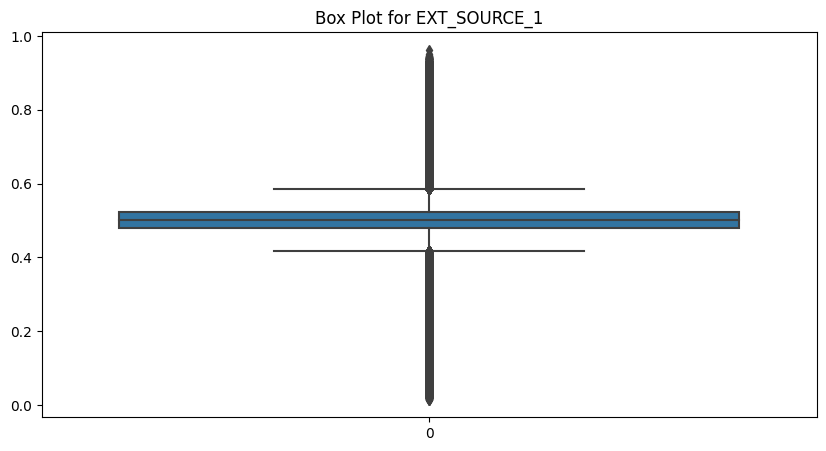

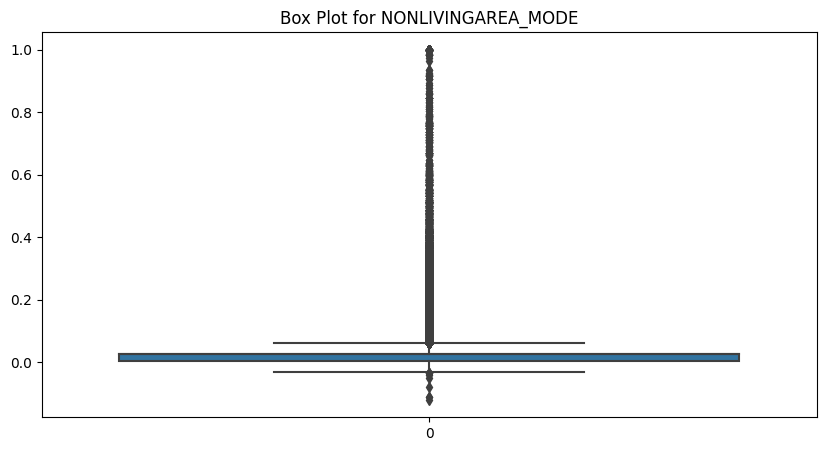

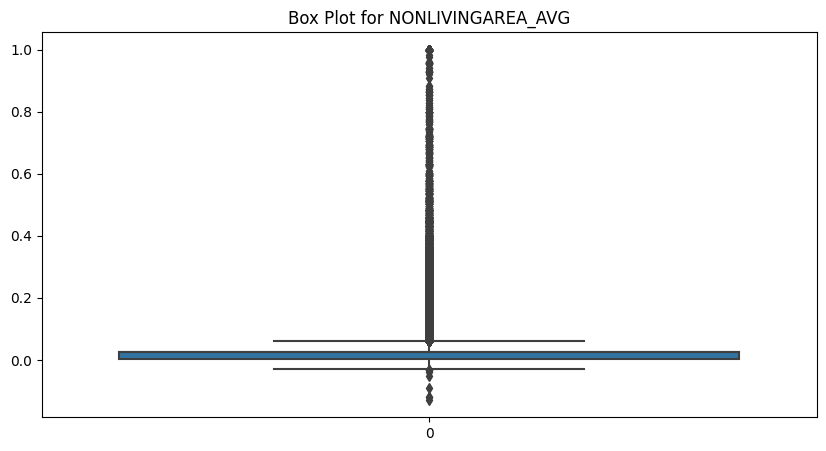

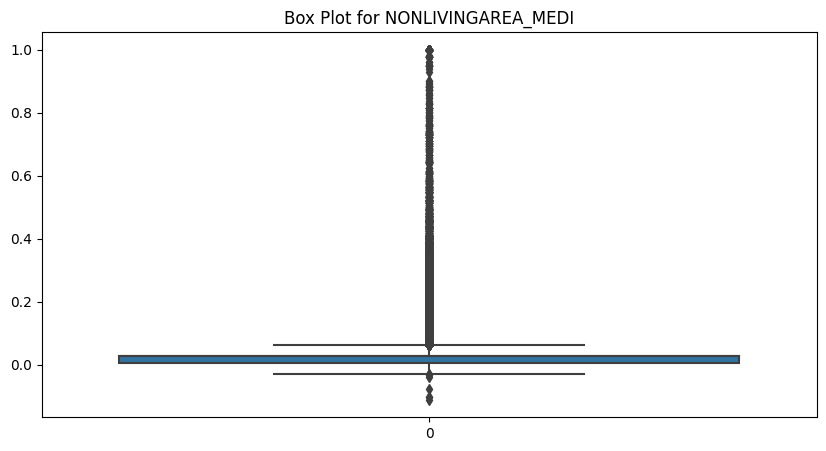

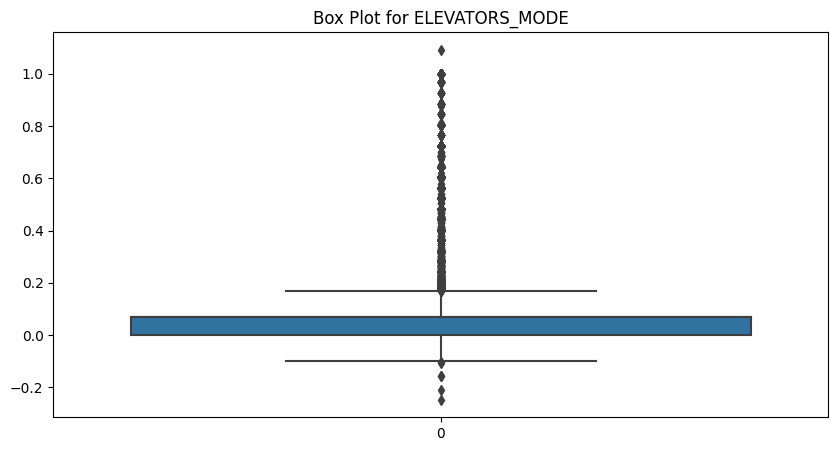

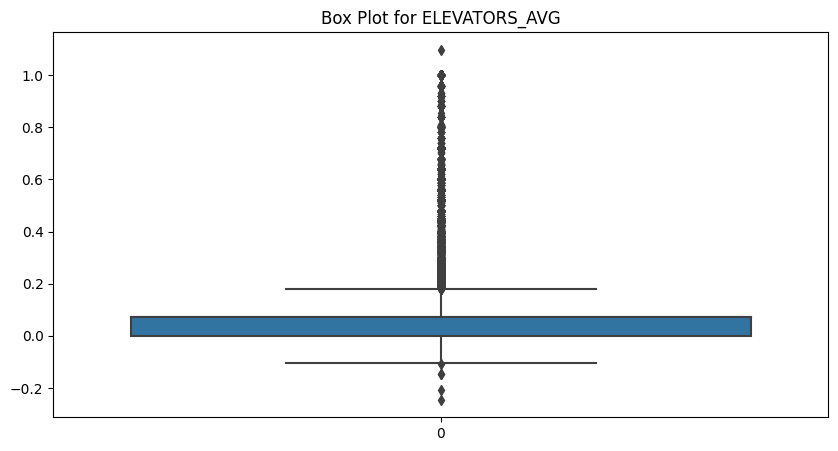

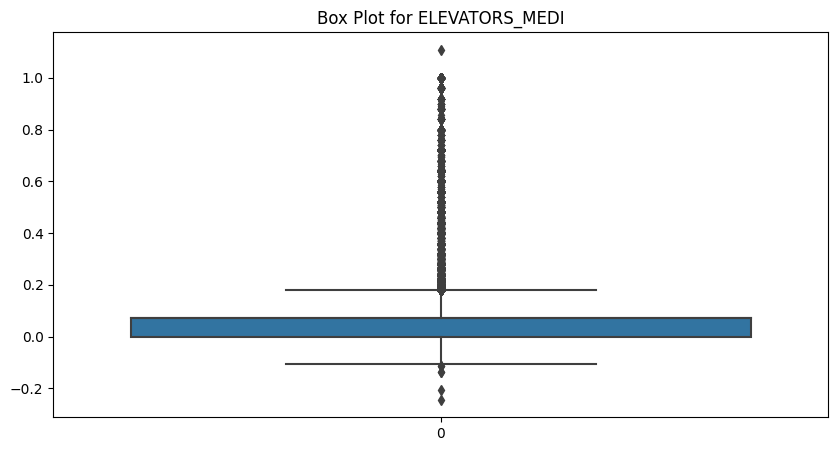

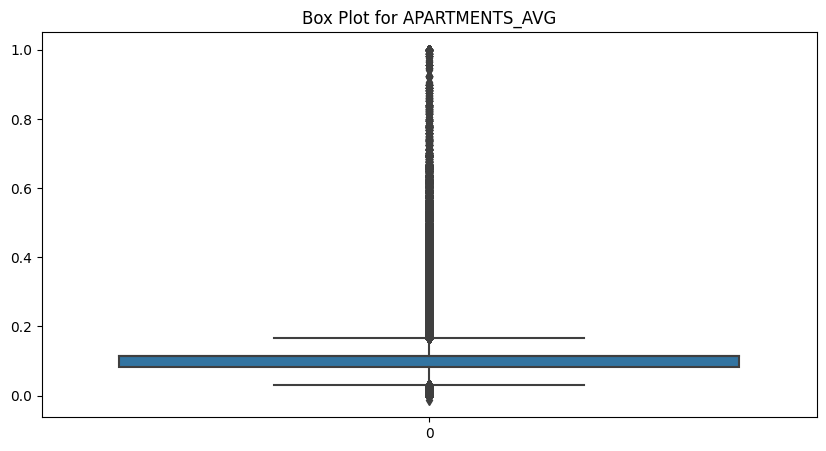

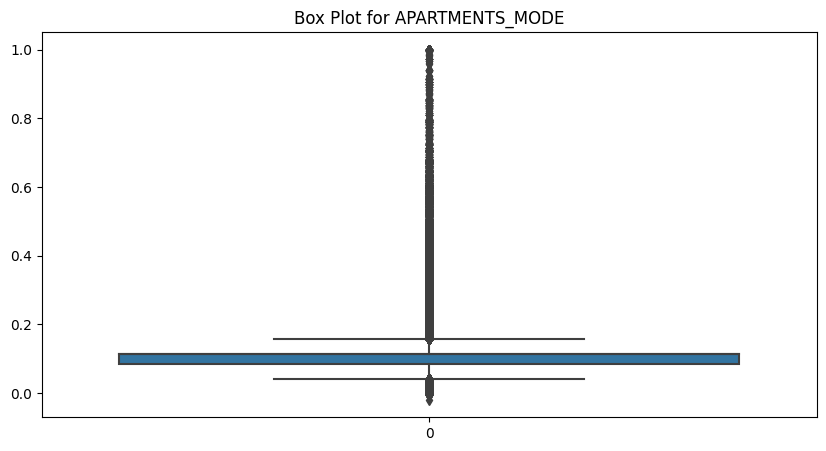

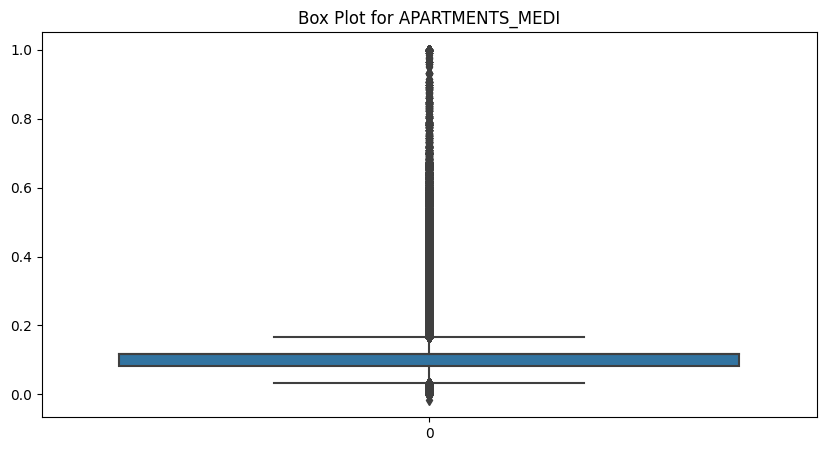

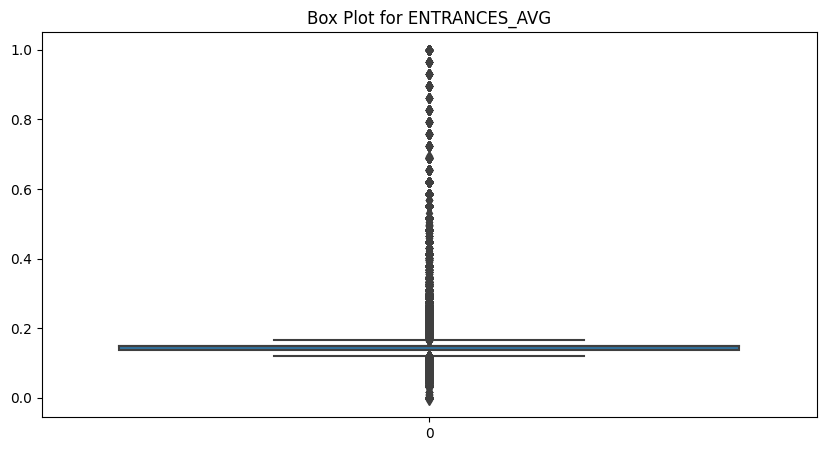

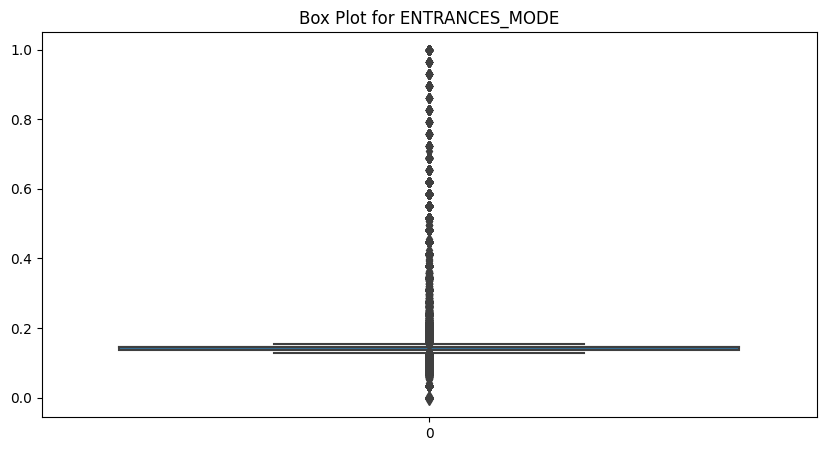

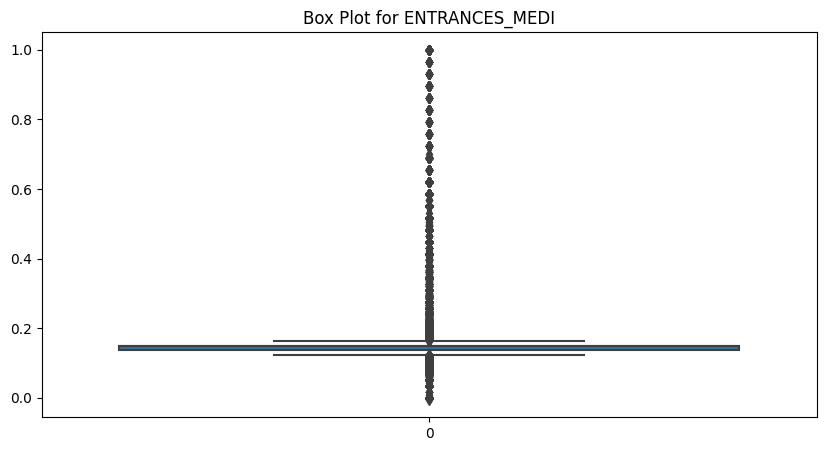

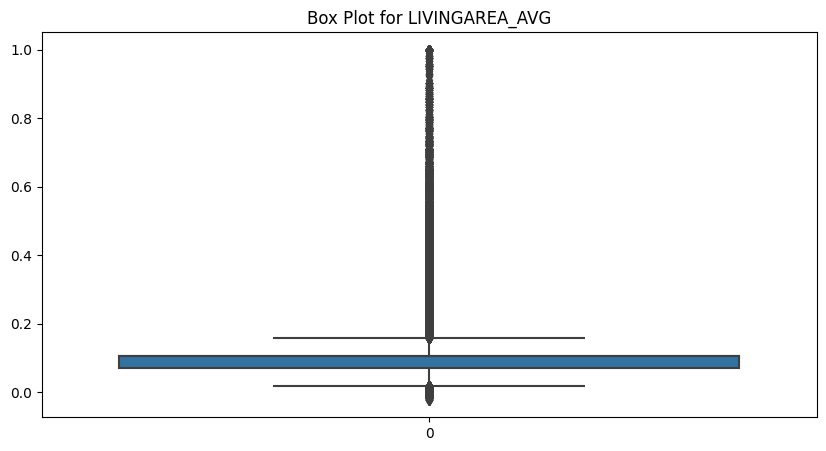

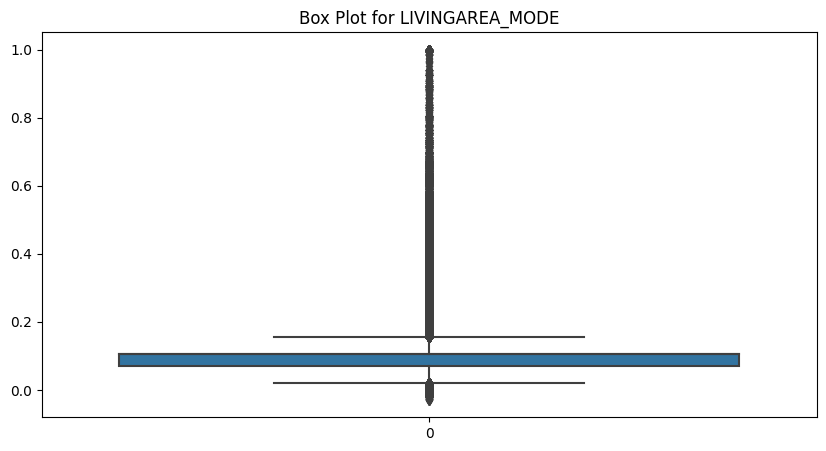

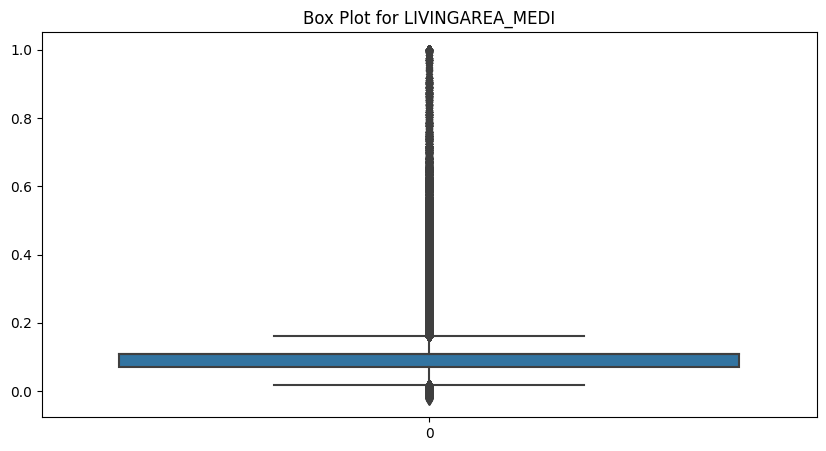

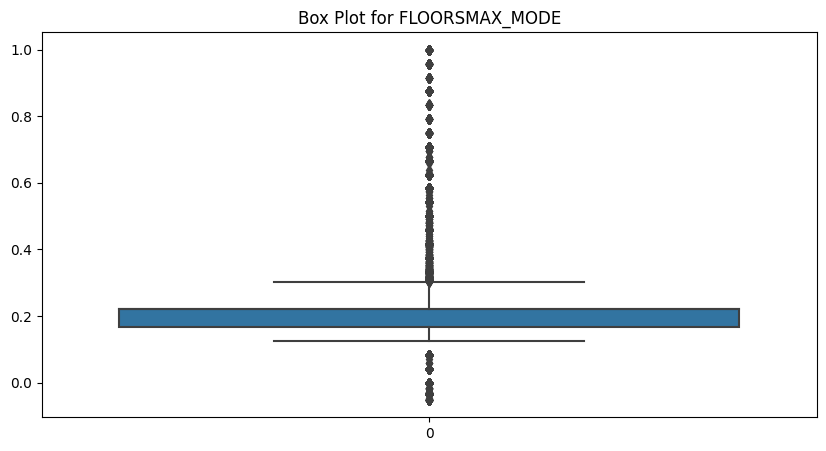

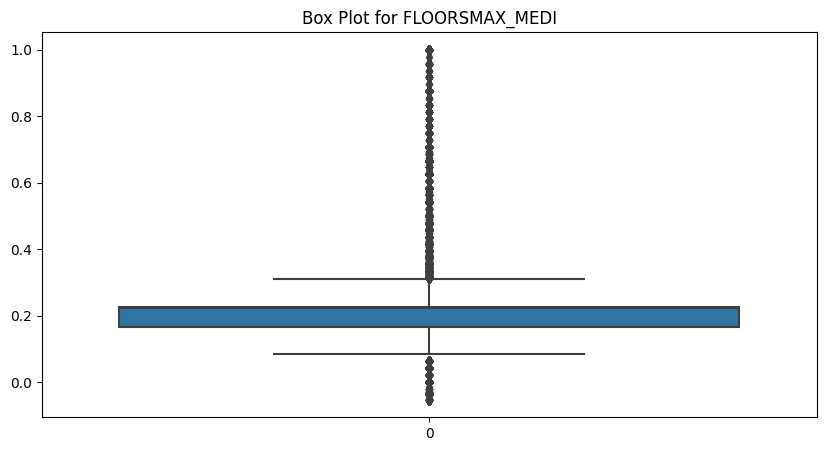

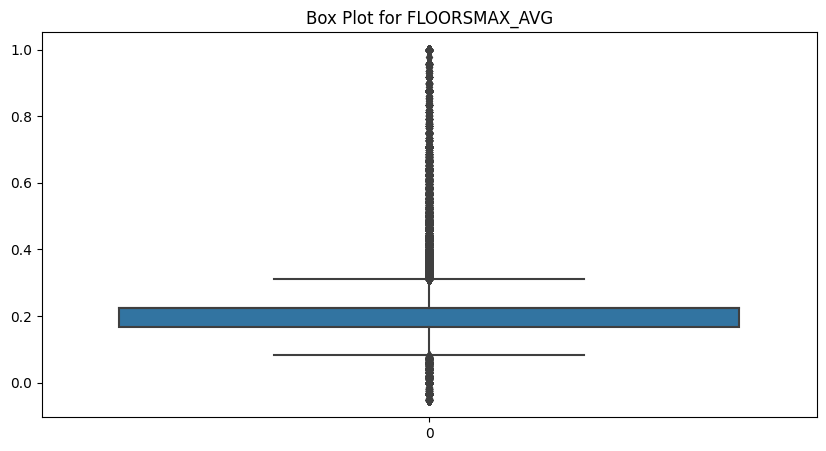

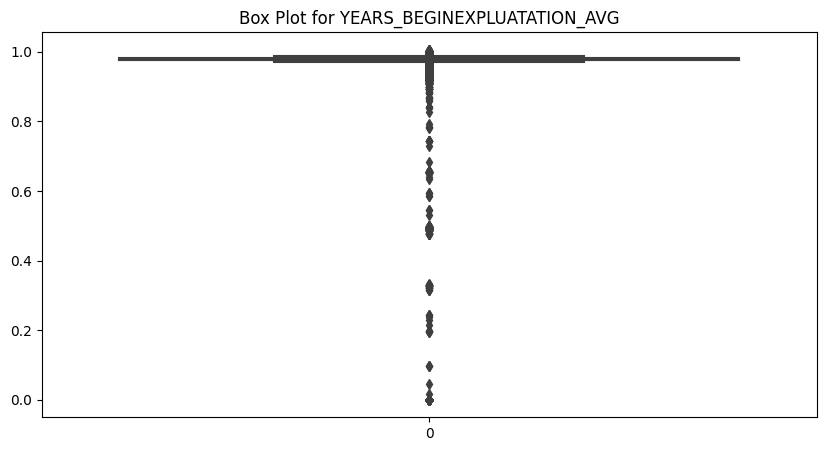

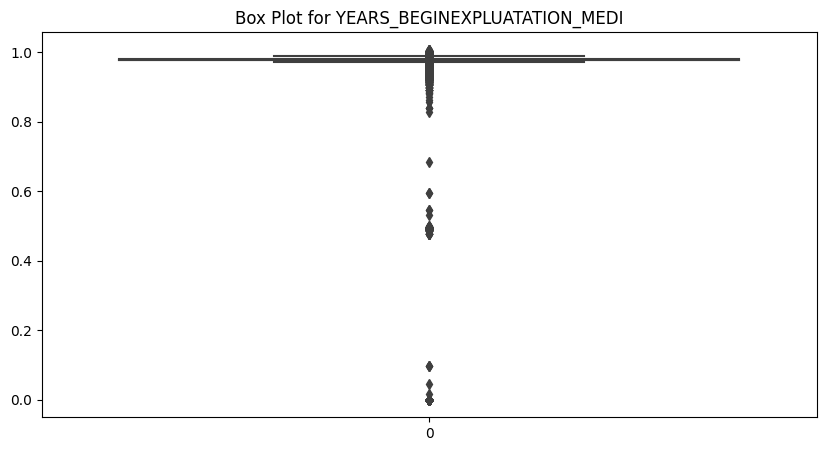

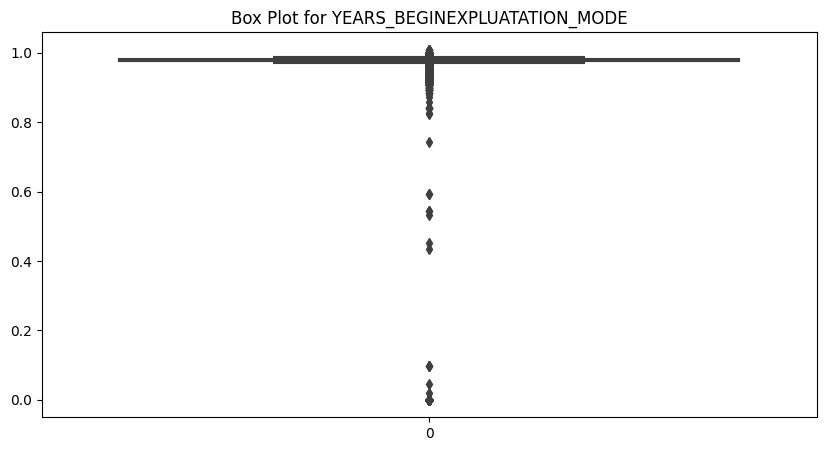

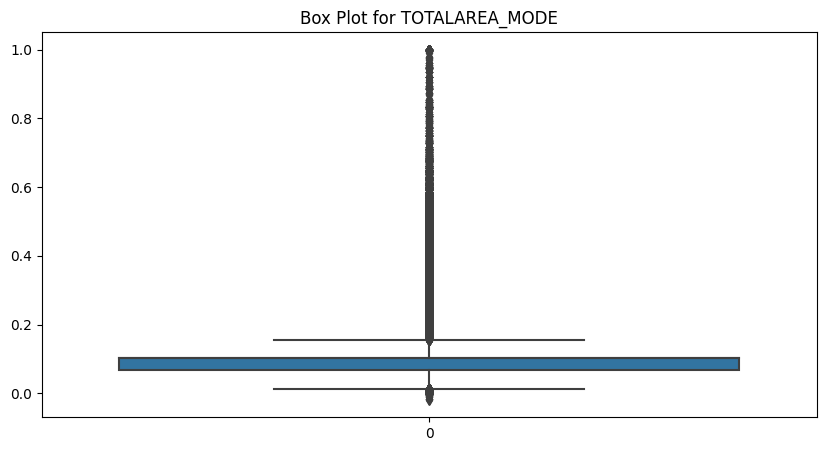

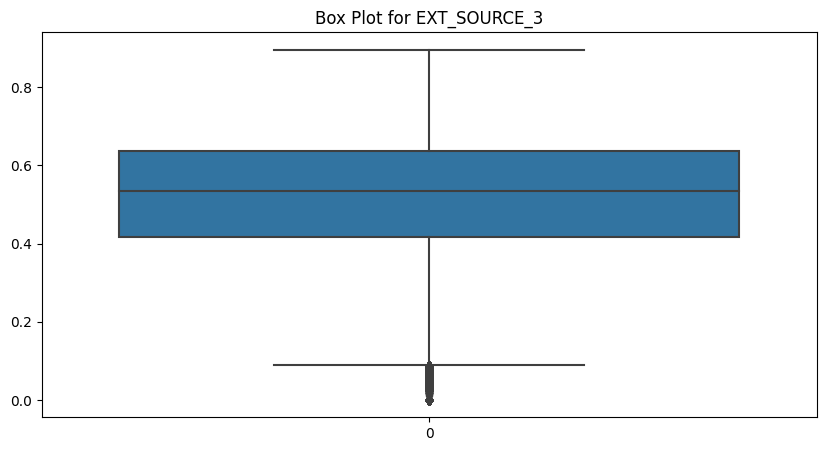

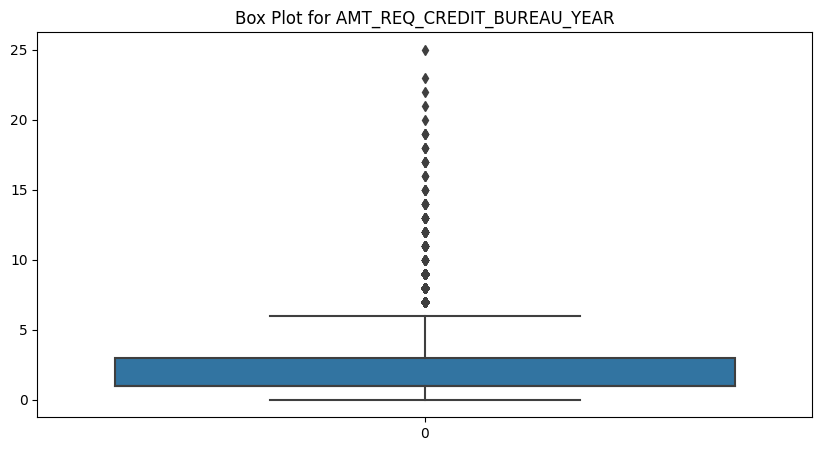

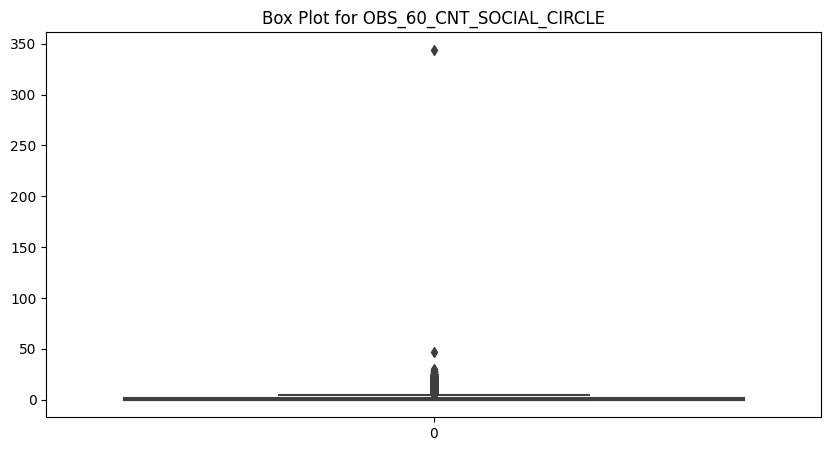

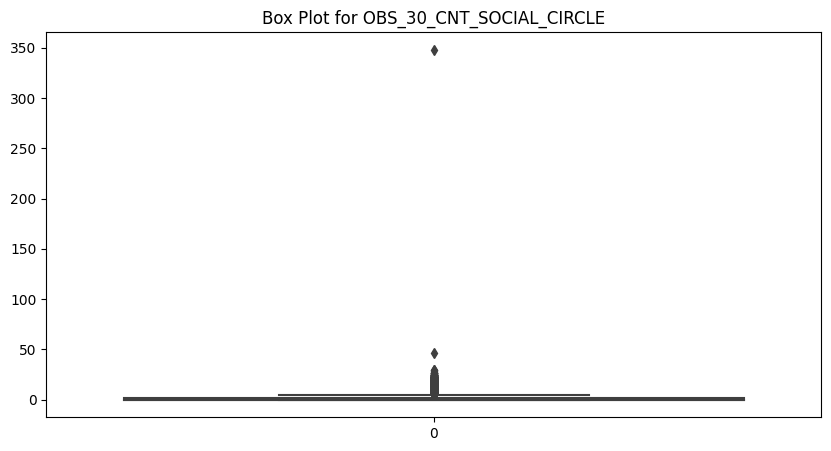

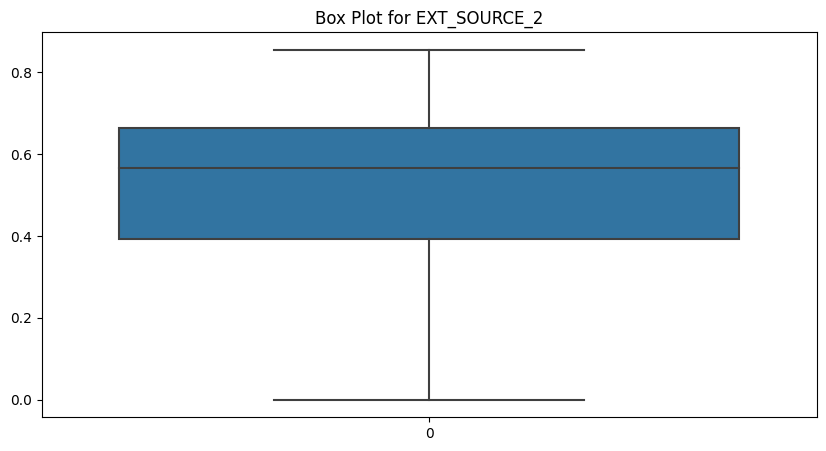

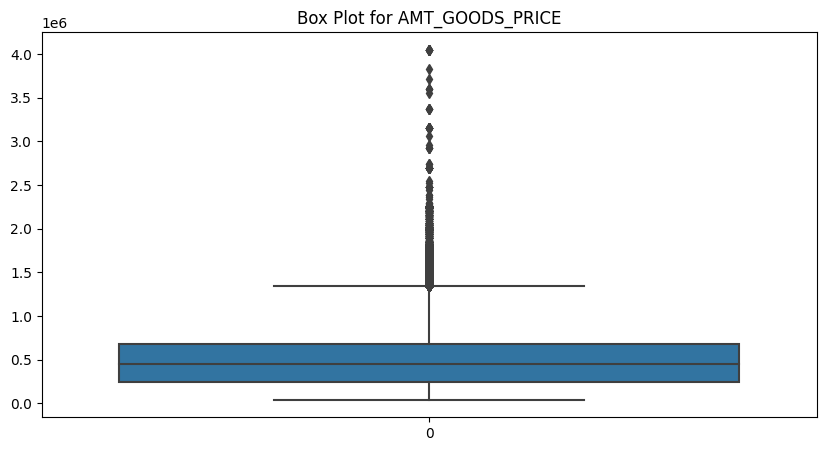

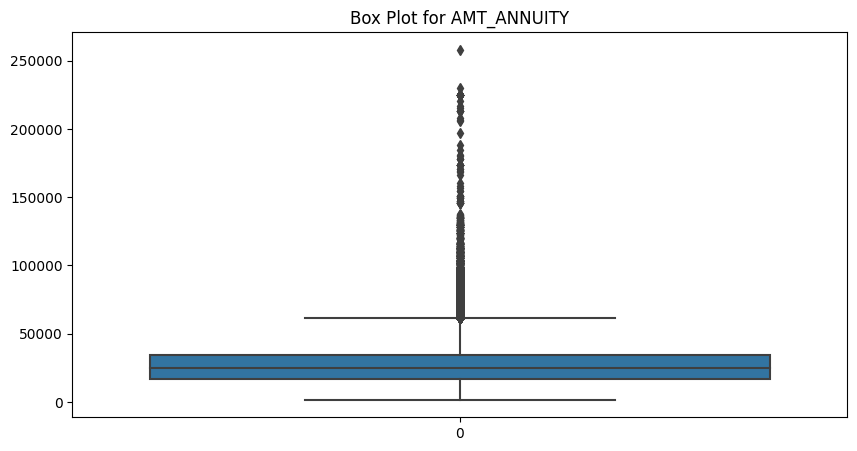

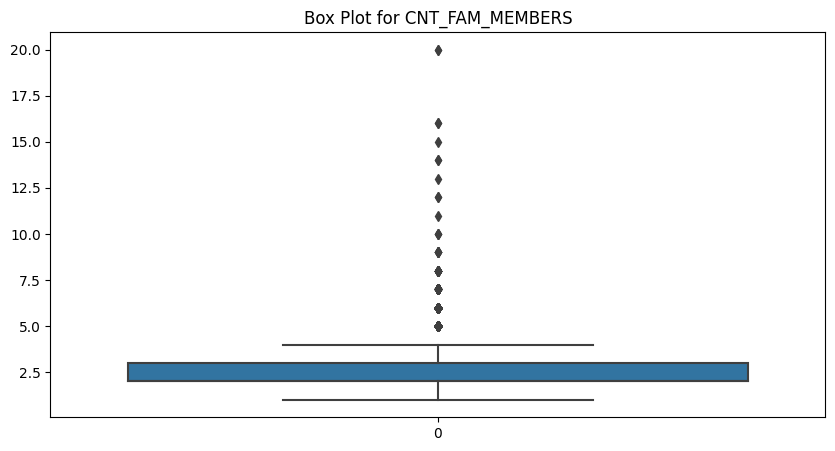

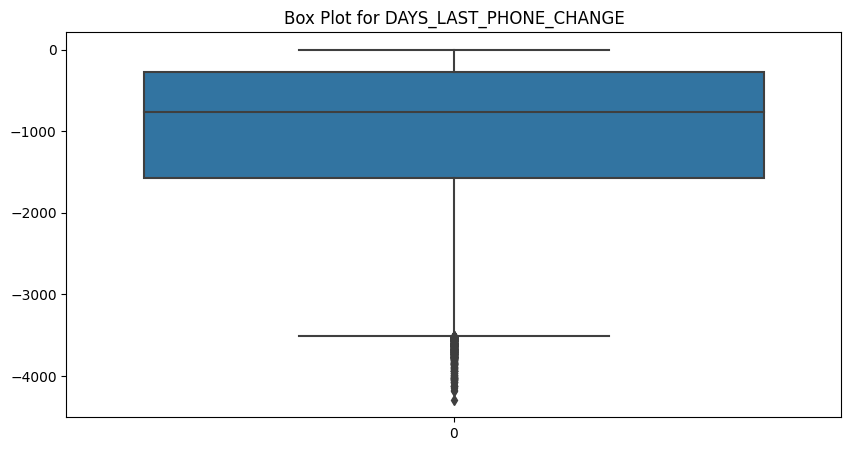

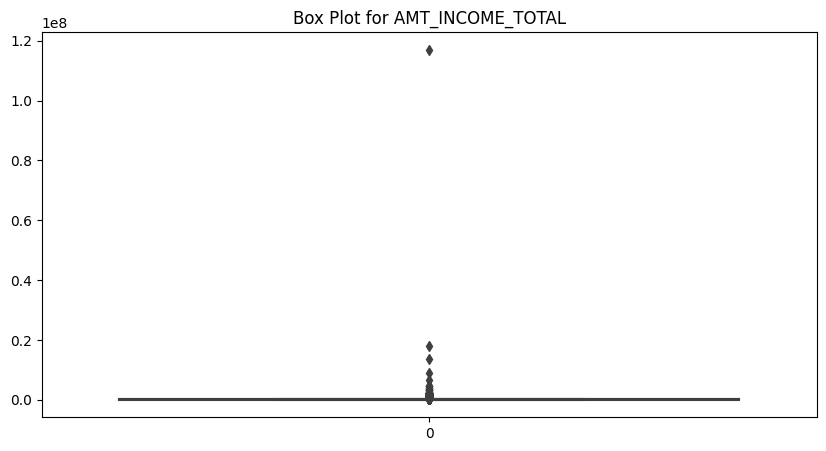

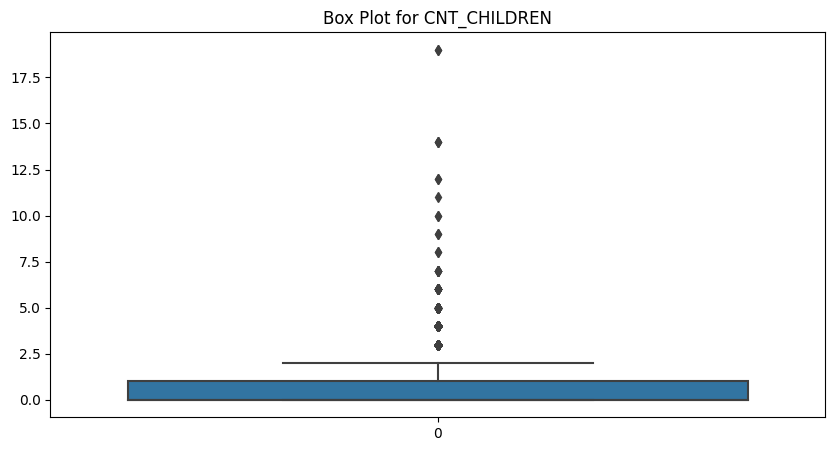

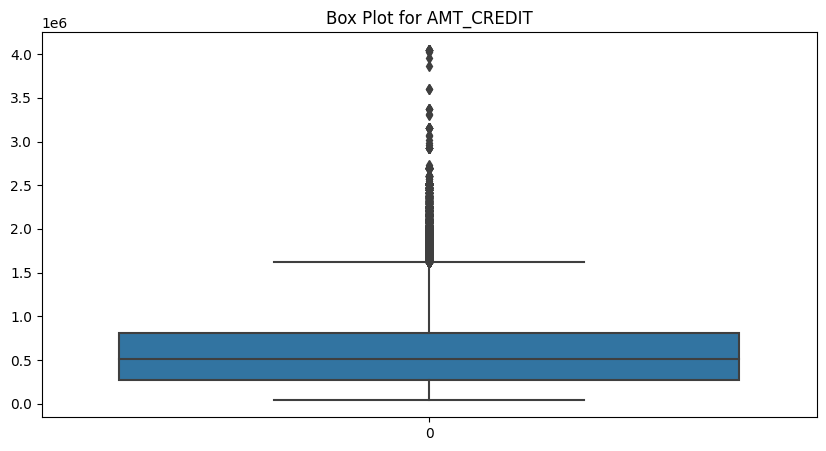

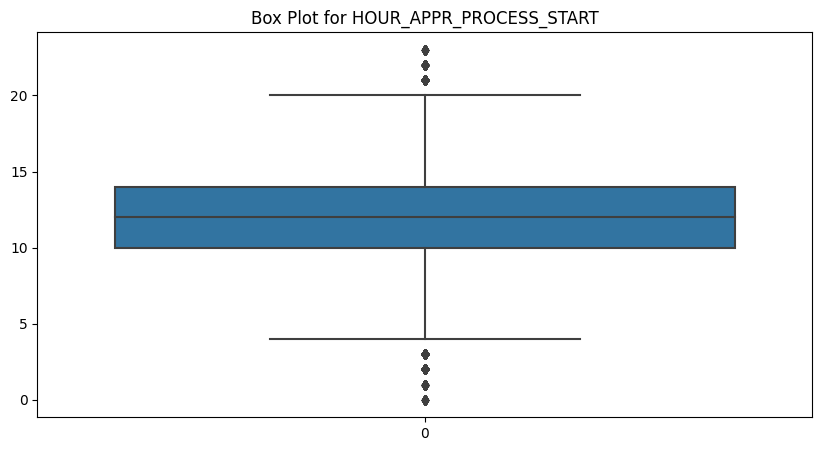

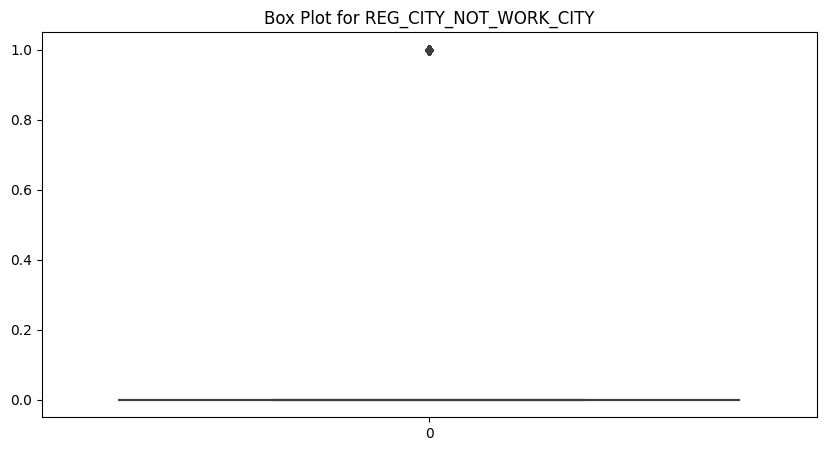

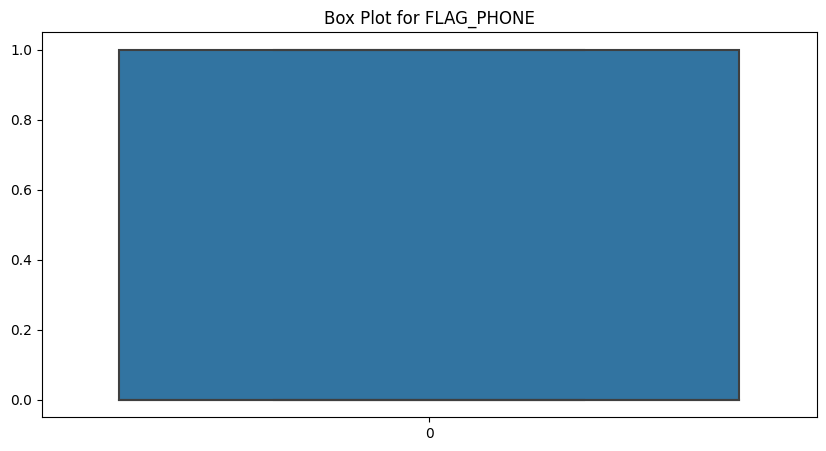

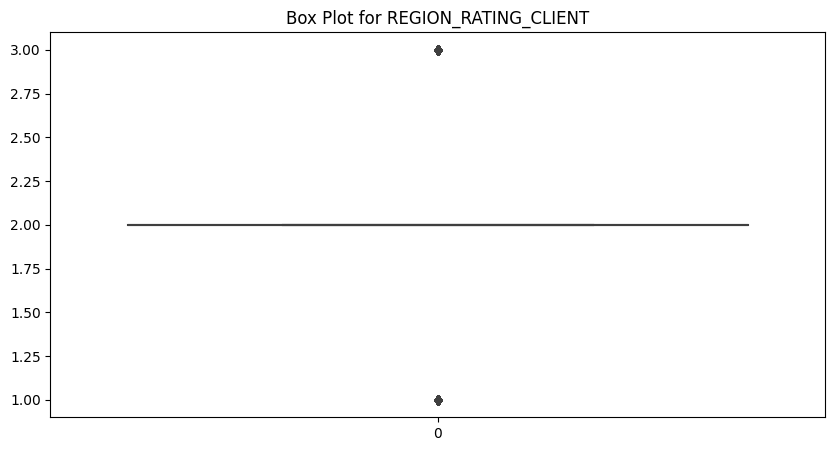

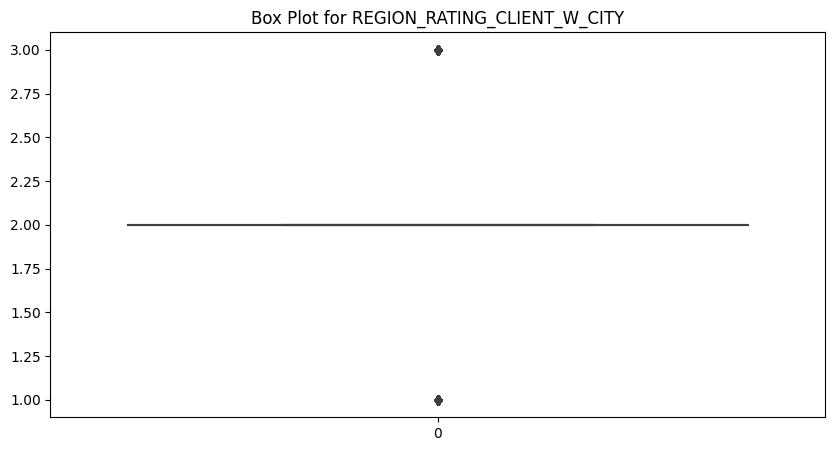

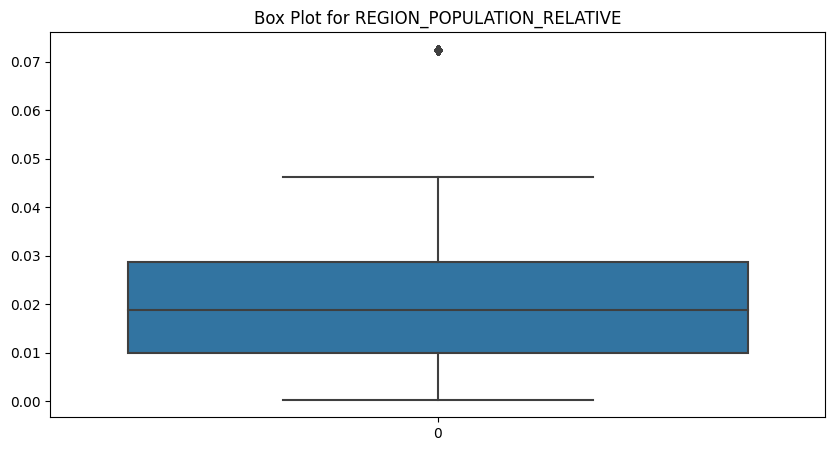

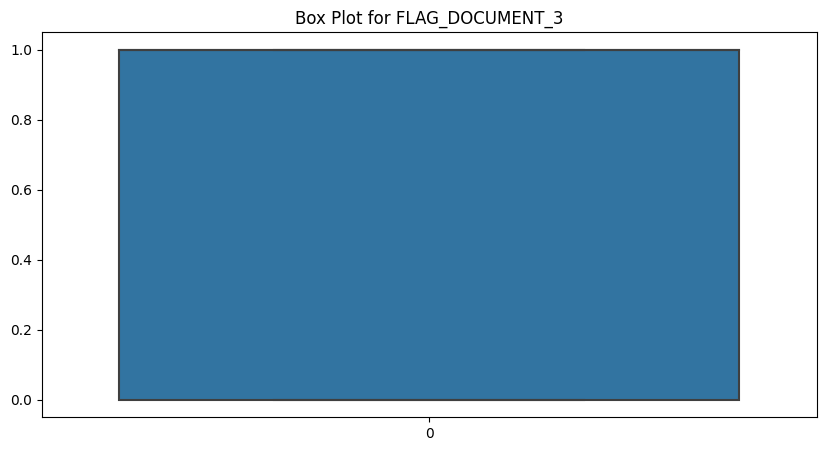

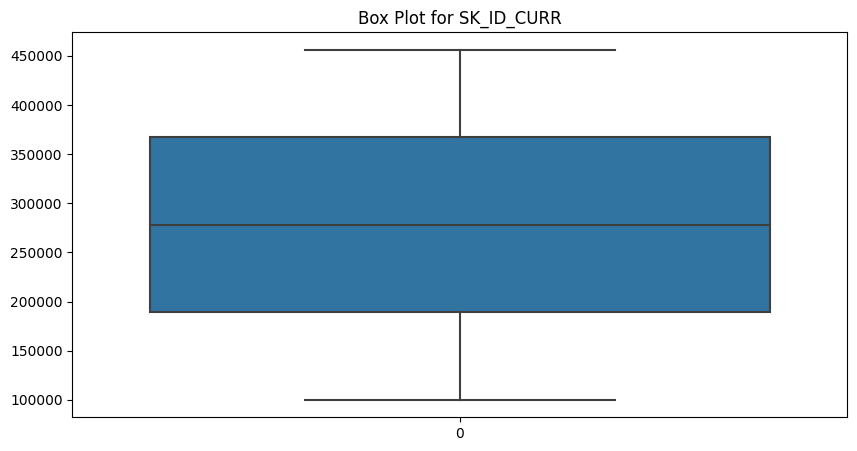

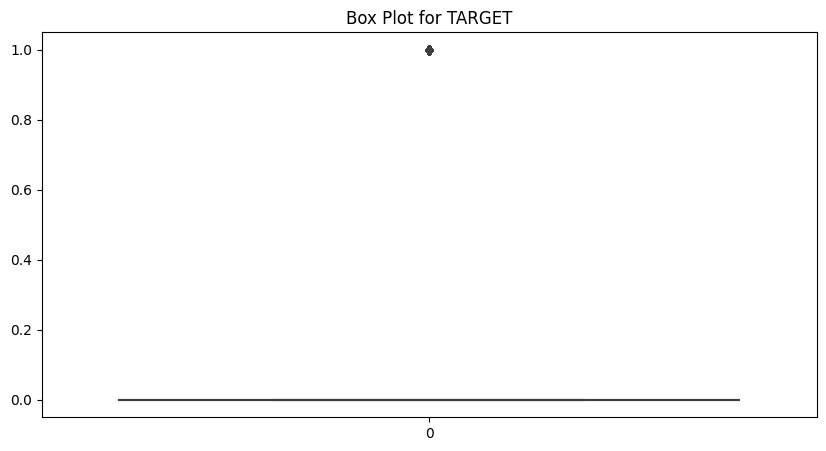

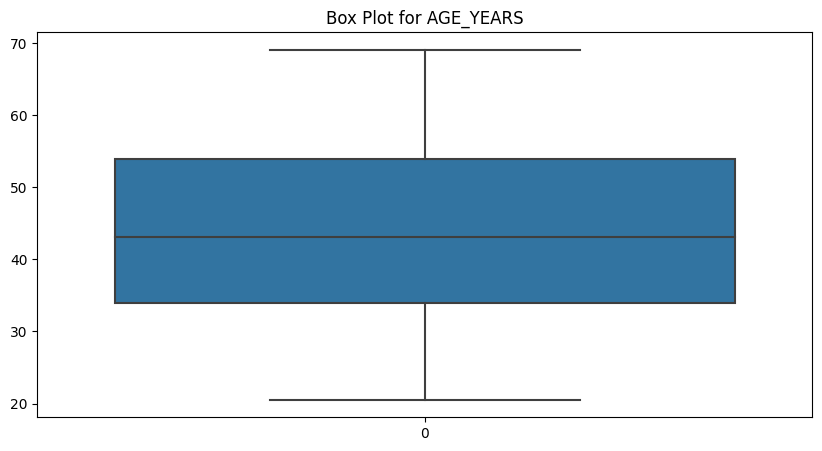

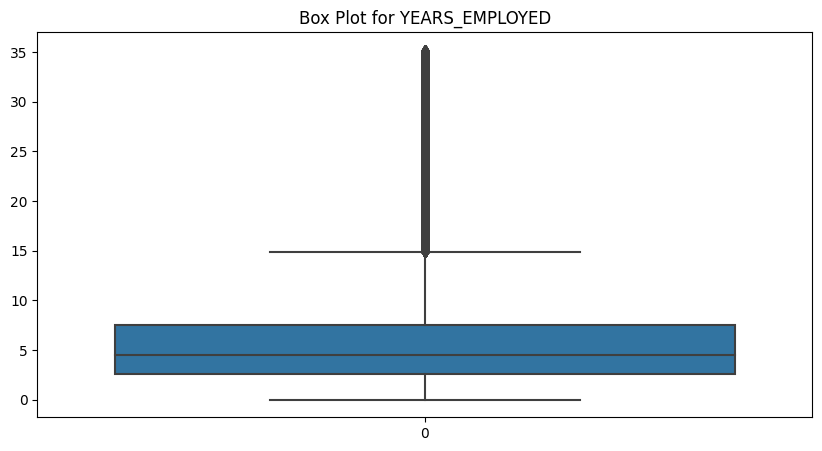

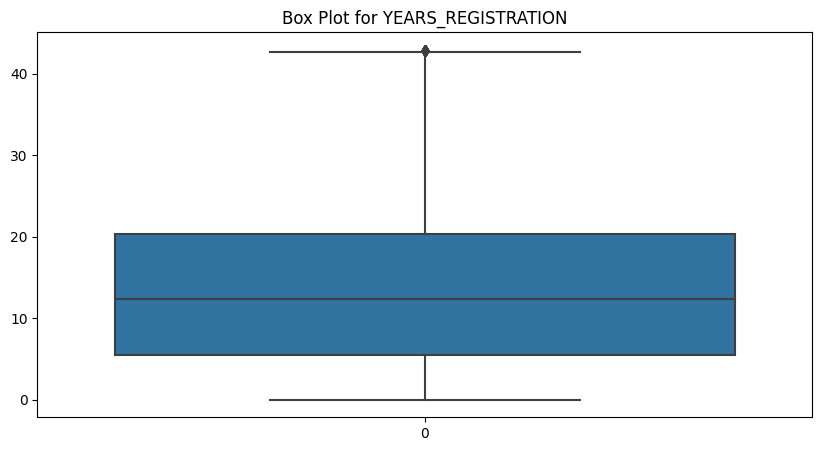

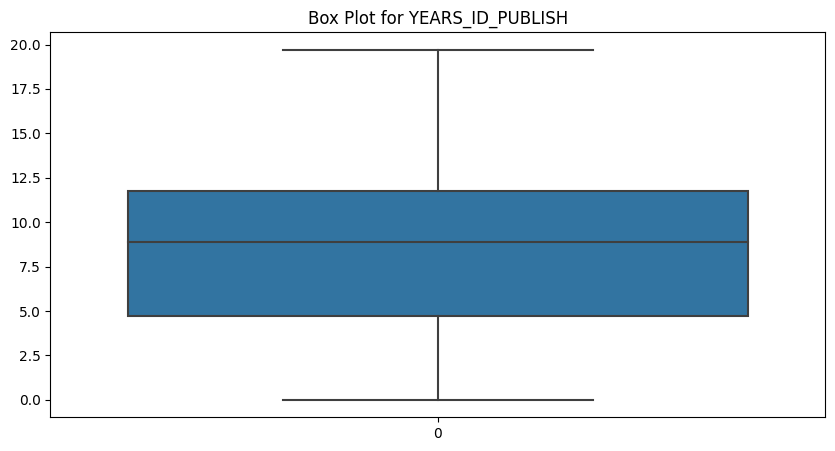

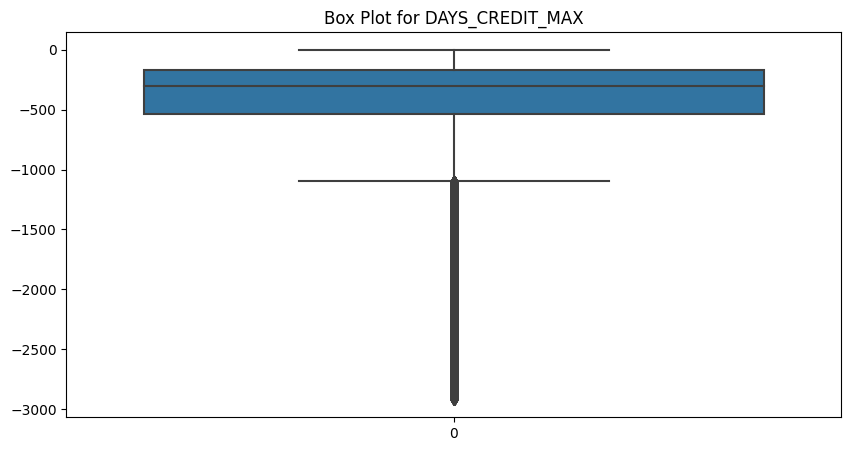

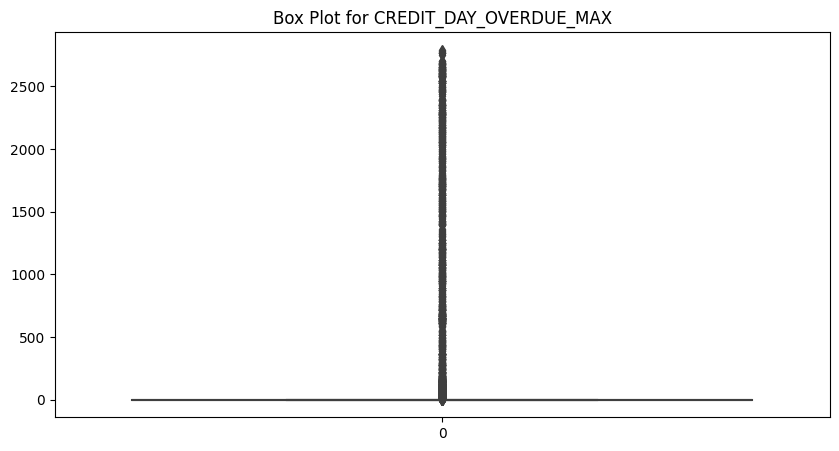

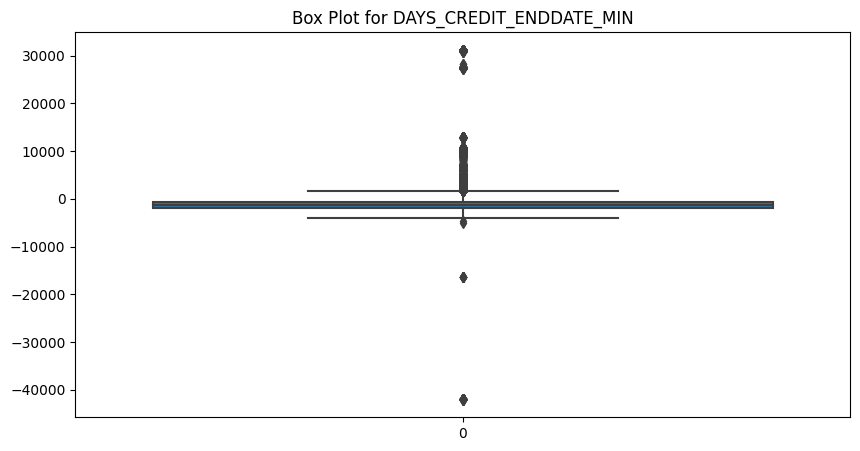

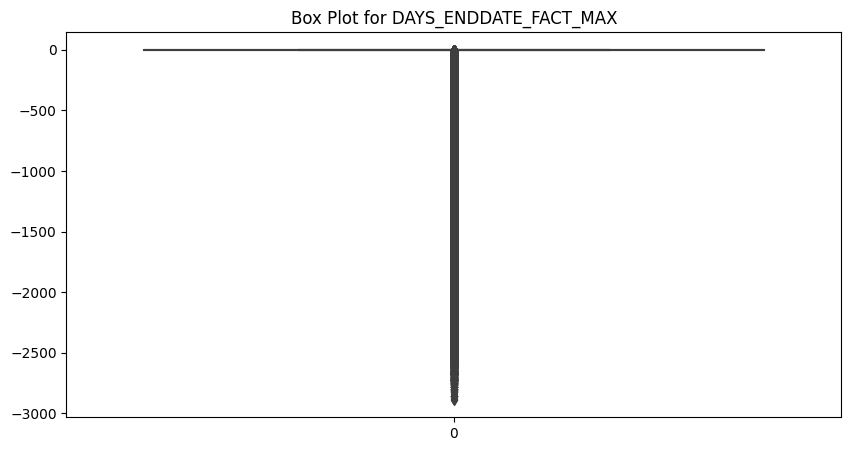

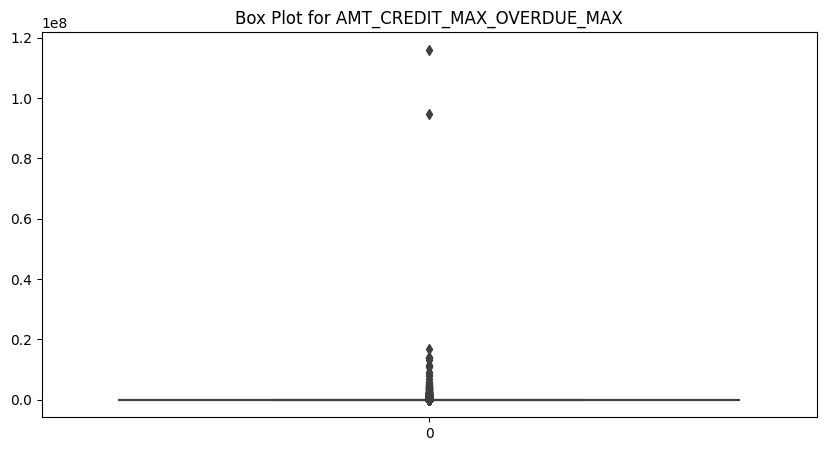

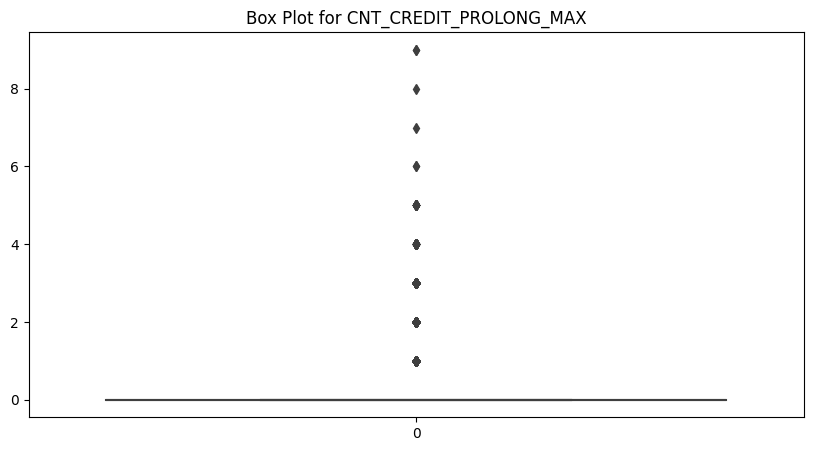

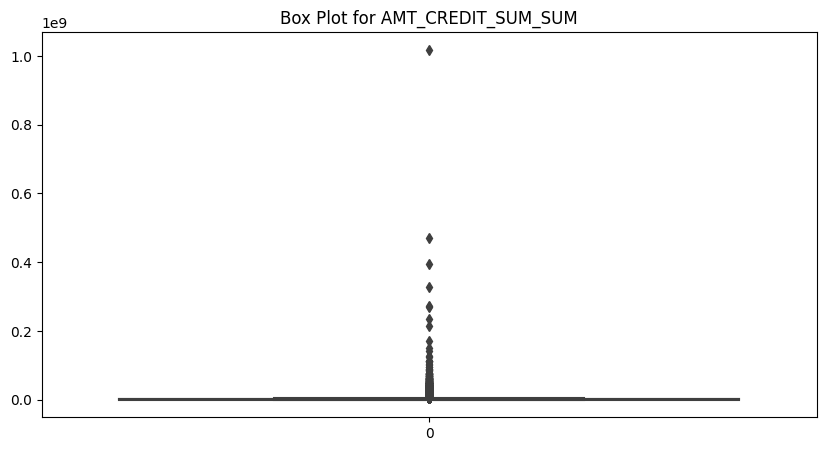

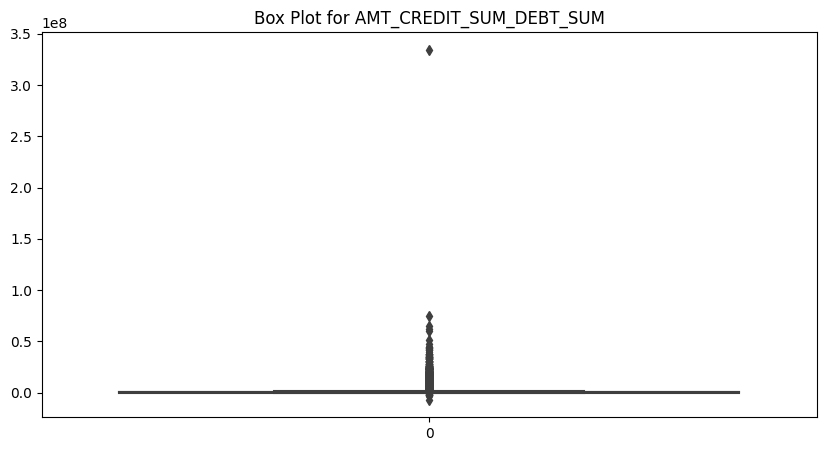

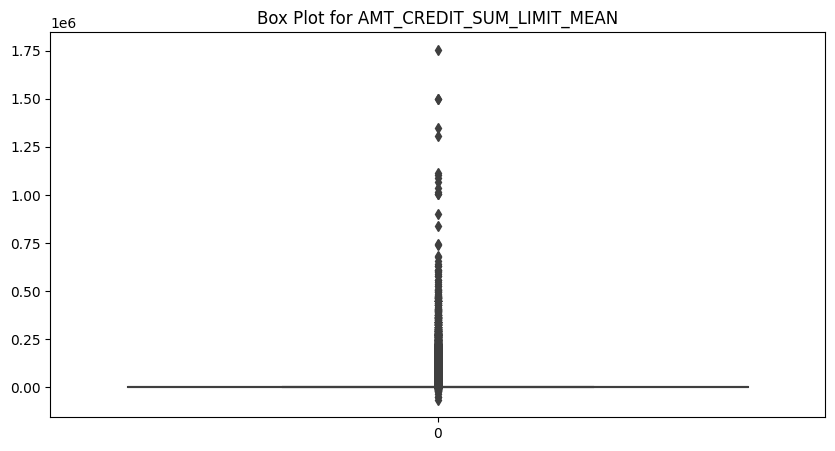

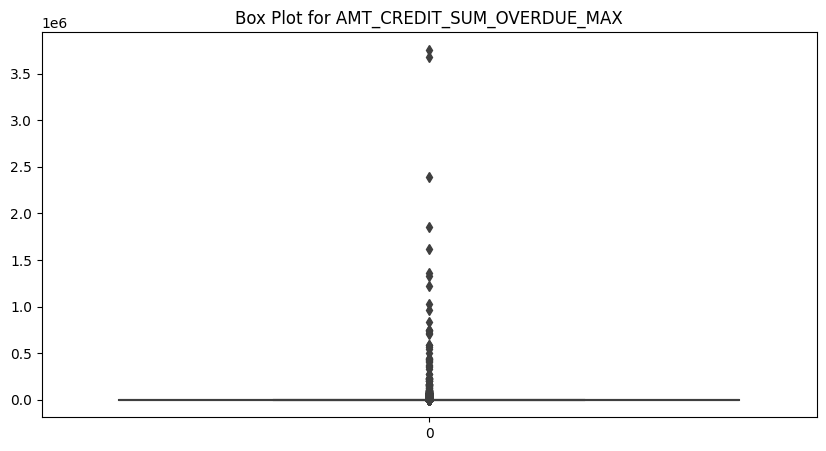

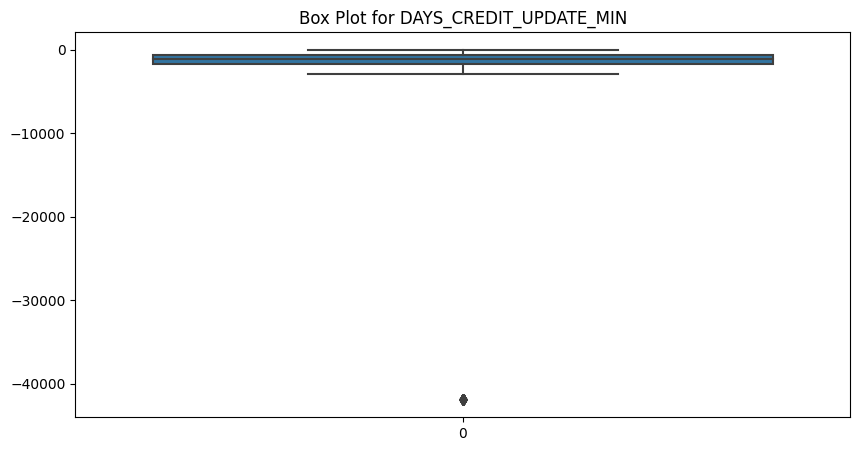

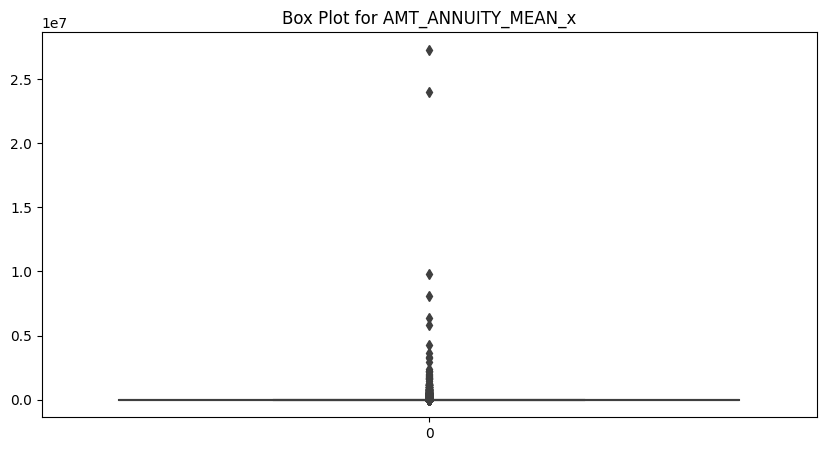

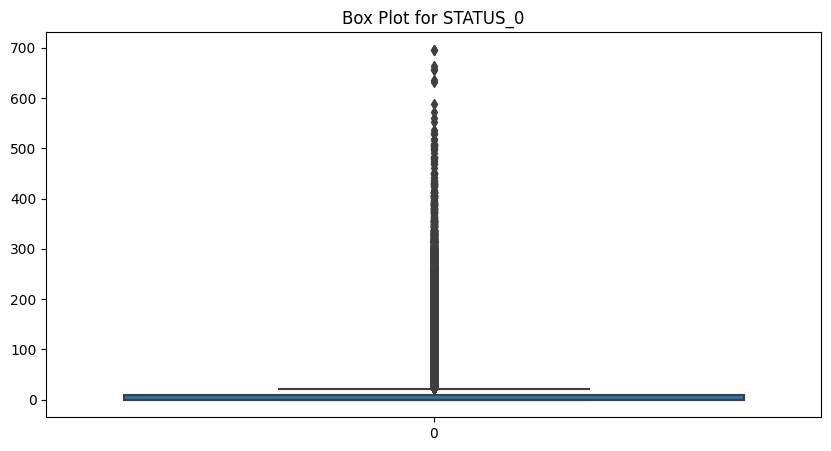

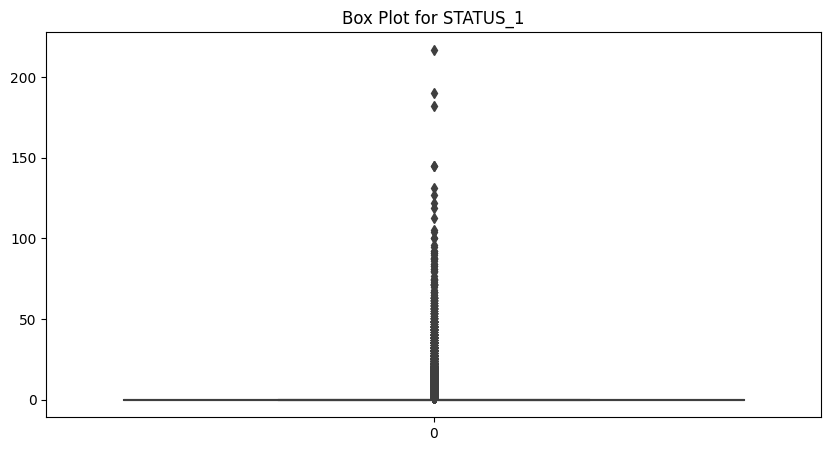

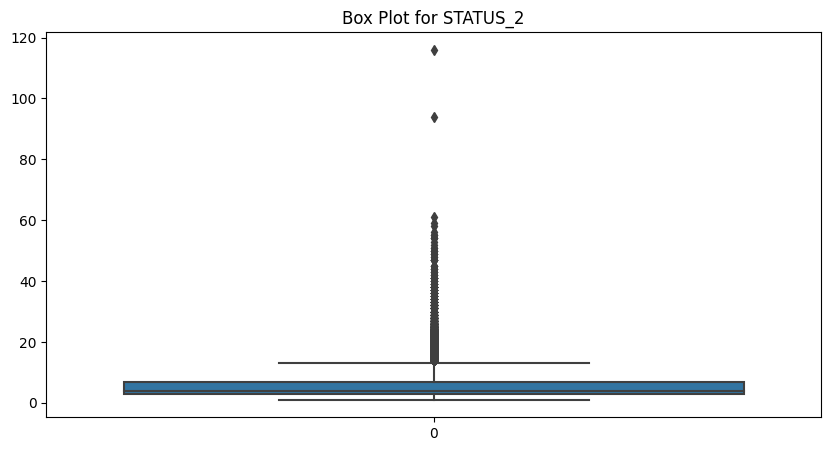

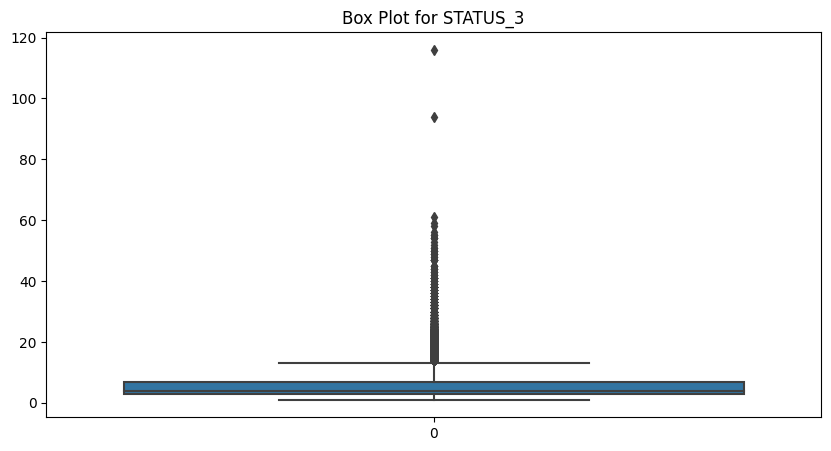

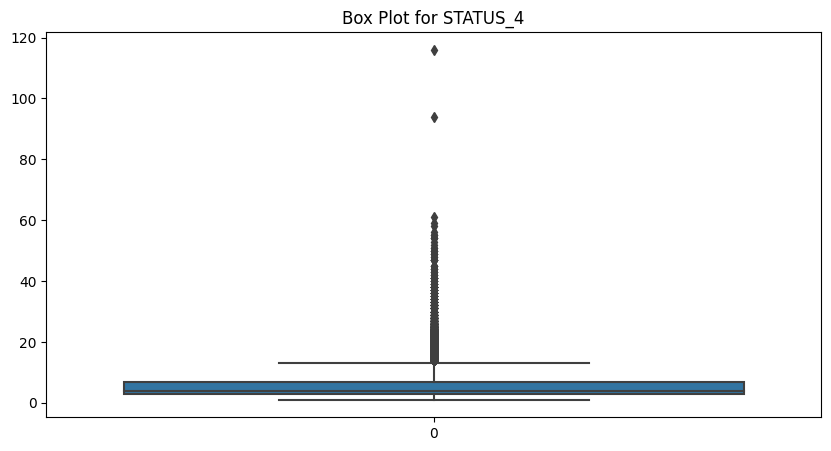

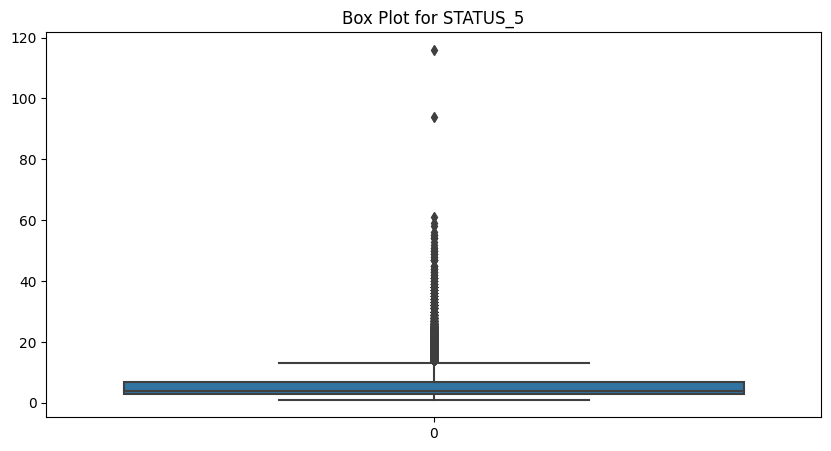

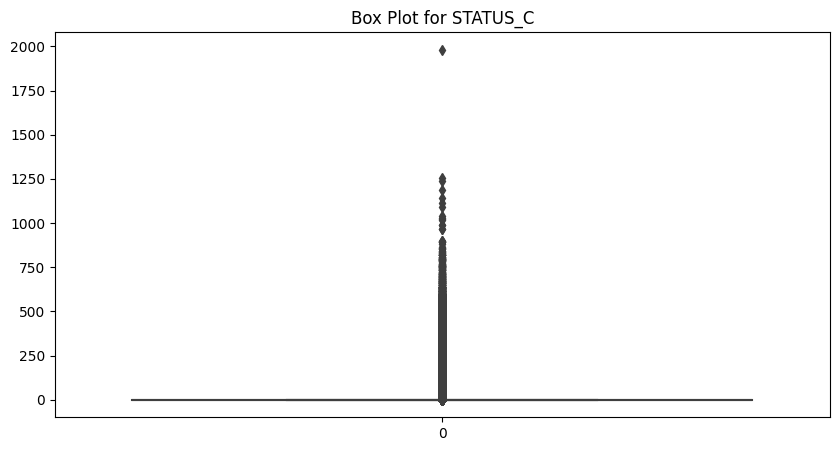

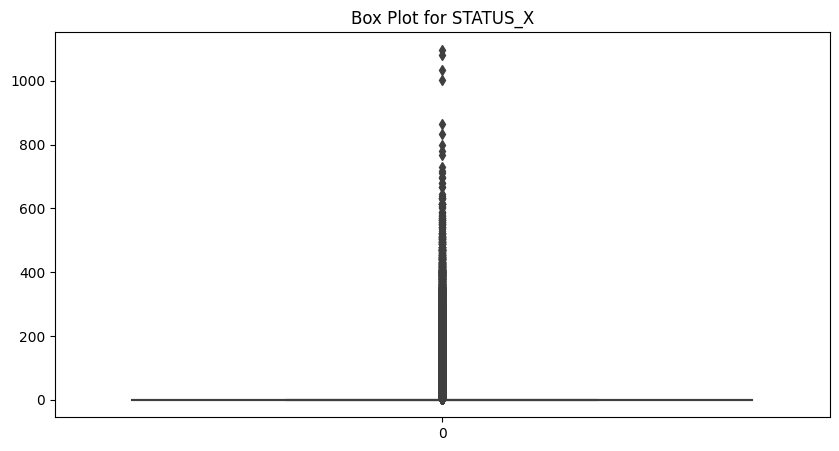

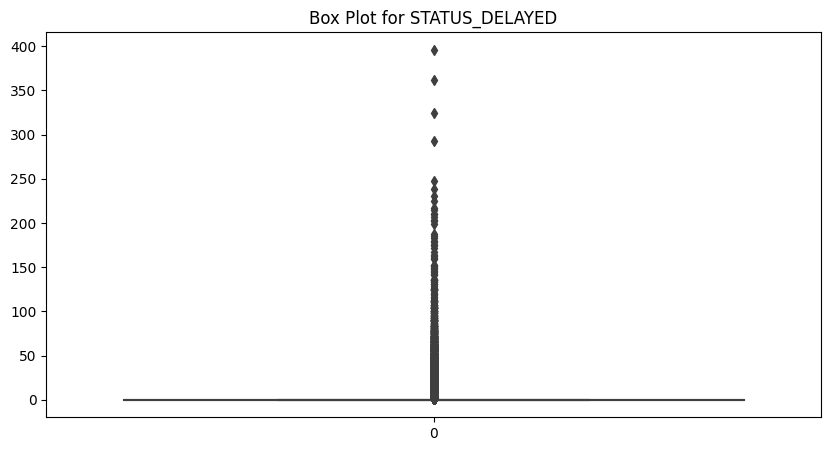

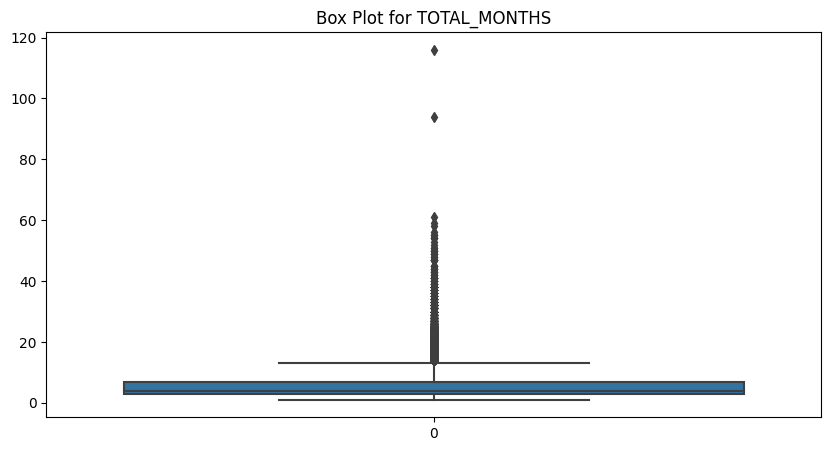

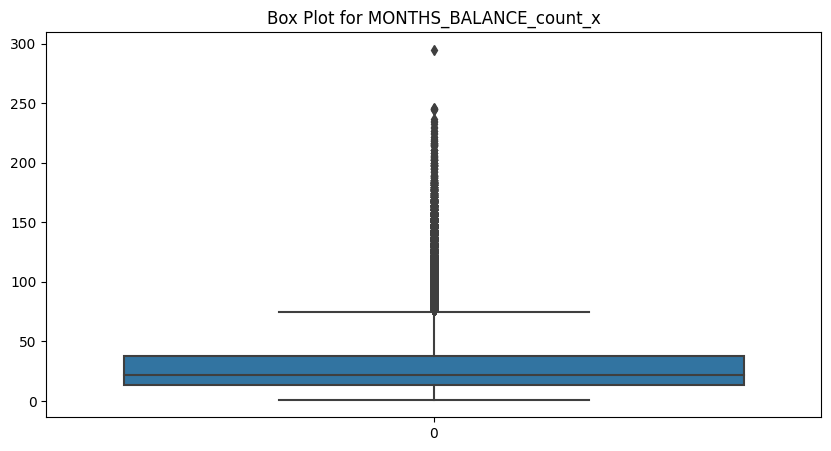

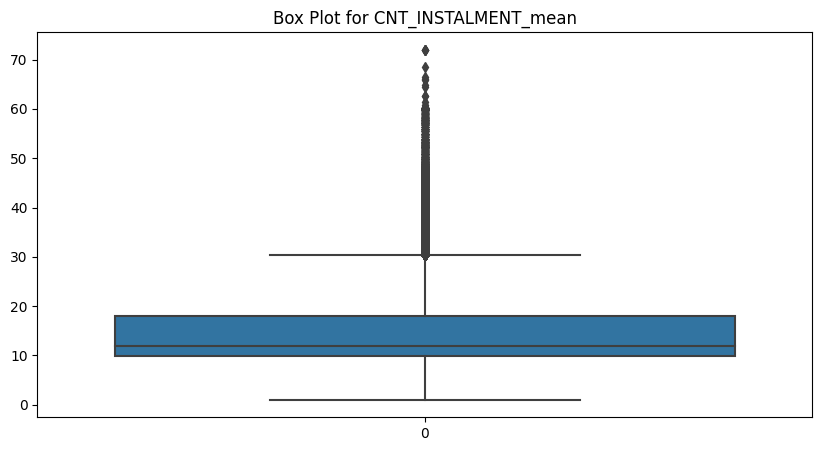

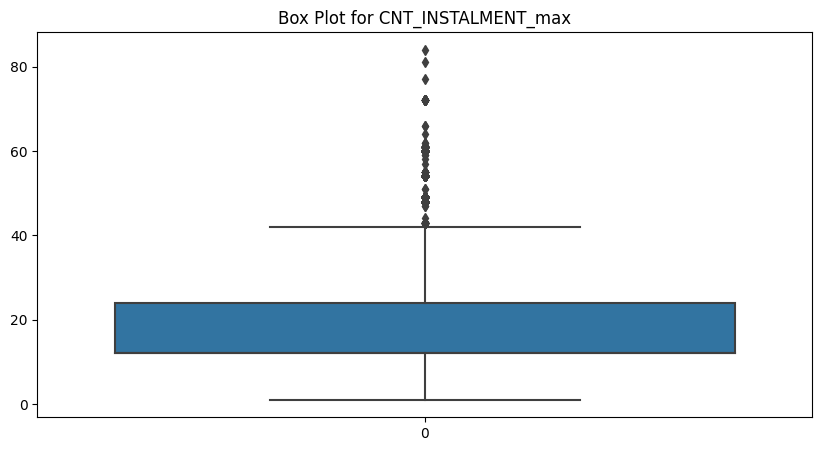

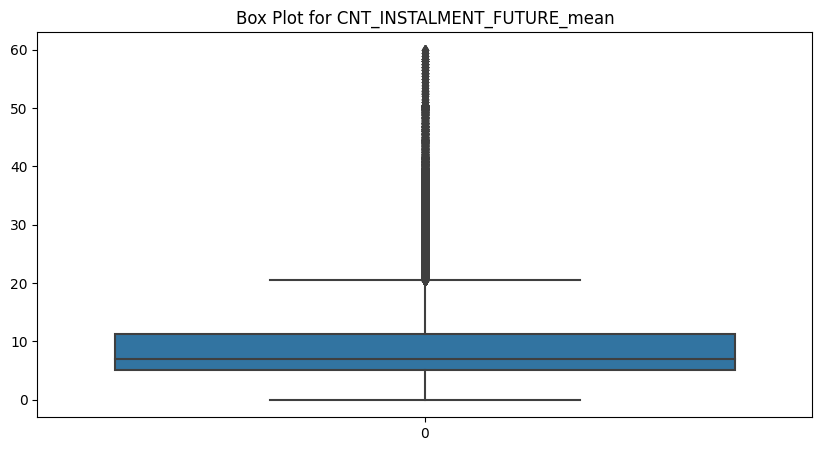

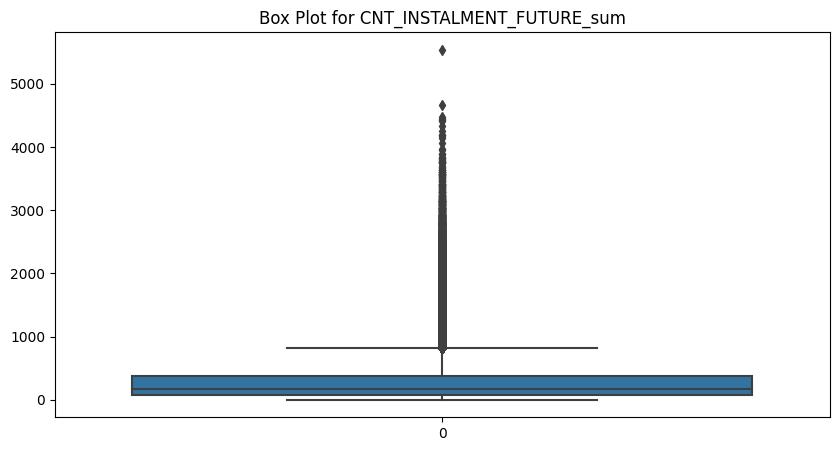

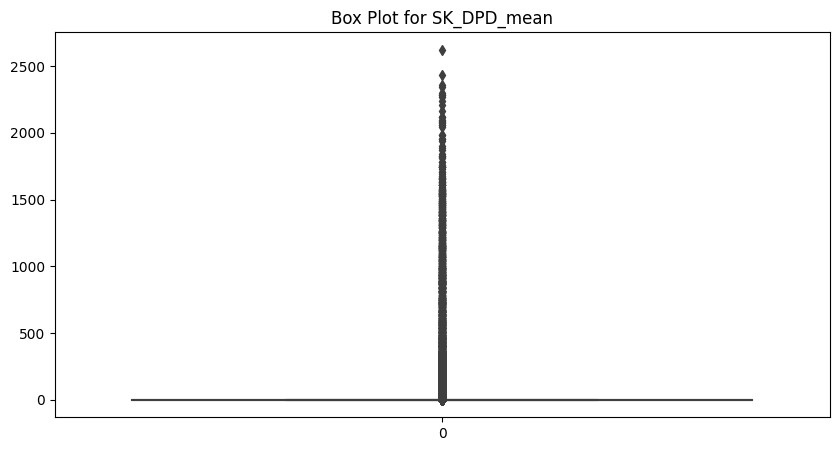

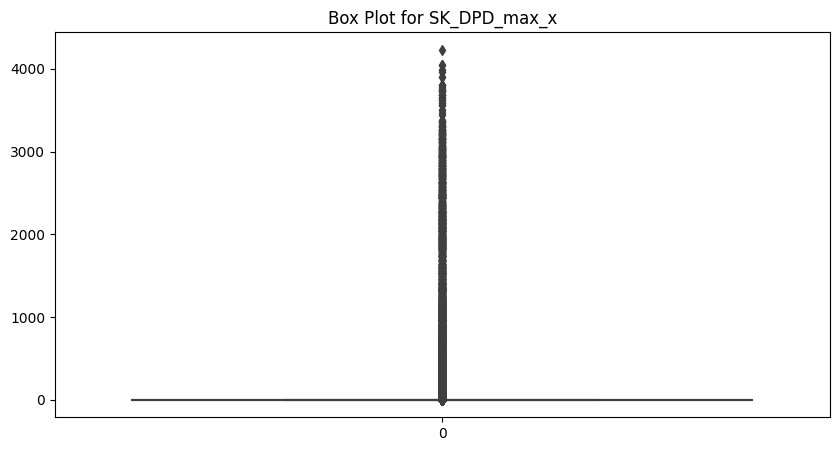

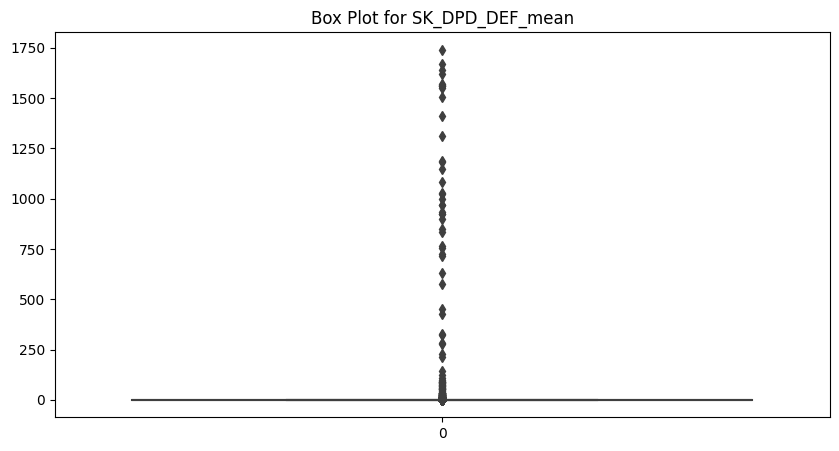

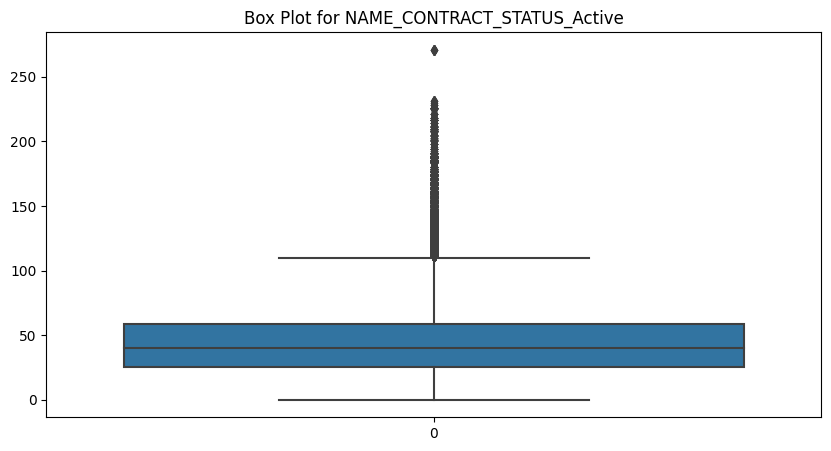

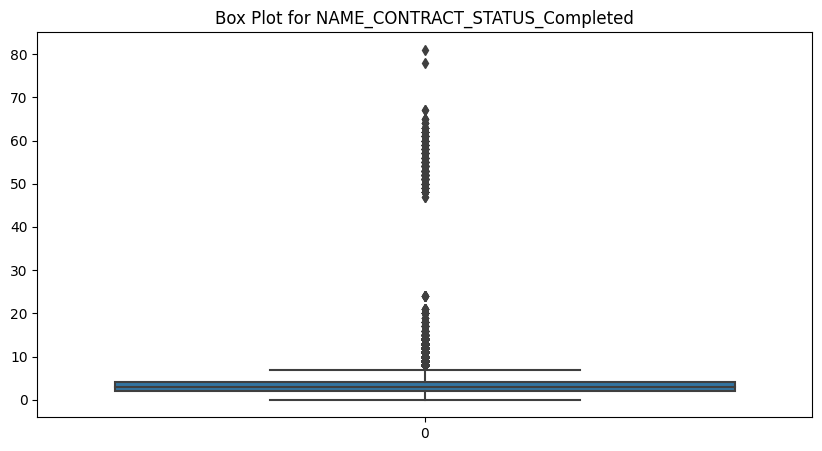

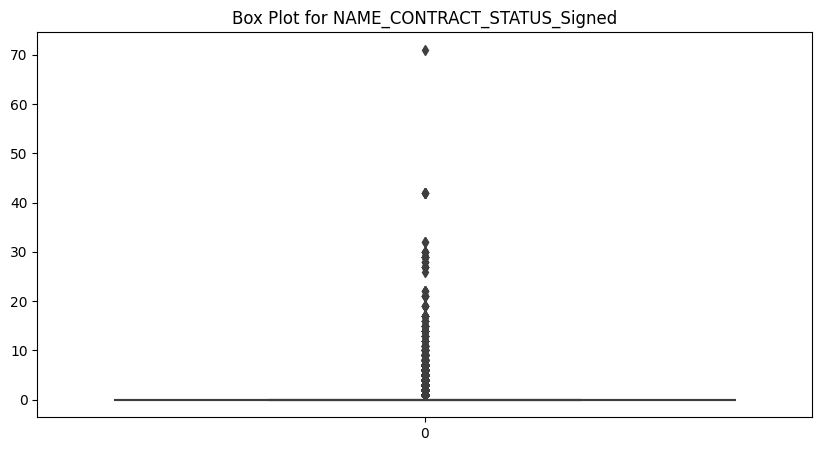

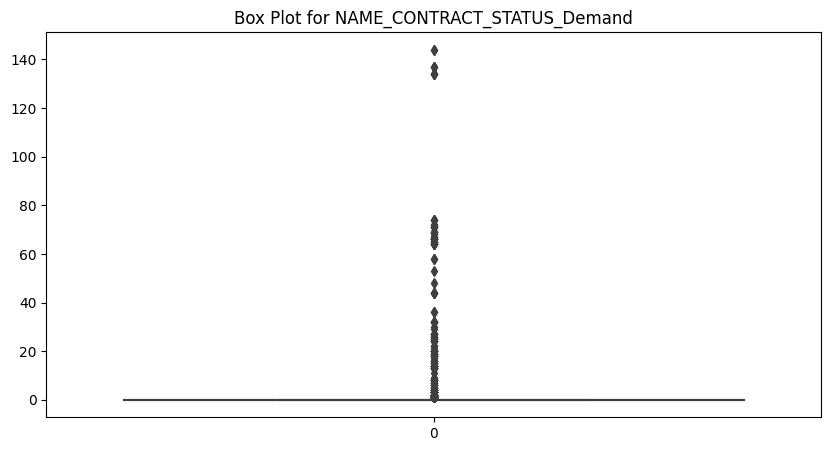

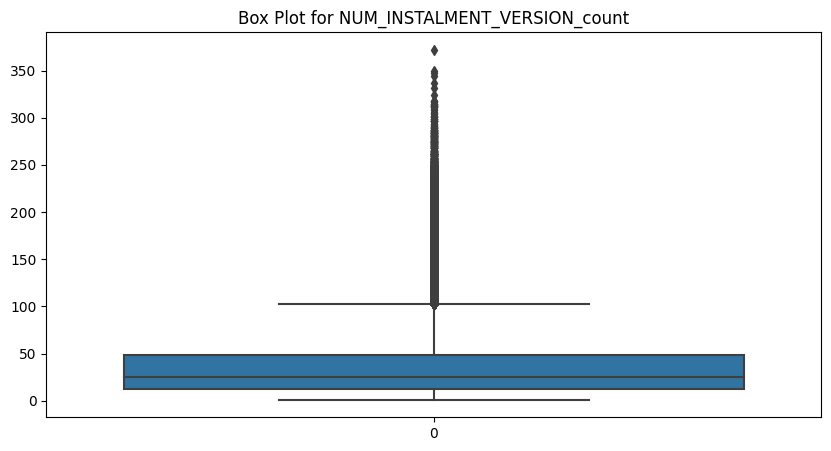

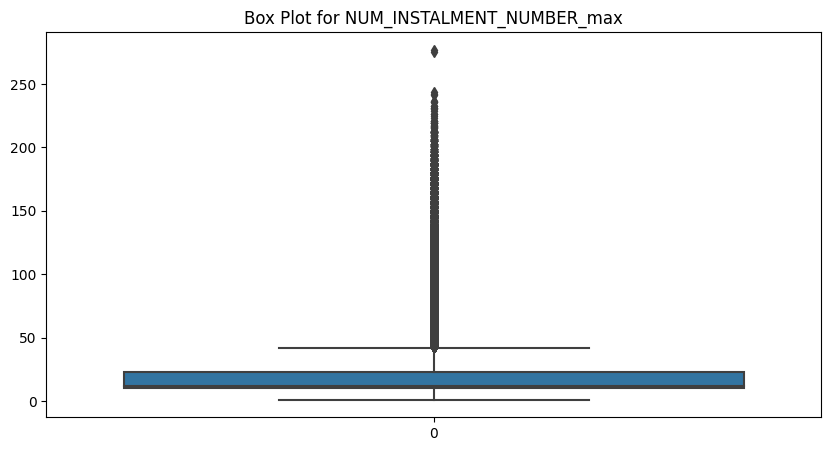

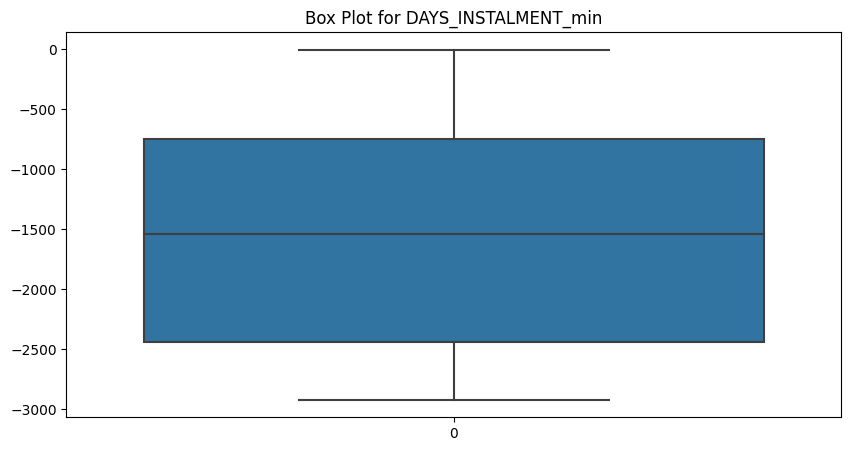

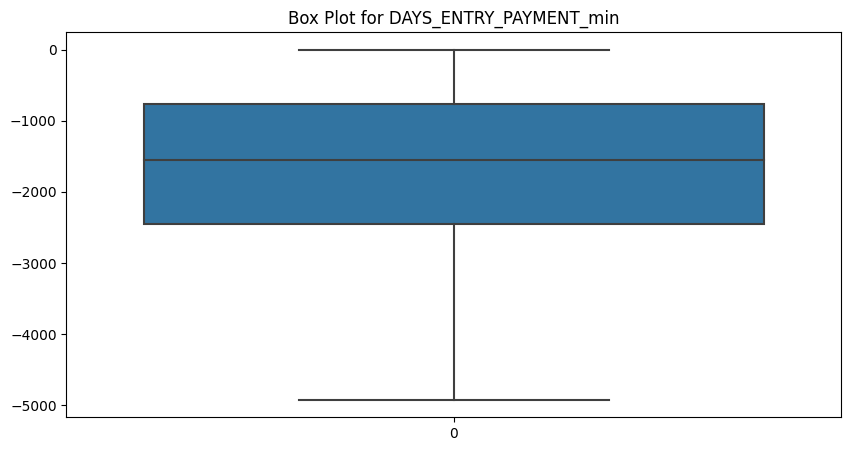

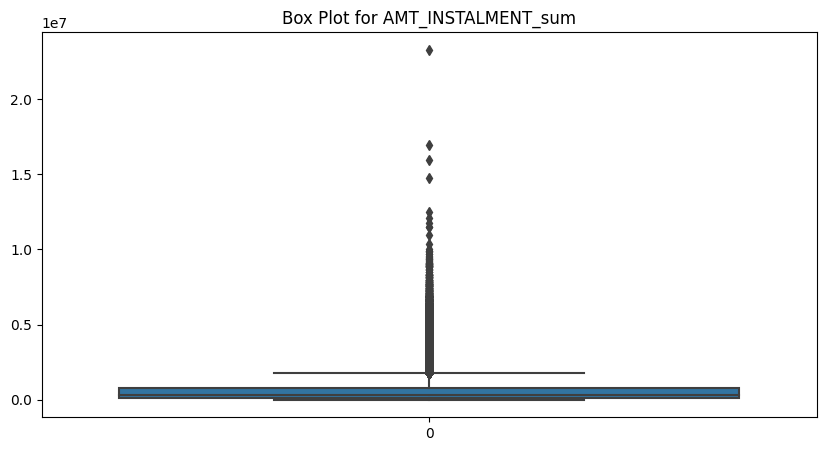

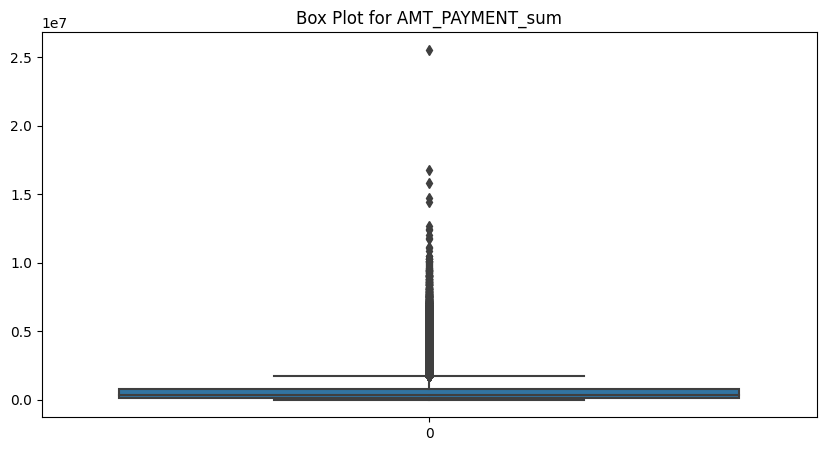

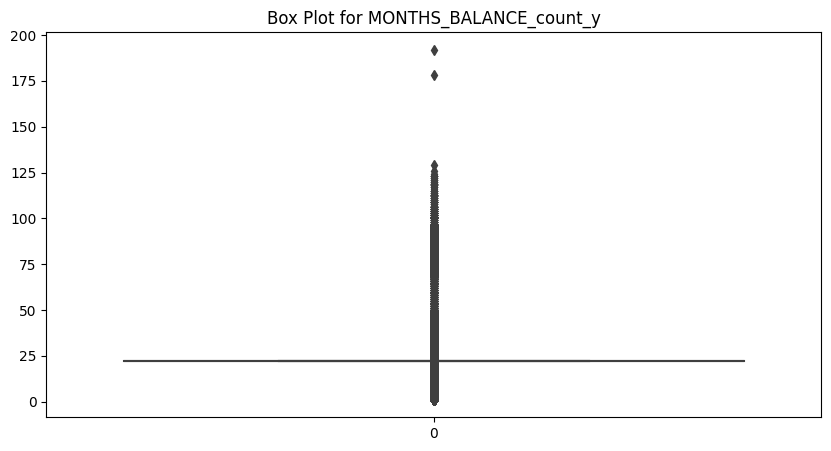

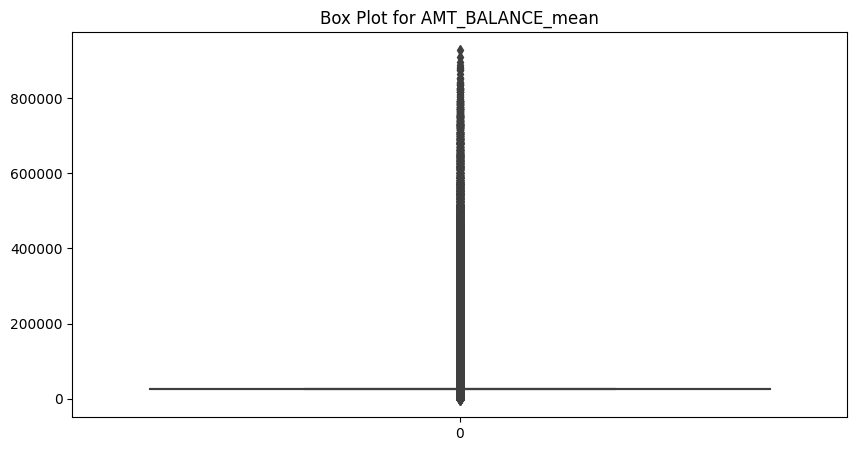

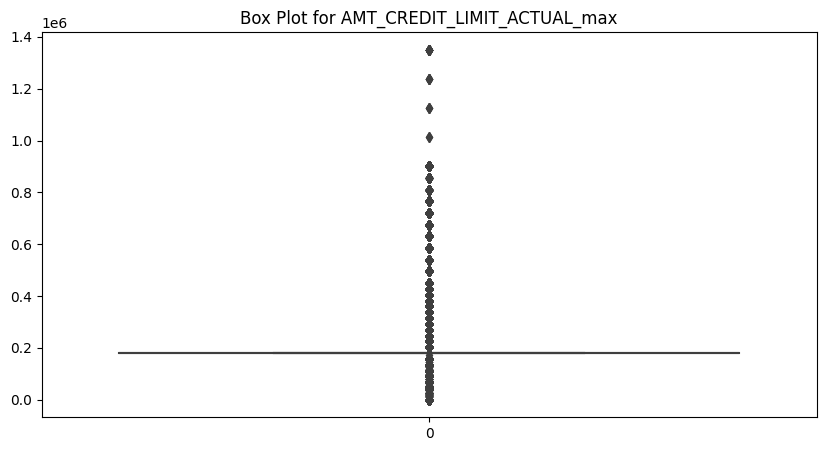

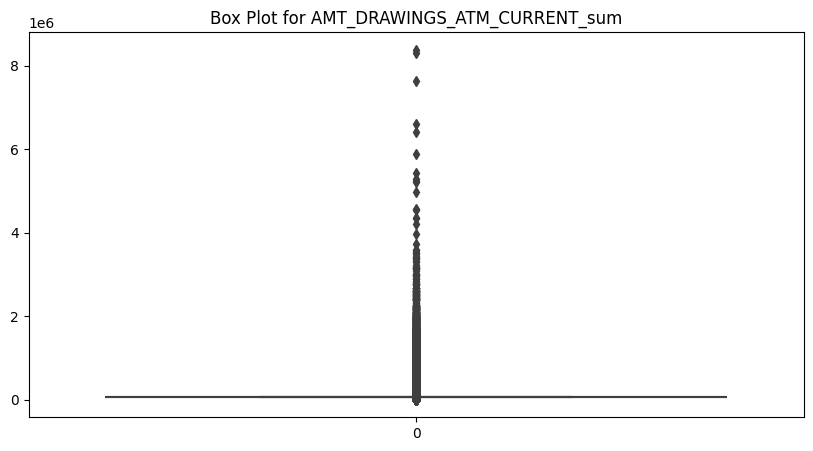

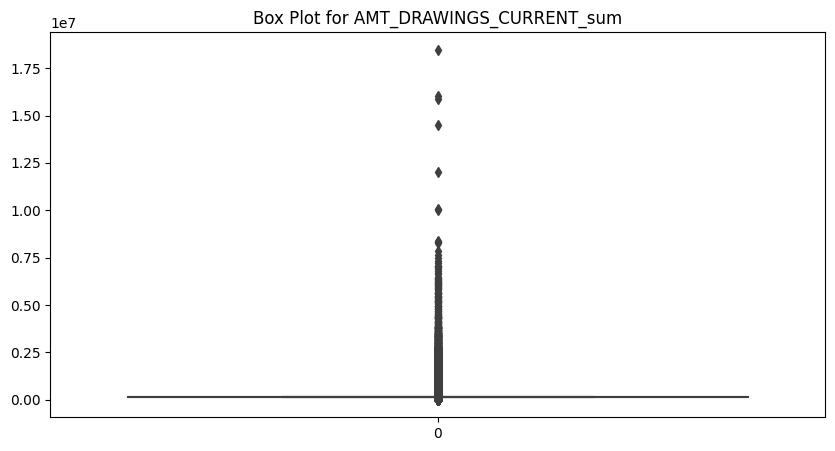

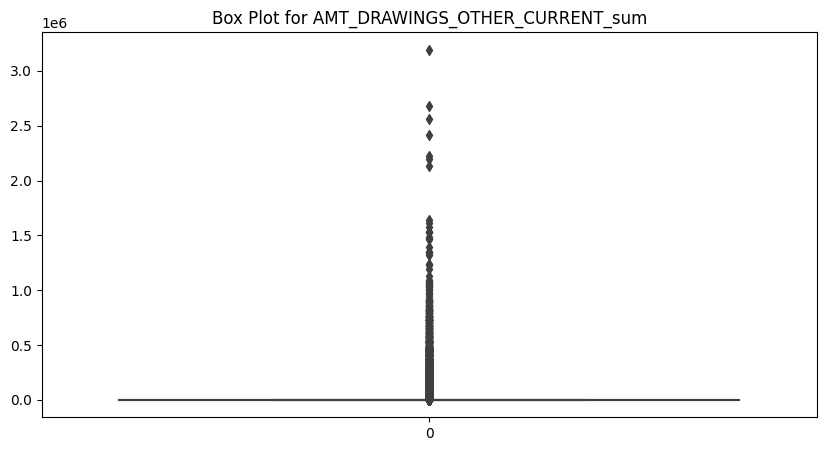

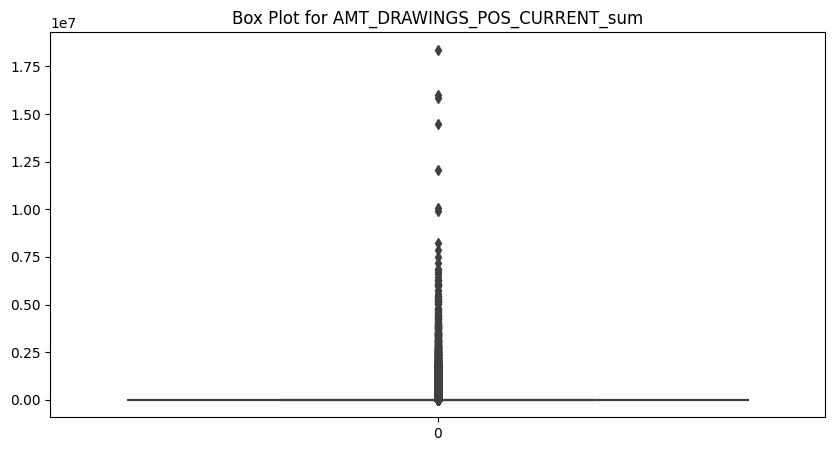

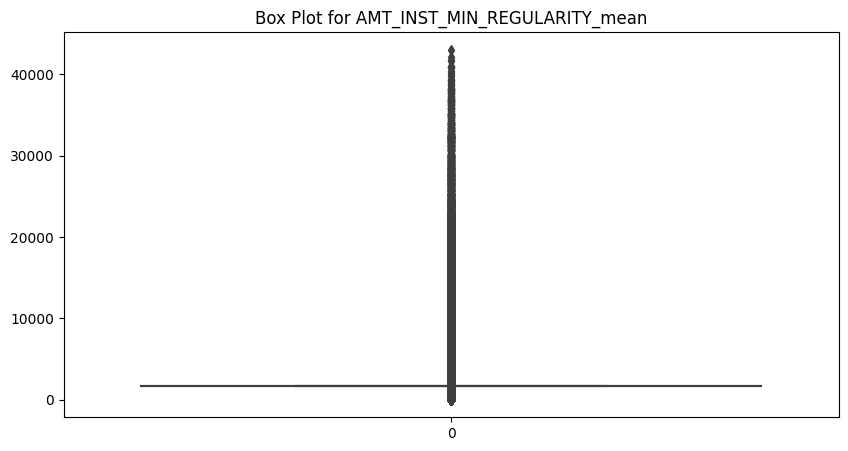

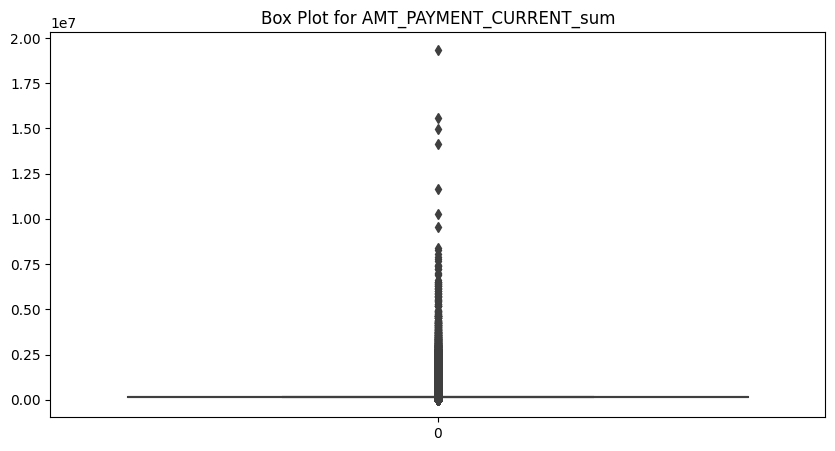

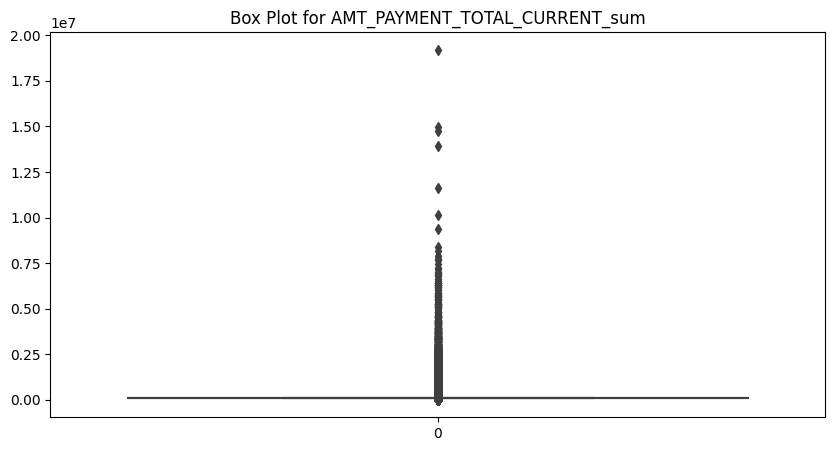

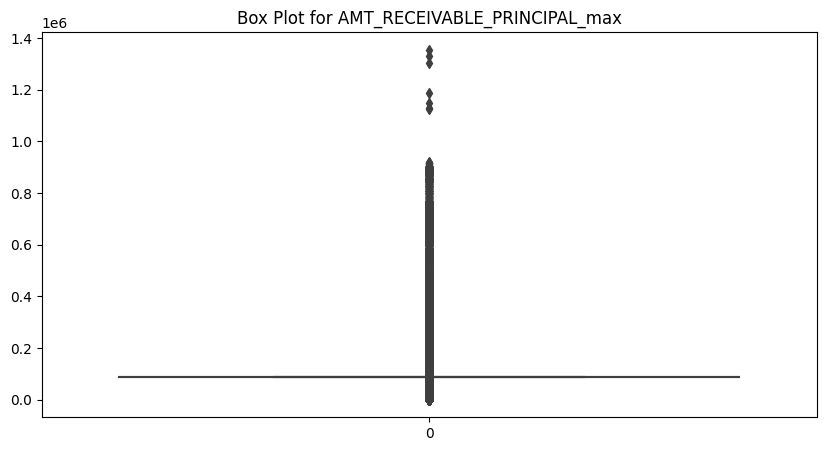

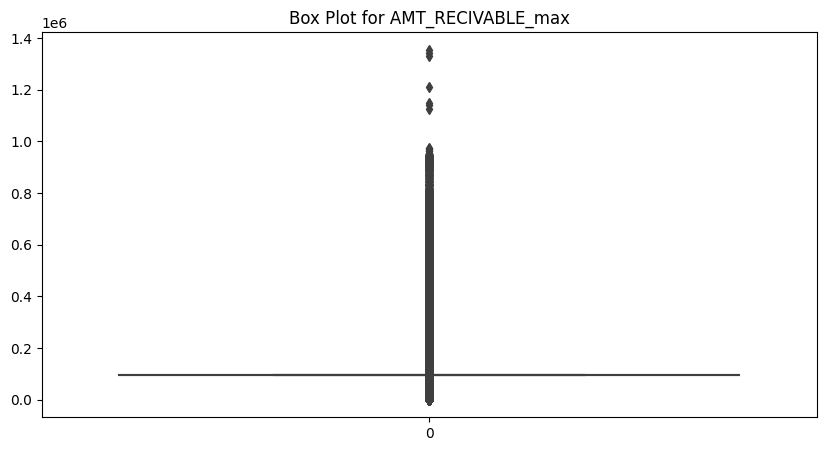

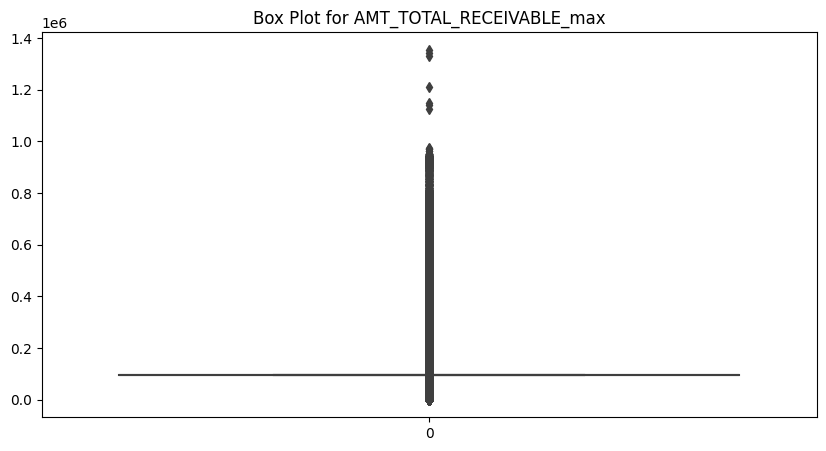

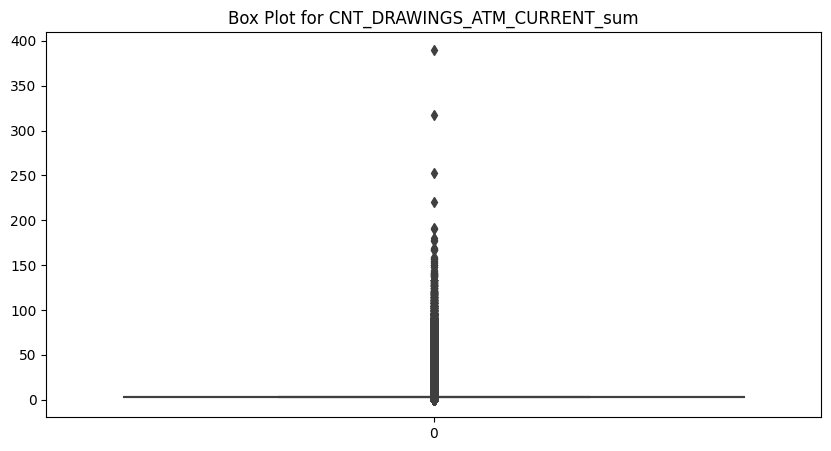

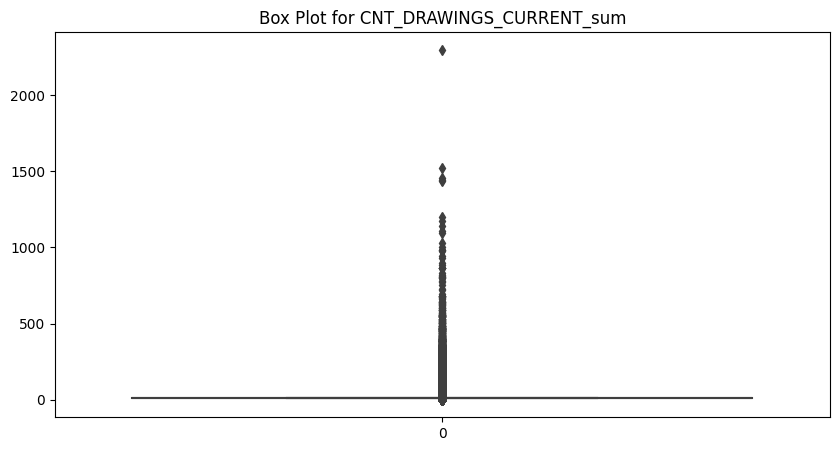

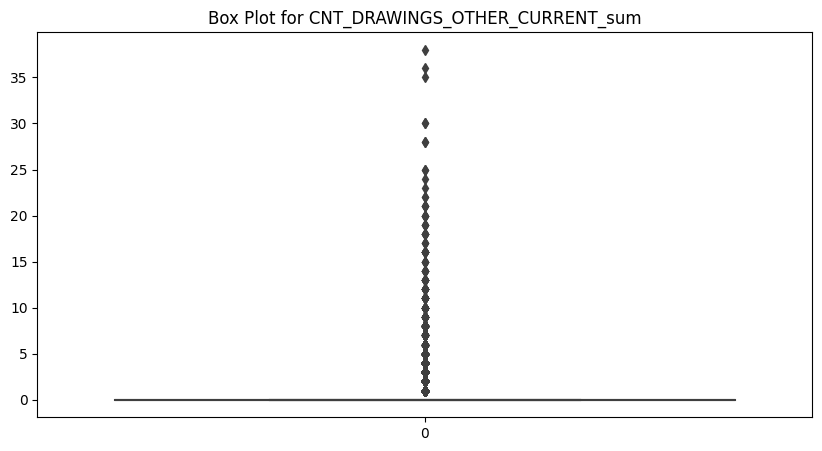

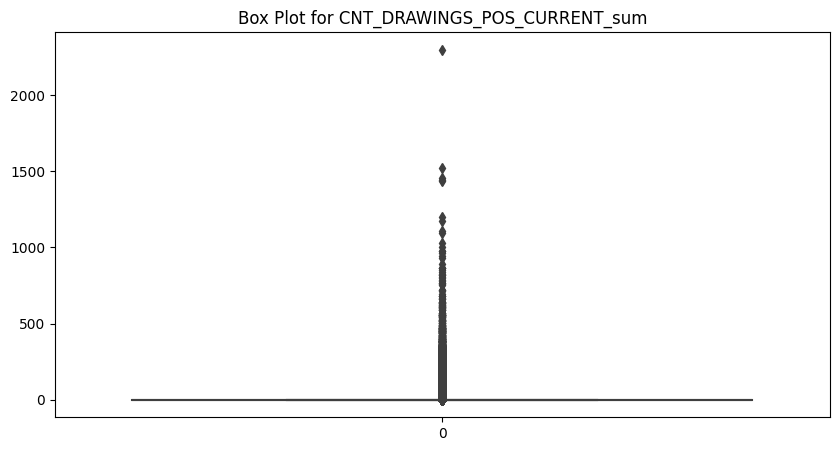

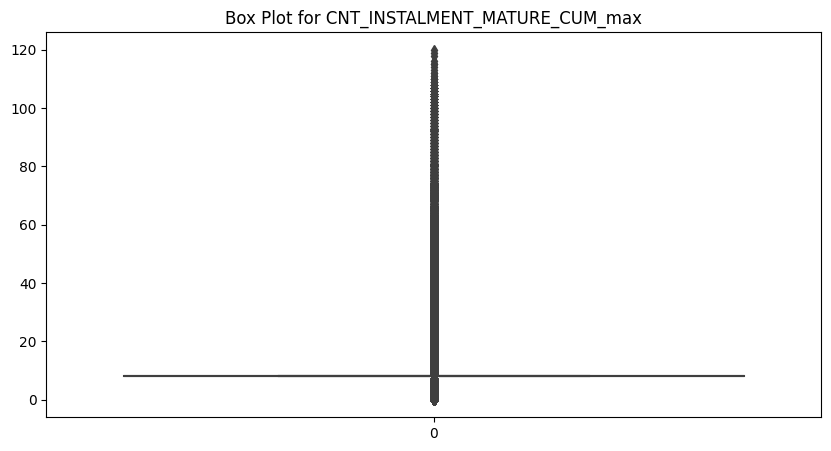

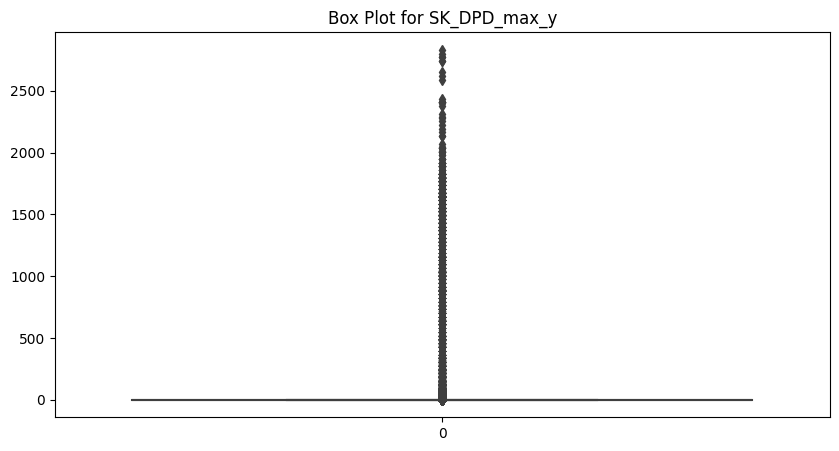

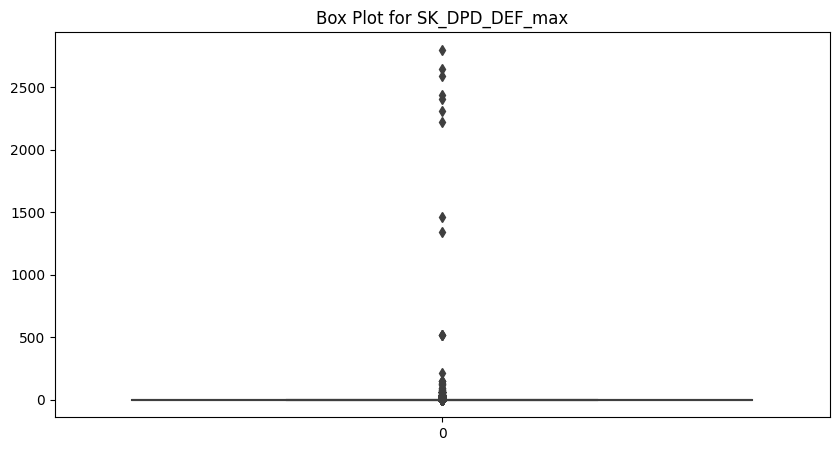

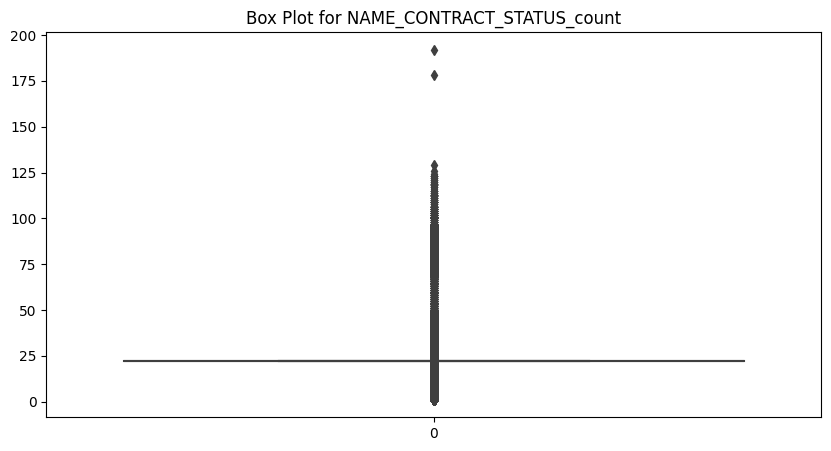

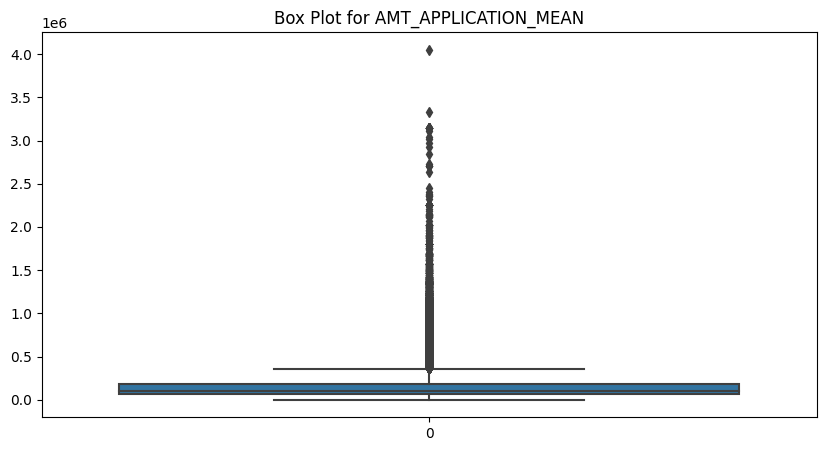

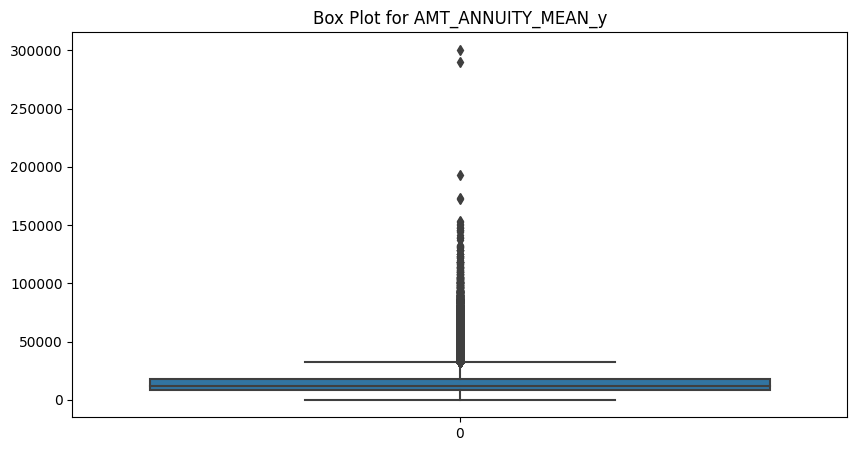

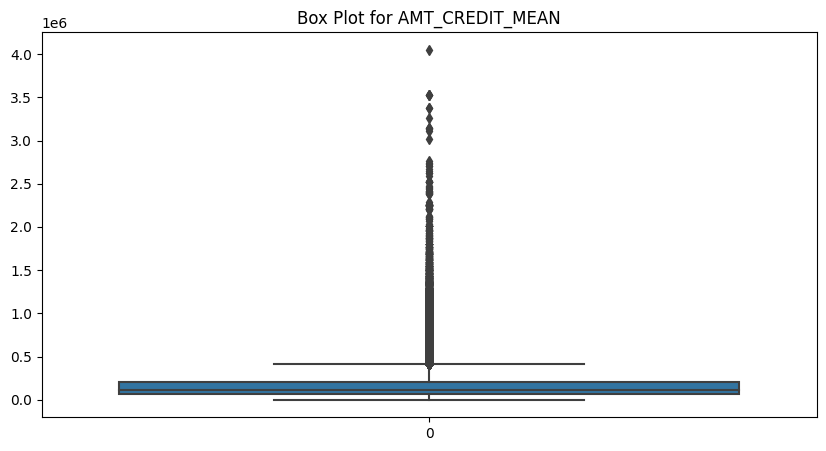

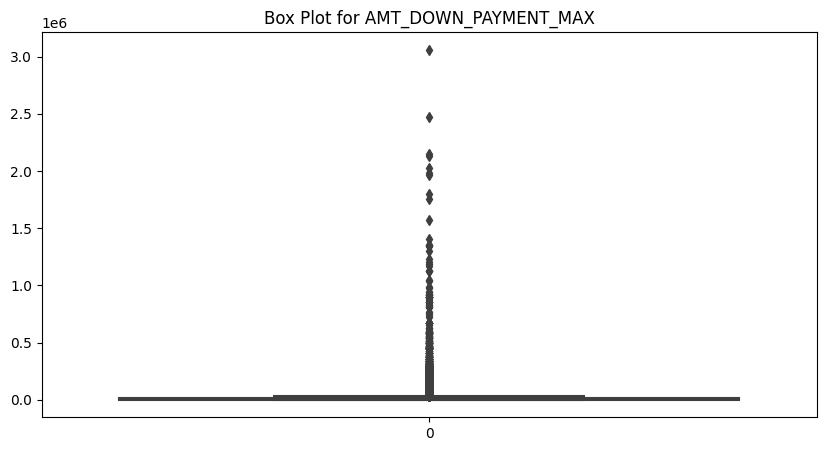

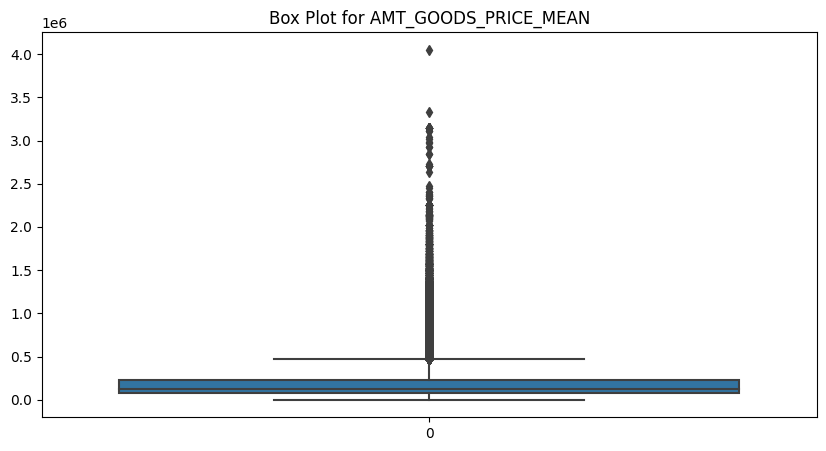

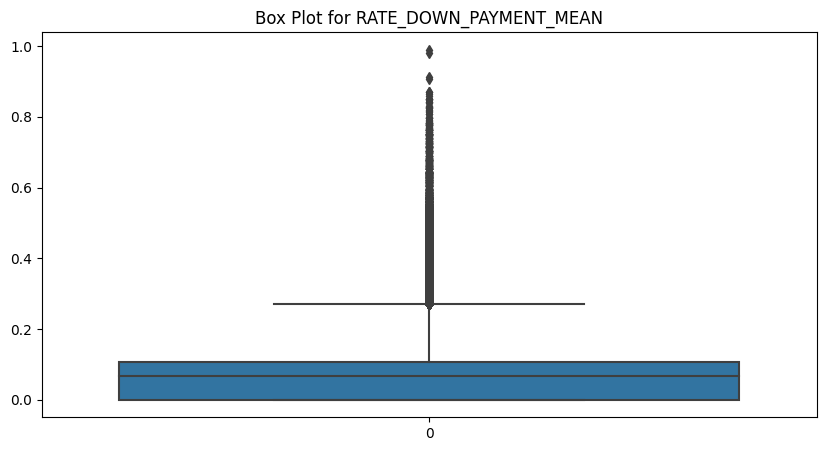

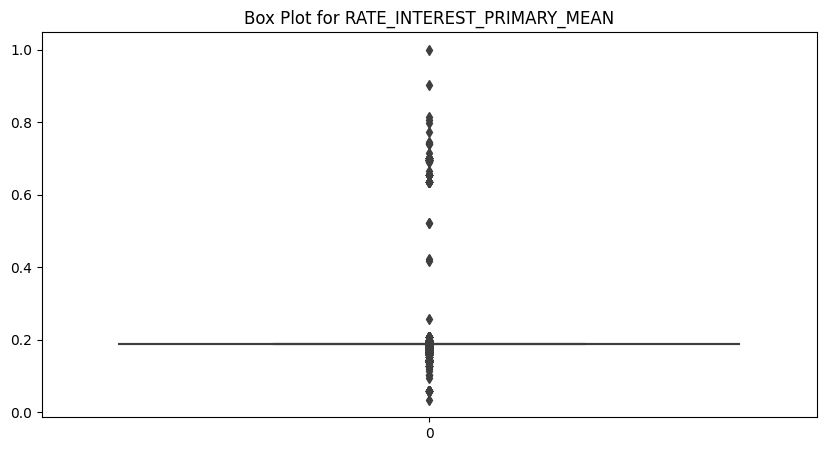

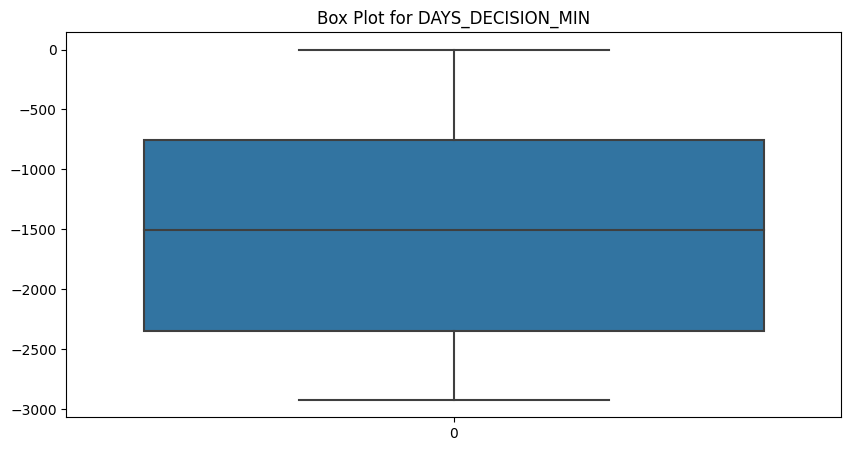

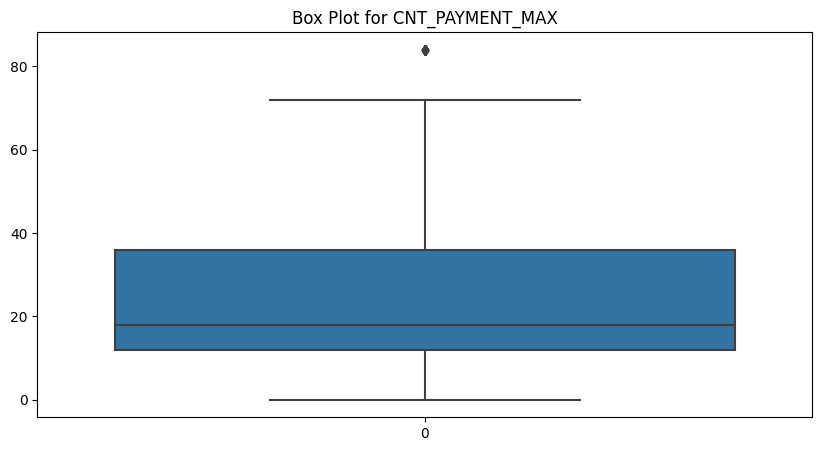

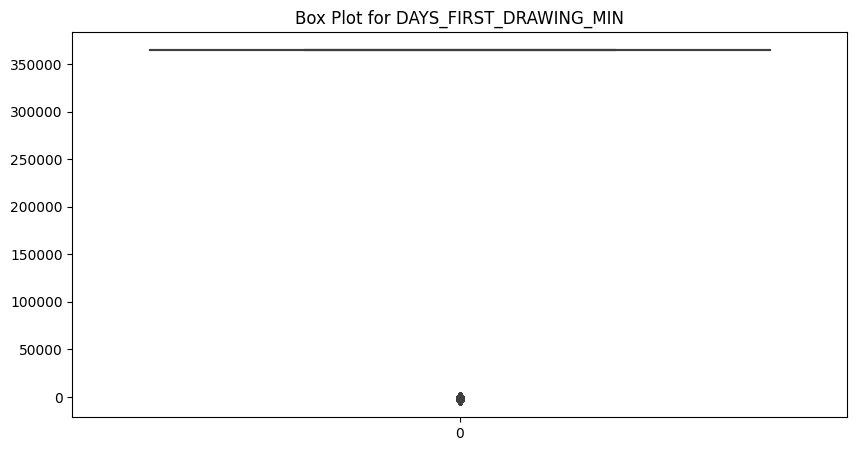

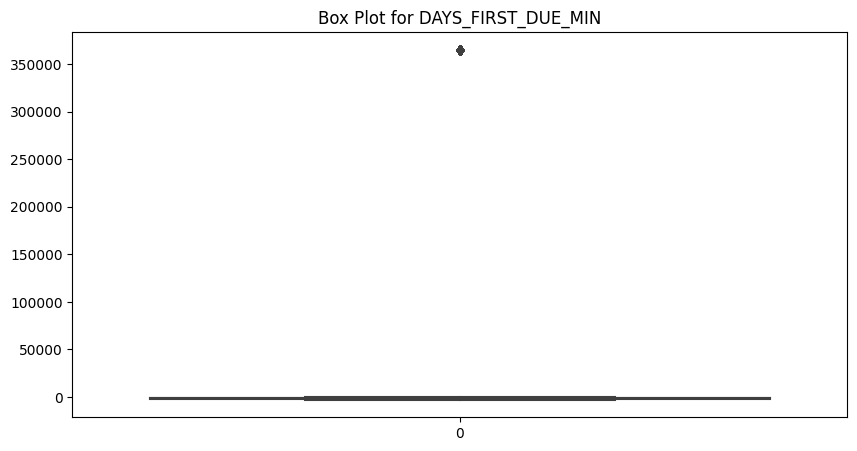

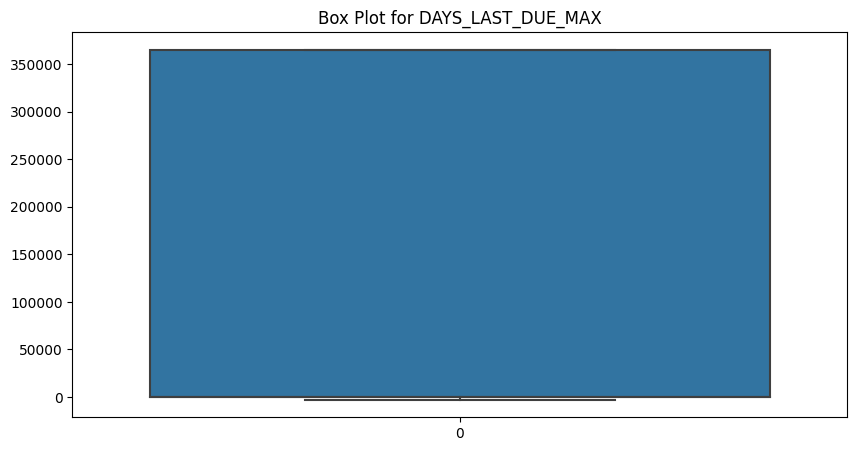

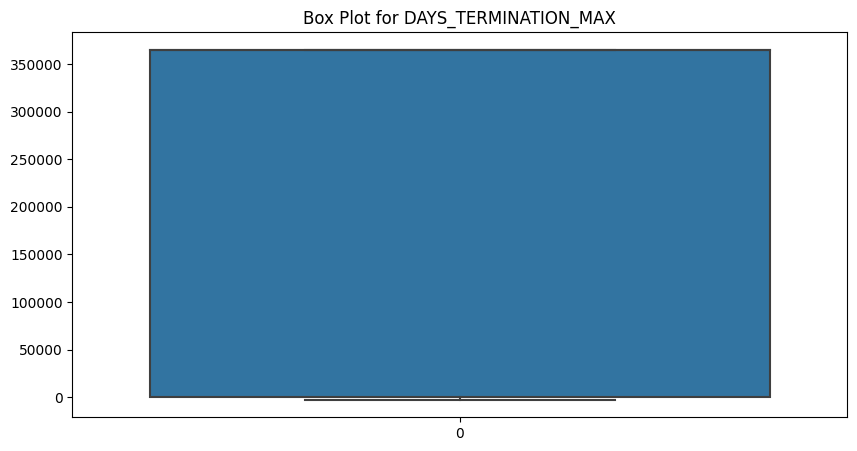

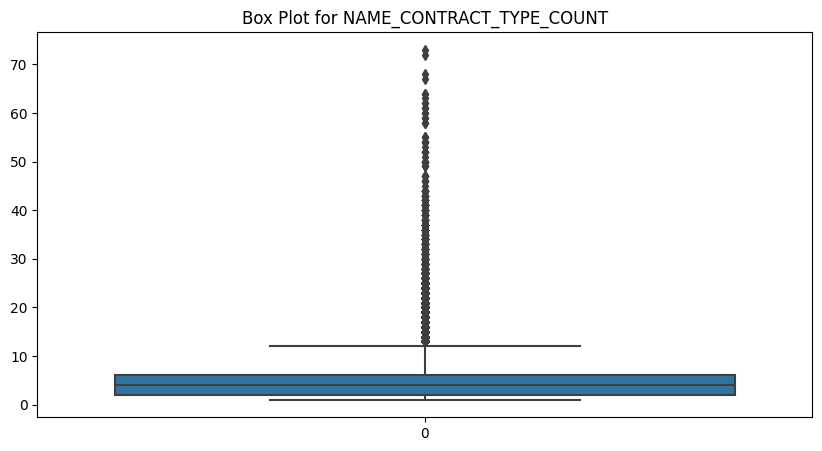

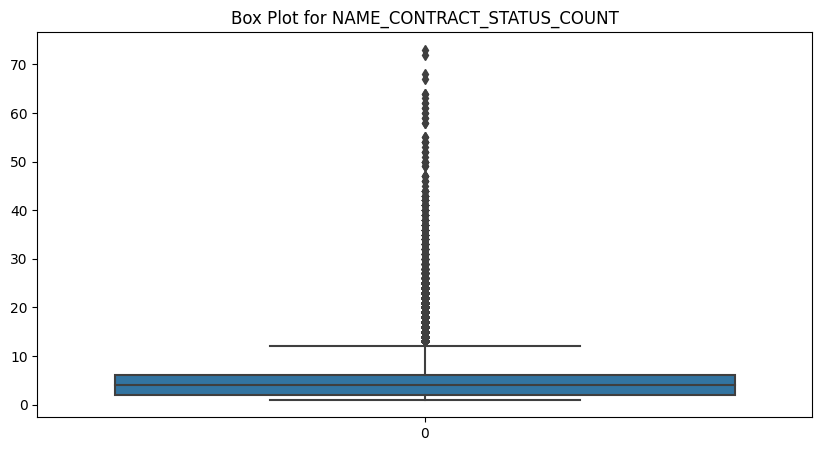

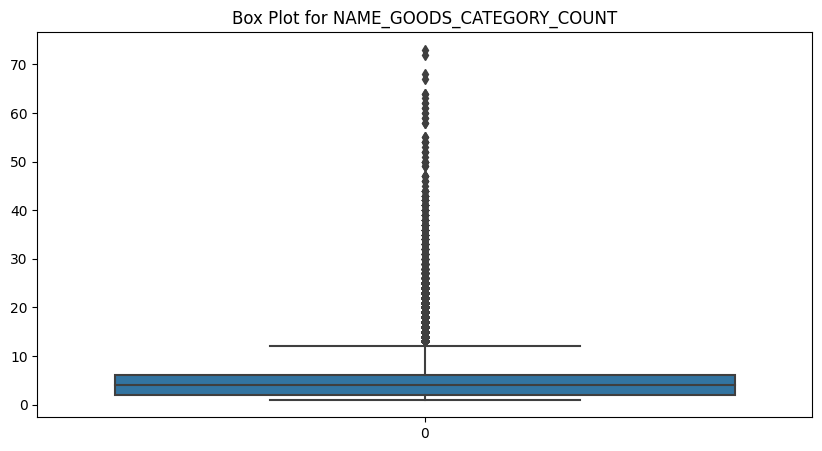

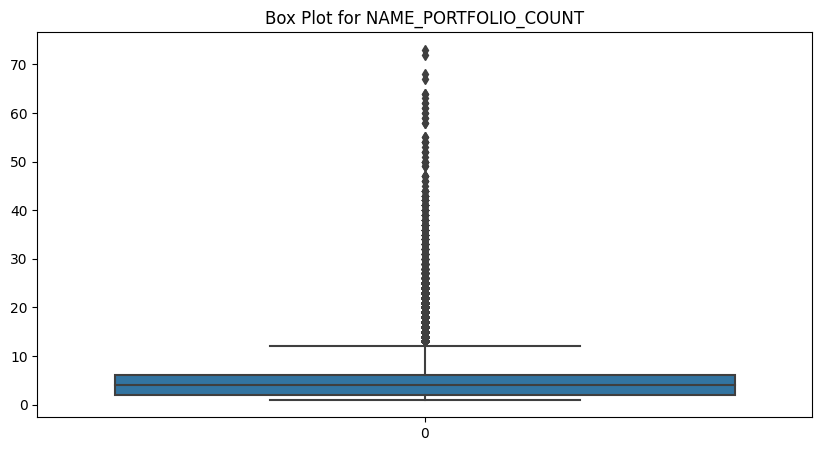

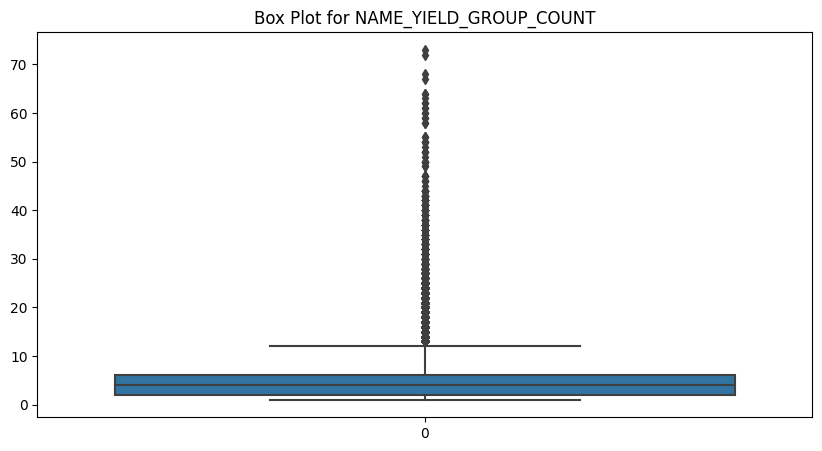

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
for column in final_data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=final_data[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

In [164]:
final_data = final_data[~((numeric_data < (Q1 - 3 * IQR)) | (numeric_data > (Q3 + 3 * IQR))).any(axis=1)]
print("Final Data After Adjusted Outlier Removal:", final_data.shape)

Final Data After Adjusted Outlier Removal: (10293, 137)


In [165]:
final_data.head()

EXT_SOURCE_1  NONLIVINGAREA_MODE  NONLIVINGAREA_AVG  NONLIVINGAREA_MEDI  \
9       0.501795            0.025731           0.026940            0.026848   
20      0.565655            0.000000           0.000000            0.000000   
21      0.437709            0.025653           0.026884            0.026792   
34      0.489310            0.000000           0.000000            0.000000   
45      0.501795            0.025731           0.026940            0.026848   

    ELEVATORS_MODE  ELEVATORS_AVG  ELEVATORS_MEDI WALLSMATERIAL_MODE  \
9         0.068197       0.072302        0.071443              Panel   
20        0.000000       0.000000        0.000000       Stone, brick   
21        0.068110       0.072272        0.071400              Panel   
34        0.000000       0.000000        0.000000       Stone, brick   
45        0.068197       0.072302        0.071443              Panel   

    APARTMENTS_AVG  APARTMENTS_MODE  ...  CNT_PAYMENT_MAX  \
9         0.116008         0.112915  ...             24.0   
20        0.072200         0.073500  ...             18.0   
21        0.116022         0.112844  ...             24.0   
34        0.082500         0.084000  ...             24.0   
45        0.116008         0.112915  ...              6.0   

    DAYS_FIRST_DRAWING_MIN  DAYS_FIRST_DUE_MIN  DAYS_LAST_DUE_MAX  \
9                 365243.0             -1641.0             -142.0   
20                365243.0             -1451.0              -18.0   
21                365243.0             -2029.0           365243.0   
34                365243.0             -1007.0             -407.0   
45                365243.0              -431.0             -176.0   

    DAYS_TERMINATION_MAX  NAME_CONTRACT_TYPE_COUNT  \
9                 -137.0                       4.0   
20              365243.0                       4.0   
21              365243.0                       8.0   
34                -397.0                       1.0   
45                -169.0                       2.0   

    NAME_CONTRACT_STATUS_COUNT  NAME_GOODS_CATEGORY_COUNT  \
9                          4.0                        4.0   
20                         4.0                        4.0   
21                         8.0                        8.0   
34                         1.0                        1.0   
45                         2.0                        2.0   

    NAME_PORTFOLIO_COUNT  NAME_YIELD_GROUP_COUNT  
9                    4.0                     4.0  
20                   4.0                     4.0  
21                   8.0                     8.0  
34                   1.0                     1.0  
45                   2.0                     2.0  

[5 rows x 137 columns]

# Visualization 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


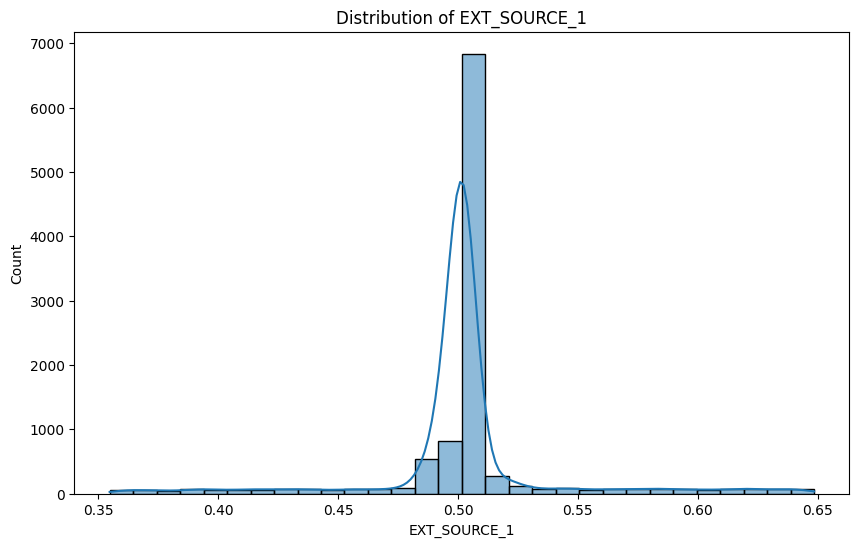

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(final_data['EXT_SOURCE_1'], bins=30, kde=True)
plt.title('Distribution of EXT_SOURCE_1')
plt.show()

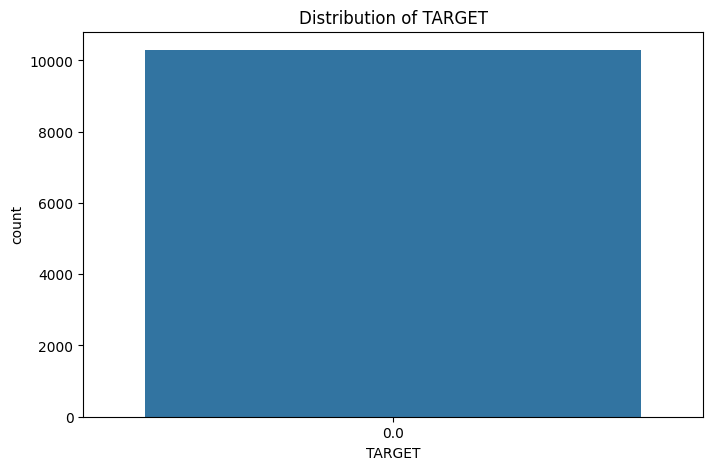

In [167]:
plt.figure(figsize=(8, 5))
sns.countplot(x='TARGET', data=final_data)
plt.title('Distribution of TARGET')
plt.show()

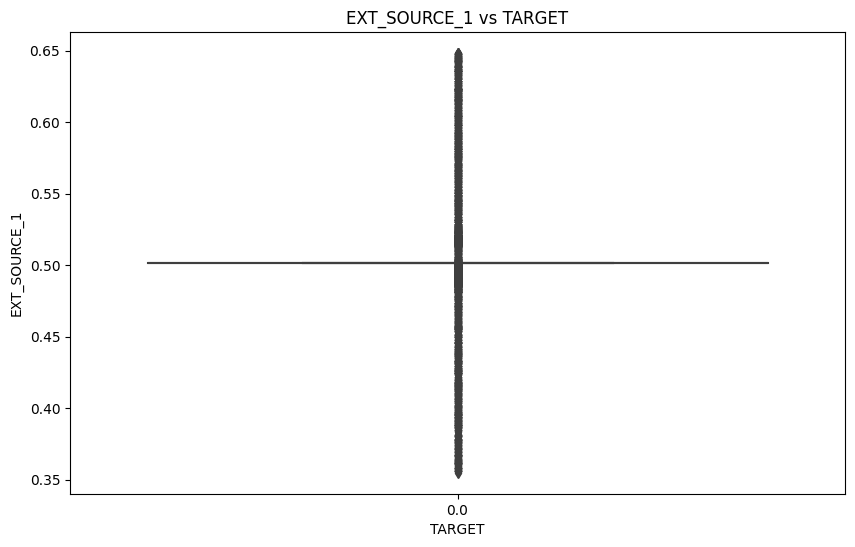

In [168]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='EXT_SOURCE_1', data=final_data)
plt.title('EXT_SOURCE_1 vs TARGET')
plt.show()

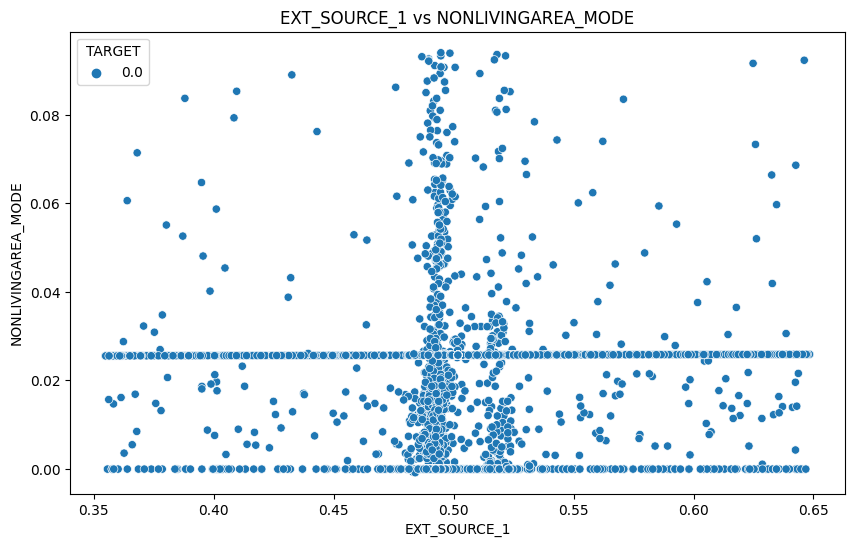

In [170]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EXT_SOURCE_1', y='NONLIVINGAREA_MODE', hue='TARGET', data=final_data)
plt.title('EXT_SOURCE_1 vs NONLIVINGAREA_MODE')
plt.show()

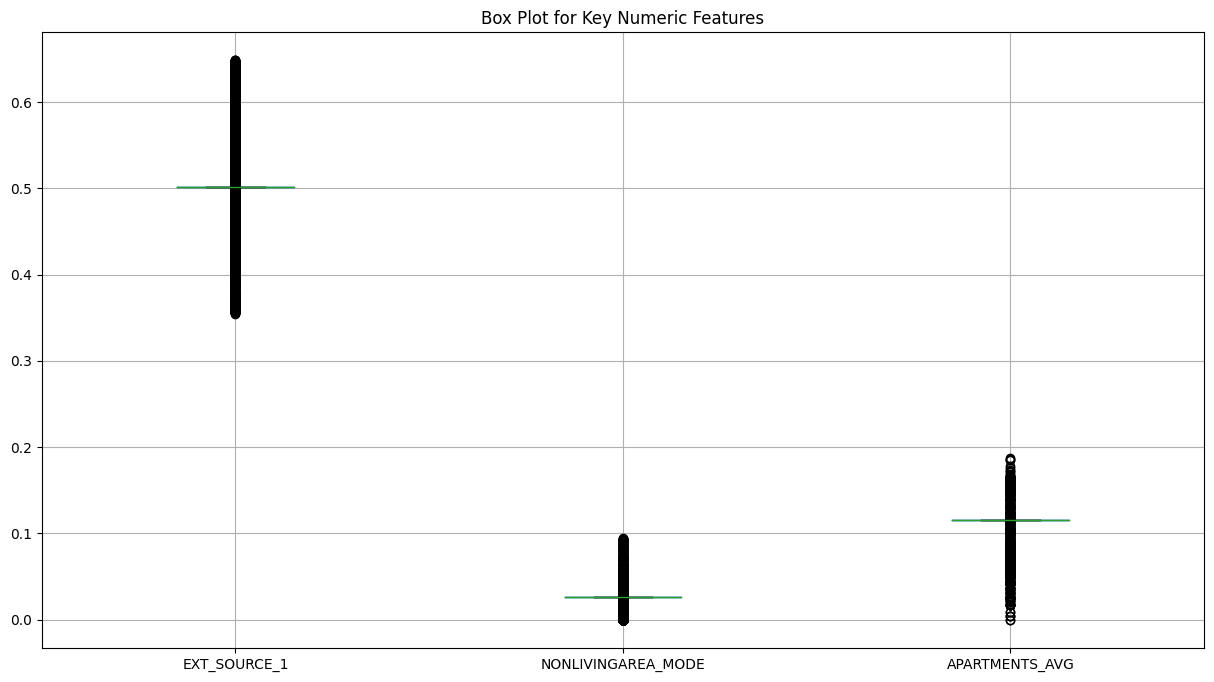

In [172]:
columns_to_plot = ['EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'APARTMENTS_AVG']

plt.figure(figsize=(15, 8))
final_data[columns_to_plot].boxplot()
plt.title('Box Plot for Key Numeric Features')
plt.show()

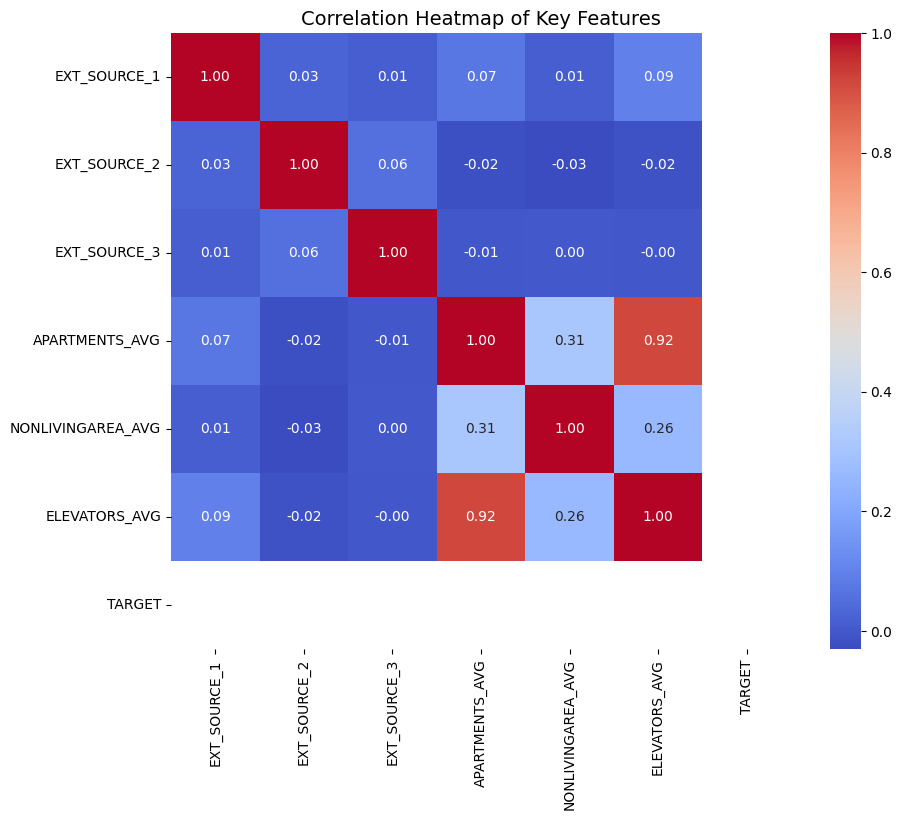

In [173]:
important_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG', 'TARGET']
corr = final_data[important_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Features', fontsize=14)
plt.show()

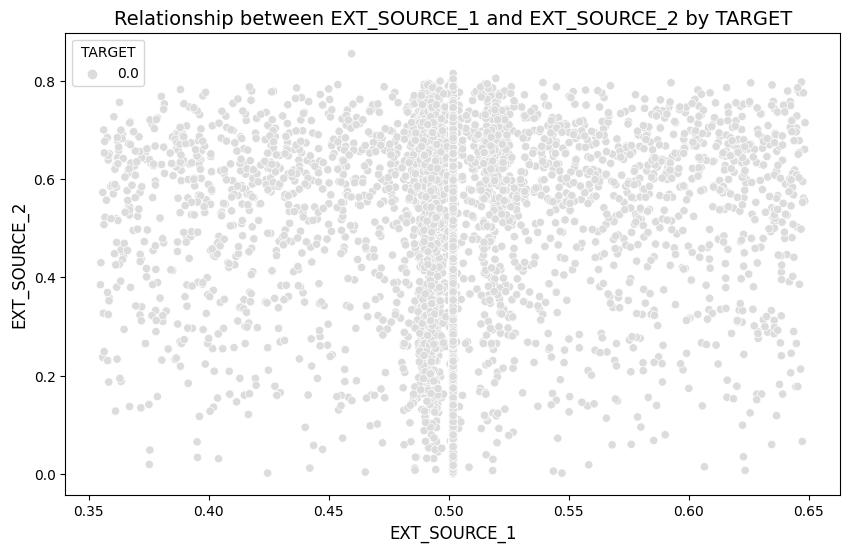

In [174]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EXT_SOURCE_1', y='EXT_SOURCE_2', hue='TARGET', data=final_data, palette='coolwarm')
plt.title('Relationship between EXT_SOURCE_1 and EXT_SOURCE_2 by TARGET', fontsize=14)
plt.xlabel('EXT_SOURCE_1', fontsize=12)
plt.ylabel('EXT_SOURCE_2', fontsize=12)
plt.legend(title='TARGET', fontsize=10)
plt.show()

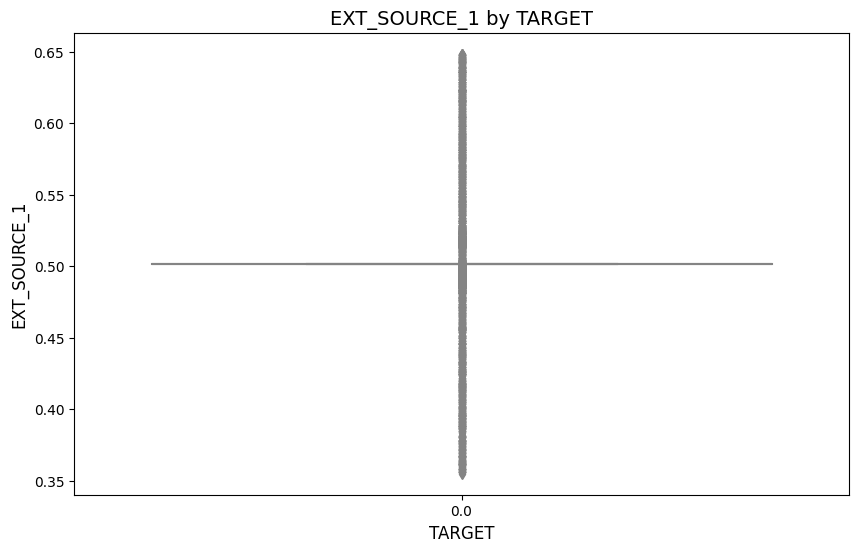

In [175]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='EXT_SOURCE_1', data=final_data, palette='coolwarm')
plt.title('EXT_SOURCE_1 by TARGET', fontsize=14)
plt.xlabel('TARGET', fontsize=12)
plt.ylabel('EXT_SOURCE_1', fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


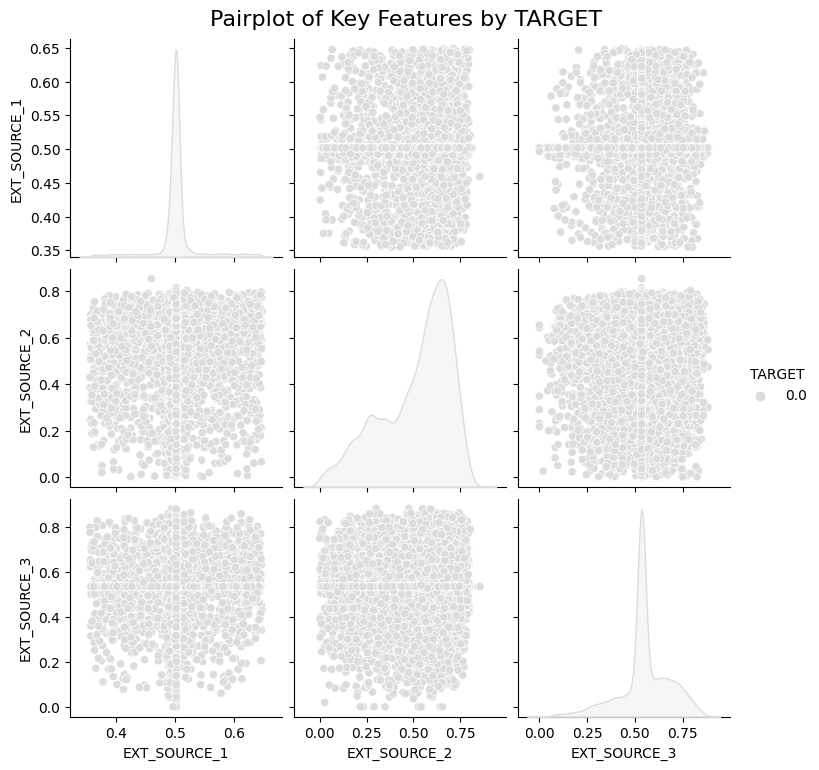

In [176]:
important_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']
sns.pairplot(final_data[important_features], hue='TARGET', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Key Features by TARGET', y=1.02, fontsize=16)
plt.show()

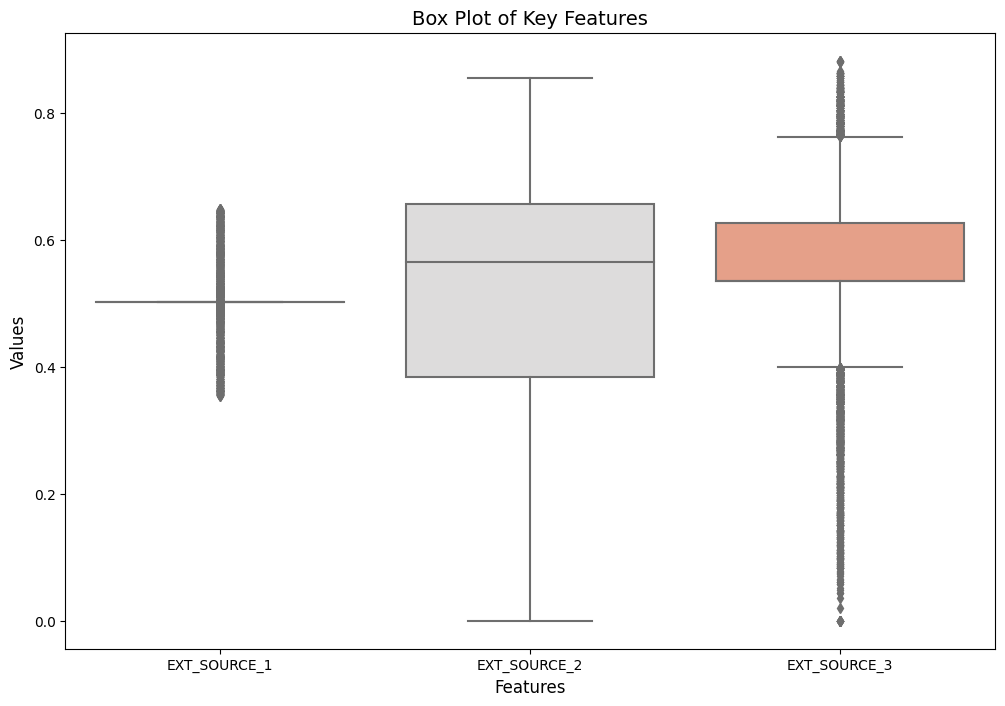

In [177]:
key_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
plt.figure(figsize=(12, 8))
sns.boxplot(data=final_data[key_columns], palette='coolwarm')
plt.title('Box Plot of Key Features', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-178-a74092614fd1>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_data['Cluster'] = clusters
<ipython-input-178-a74092614fd1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Cluster'] = clusters


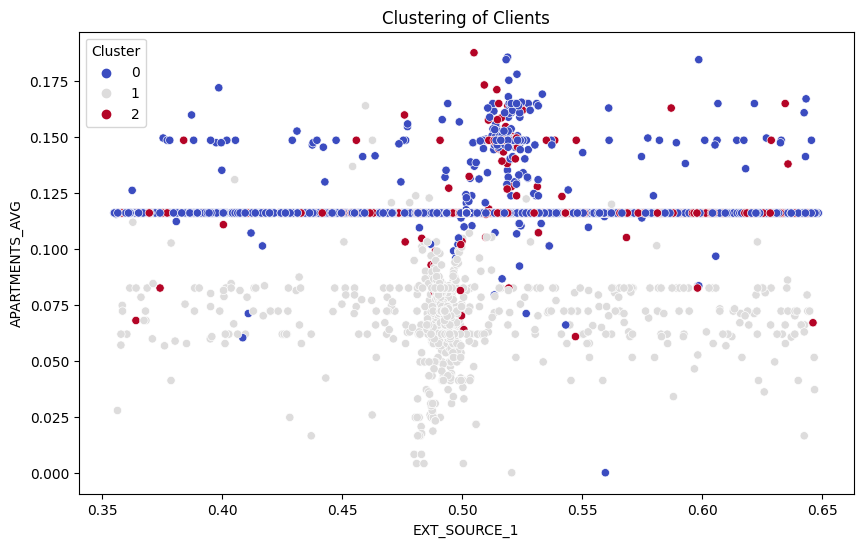

In [178]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_data = scaler.fit_transform(final_data[numeric_columns])
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(numeric_data)
final_data['Cluster'] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_data['EXT_SOURCE_1'], y=final_data['APARTMENTS_AVG'], hue=final_data['Cluster'], palette='coolwarm')
plt.title('Clustering of Clients')
plt.xlabel('EXT_SOURCE_1')
plt.ylabel('APARTMENTS_AVG')
plt.show()


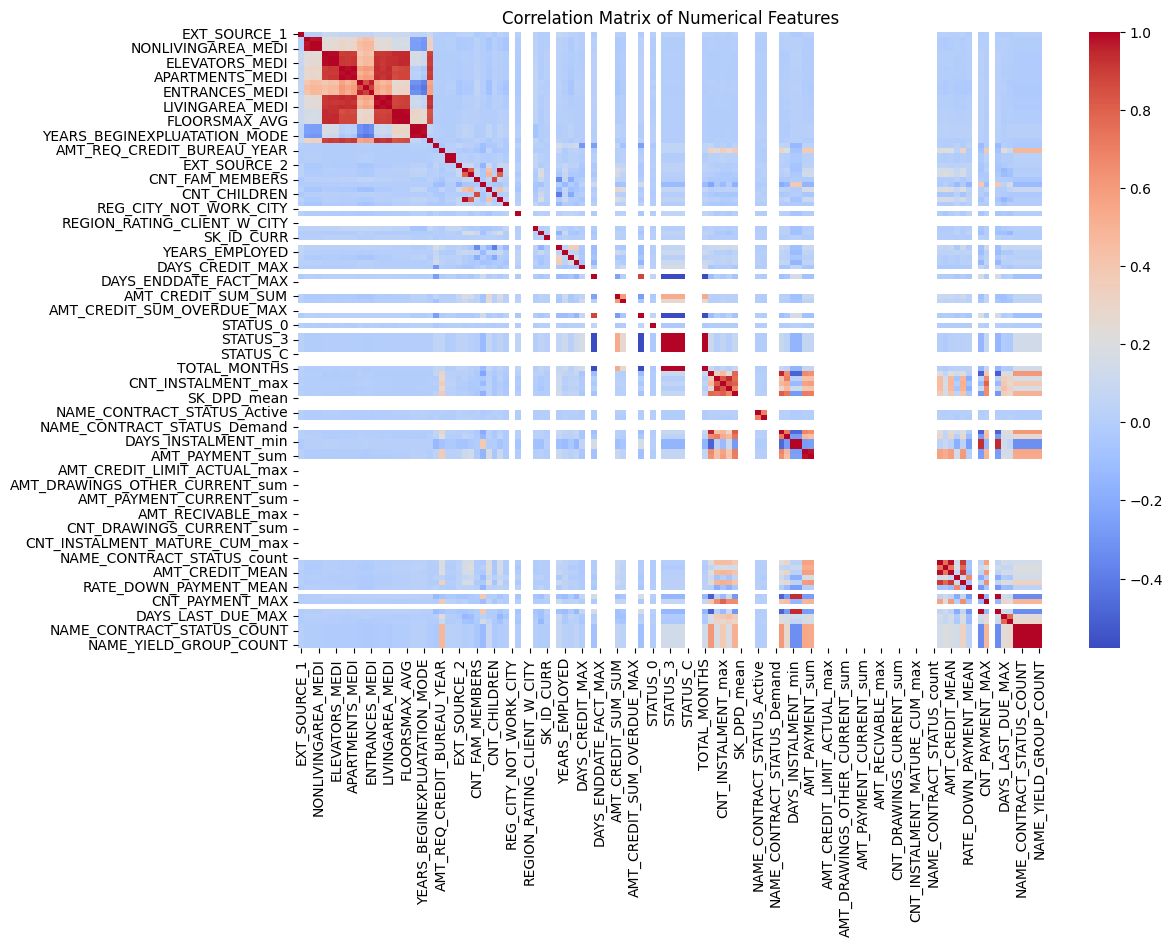

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = final_data[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [181]:
final_data

EXT_SOURCE_1  NONLIVINGAREA_MODE  NONLIVINGAREA_AVG  \
9           0.501795            0.025731           0.026940   
20          0.565655            0.000000           0.000000   
21          0.437709            0.025653           0.026884   
34          0.489310            0.000000           0.000000   
45          0.501795            0.025731           0.026940   
...              ...                 ...                ...   
307367      0.501795            0.025731           0.026940   
307388      0.379638            0.025583           0.026835   
307398      0.501795            0.025731           0.026940   
307399      0.529913            0.025764           0.026963   
307443      0.501795            0.025731           0.026940   

        NONLIVINGAREA_MEDI  ELEVATORS_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  \
9                 0.026848        0.068197       0.072302        0.071443   
20                0.000000        0.000000       0.000000        0.000000   
21                0.026792        0.068110       0.072272        0.071400   
34                0.000000        0.000000       0.000000        0.000000   
45                0.026848        0.068197       0.072302        0.071443   
...                    ...             ...            ...             ...   
307367            0.026848        0.068197       0.072302        0.071443   
307388            0.026741        0.068030       0.072243        0.071359   
307398            0.026848        0.068197       0.072302        0.071443   
307399            0.026871        0.068238       0.072318        0.071465   
307443            0.026848        0.068197       0.072302        0.071443   

       WALLSMATERIAL_MODE  APARTMENTS_AVG  APARTMENTS_MODE  ...  \
9                   Panel        0.116008         0.112915  ...   
20           Stone, brick        0.072200         0.073500  ...   
21                  Panel        0.116022         0.112844  ...   
34           Stone, brick        0.082500         0.084000  ...   
45                  Panel        0.116008         0.112915  ...   
...                   ...             ...              ...  ...   
307367              Panel        0.116008         0.112915  ...   
307388              Panel        0.116033         0.112777  ...   
307398              Panel        0.116008         0.112915  ...   
307399              Panel        0.116005         0.112949  ...   
307443              Panel        0.116008         0.112915  ...   

        DAYS_FIRST_DRAWING_MIN  DAYS_FIRST_DUE_MIN  DAYS_LAST_DUE_MAX  \
9                     365243.0             -1641.0             -142.0   
20                    365243.0             -1451.0              -18.0   
21                    365243.0             -2029.0           365243.0   
34                    365243.0             -1007.0             -407.0   
45                    365243.0              -431.0             -176.0   
...                        ...                 ...                ...   
307367                365243.0              -206.0           365243.0   
307388                365243.0              -232.0           365243.0   
307398                365243.0             -1942.0           365243.0   
307399                365243.0              -862.0           365243.0   
307443                365243.0              -259.0           365243.0   

        DAYS_TERMINATION_MAX  NAME_CONTRACT_TYPE_COUNT  \
9                     -137.0                       4.0   
20                  365243.0                       4.0   
21                  365243.0                       8.0   
34                    -397.0                       1.0   
45                    -169.0                       2.0   
...                      ...                       ...   
307367              365243.0                       1.0   
307388              365243.0                       2.0   
307398              365243.0                       9.0   
307399              365243.0                      14.0   
307443

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


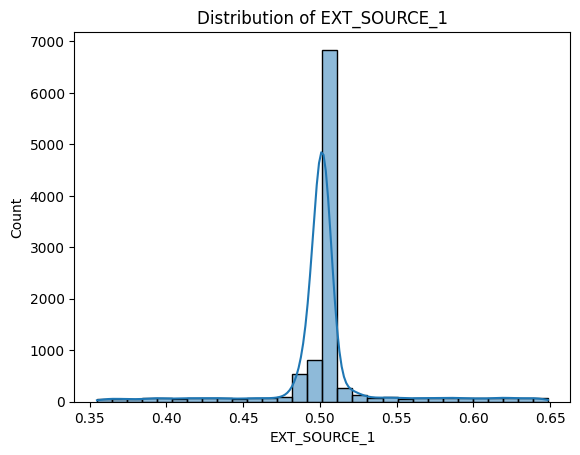

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(final_data['EXT_SOURCE_1'], bins=30, kde=True)
plt.title('Distribution of EXT_SOURCE_1')
plt.show()

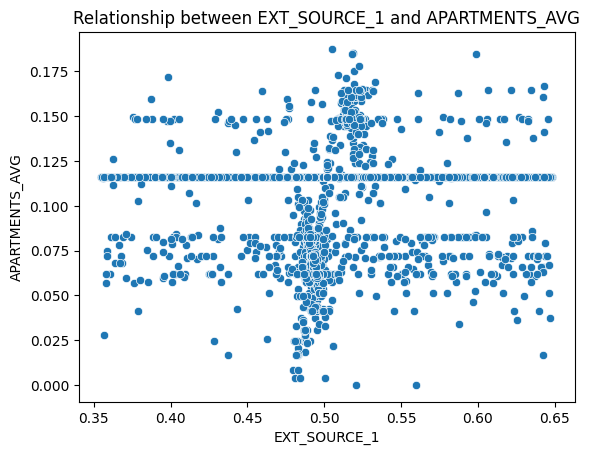

In [196]:
sns.scatterplot(x=final_data['EXT_SOURCE_1'], y=final_data['APARTMENTS_AVG'])
plt.title('Relationship between EXT_SOURCE_1 and APARTMENTS_AVG')
plt.show()

In [198]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le


In [199]:
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-200-996538e1a1b8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Cluster'] = clusters


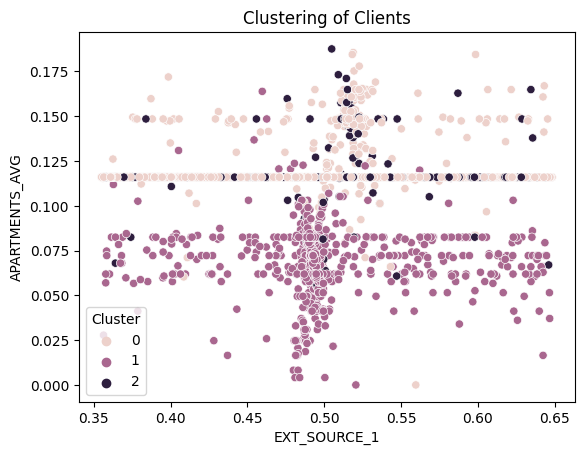

In [200]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

final_data['Cluster'] = clusters

sns.scatterplot(x=final_data['EXT_SOURCE_1'], y=final_data['APARTMENTS_AVG'], hue=final_data['Cluster'])
plt.title('Clustering of Clients')
plt.show()


# Model

In [189]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [206]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [208]:
print(y_test.value_counts())

TARGET
0.0    2059
Name: count, dtype: int64


In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())


Training set distribution:
 TARGET
0.0    8234
Name: count, dtype: int64
Testing set distribution:
 TARGET
0.0    2059
Name: count, dtype: int64


In [213]:
print("Original TARGET distribution:\n", y.value_counts())

Original TARGET distribution:
 TARGET
0.0    10293
Name: count, dtype: int64


In [214]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso.fit_predict(X)
final_data['Anomaly'] = anomalies
print(final_data['Anomaly'].value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Anomaly
 1    9778
-1     515
Name: count, dtype: int64


<ipython-input-214-8cada11c5003>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_data['Anomaly'] = anomalies
<ipython-input-214-8cada11c5003>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Anomaly'] = anomalies


In [215]:

anomalies = final_data[final_data['Anomaly'] == -1]
print("Sample of anomalies:\n", anomalies.head())

Sample of anomalies:
       EXT_SOURCE_1  NONLIVINGAREA_MODE  NONLIVINGAREA_AVG  NONLIVINGAREA_MEDI  \
463       0.625823              0.0733             0.0692              0.0707   
493       0.518113              0.0007             0.0006              0.0006   
694       0.491887              0.0000             0.0000              0.0000   
925       0.514914              0.0000             0.0000              0.0000   
1931      0.492061              0.0000             0.0000              0.0000   

      ELEVATORS_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  WALLSMATERIAL_MODE  \
463           0.0000           0.00            0.00                   5   
493           0.1611           0.16            0.16                   4   
694           0.0000           0.00            0.00                   5   
925           0.1611           0.16            0.16                   4   
1931          0.0000           0.00            0.00                   5   

      APARTMENTS_AVG  APARTMENTS_MODE  .

In [217]:
categorical_columns = final_data.select_dtypes(include=['object']).columns
print("Categorical columns:\n", categorical_columns)

Categorical columns:
 Index(['OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CODE_GENDER',
       'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE'],
      dtype='object')


In [219]:
for col in ['OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
            'CODE_GENDER', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
            'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE']:
    le = LabelEncoder()
    final_data.loc[:, col] = le.fit_transform(final_data[col].astype(str))

In [220]:
final_data = final_data.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

final_data = final_data.copy()

categorical_columns = ['OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'CODE_GENDER', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
                       'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE']

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    final_data.loc[:, col] = le.fit_transform(final_data[col].astype(str))
    label_encoders[col] = le
print("22BBS0183")

In [223]:
print(final_data.dtypes.value_counts())

float64    127
int64       11
int32        1
Name: count, dtype: int64


In [224]:
print(final_data[categorical_columns].head())

    OCCUPATION_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CODE_GENDER  \
9                 8             0                1            1   
20                8             1                1            1   
21               14             1                1            0   
34                3             0                1            0   
45               14             0                1            0   

    ORGANIZATION_TYPE  WEEKDAY_APPR_PROCESS_START  NAME_INCOME_TYPE  \
9                  51                           4                 4   
20                 30                           0                 4   
21                 39                           1                 0   
34                 29                           0                 2   
45                 30                           1                 4   

    NAME_FAMILY_STATUS  NAME_EDUCATION_TYPE  
9                    3                    4  
20                   1                    4  
21                   1          

In [225]:
anomalies = final_data[final_data['Anomaly'] == -1]
normal_data = final_data[final_data['Anomaly'] == 1]

summary = pd.DataFrame({
    'Anomalies Mean': anomalies.mean(),
    'Normal Data Mean': normal_data.mean(),
    'Difference': anomalies.mean() - normal_data.mean()
})
print(summary.sort_values('Difference', ascending=False).head(10))

                         Anomalies Mean  Normal Data Mean     Difference
AMT_CREDIT_SUM_SUM         1.633803e+06      1.043122e+06  590680.483252
AMT_PAYMENT_sum            6.446068e+05      2.966118e+05  347994.952648
AMT_INSTALMENT_sum         6.178919e+05      2.945296e+05  323362.356581
AMT_CREDIT_SUM_DEBT_SUM    4.051539e+05      2.790898e+05  126064.184453
AMT_GOODS_PRICE            5.598966e+05      4.684372e+05   91459.420071
AMT_CREDIT                 6.072916e+05      5.201962e+05   87095.429571
AMT_GOODS_PRICE_MEAN       1.956190e+05      1.311086e+05   64510.458112
DAYS_LAST_DUE_MAX          1.642825e+05      1.179939e+05   46288.598945
AMT_CREDIT_MEAN            1.635358e+05      1.181473e+05   45388.505596
AMT_APPLICATION_MEAN       1.531733e+05      1.120020e+05   41171.297244


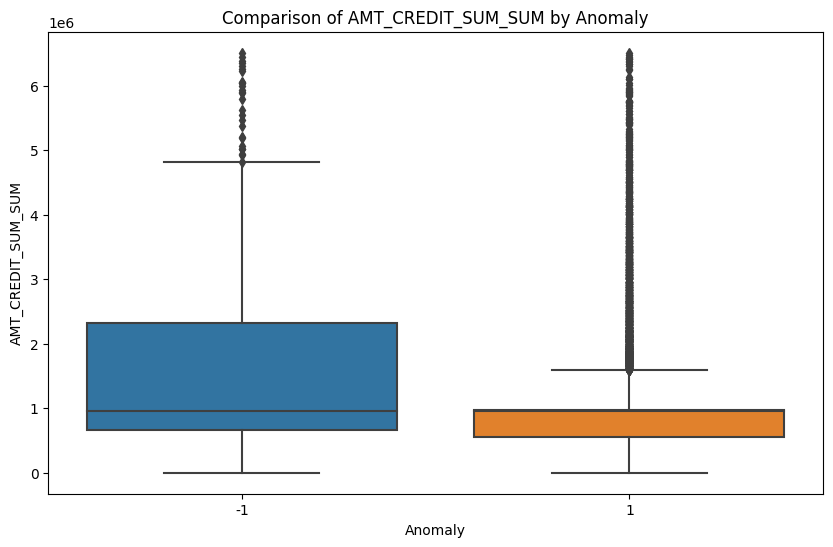

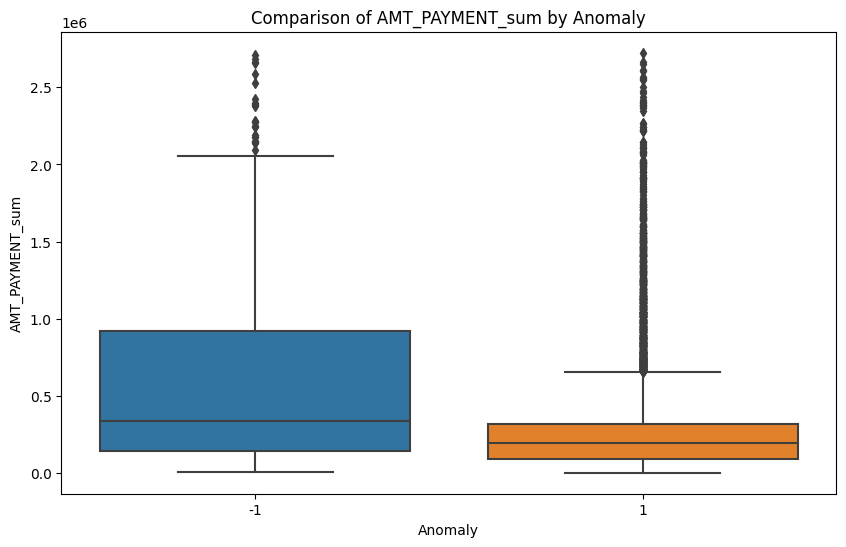

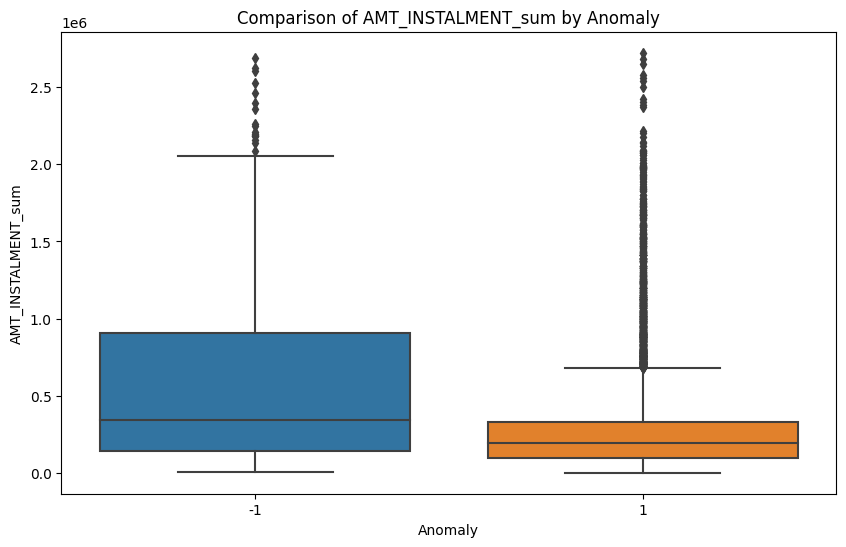

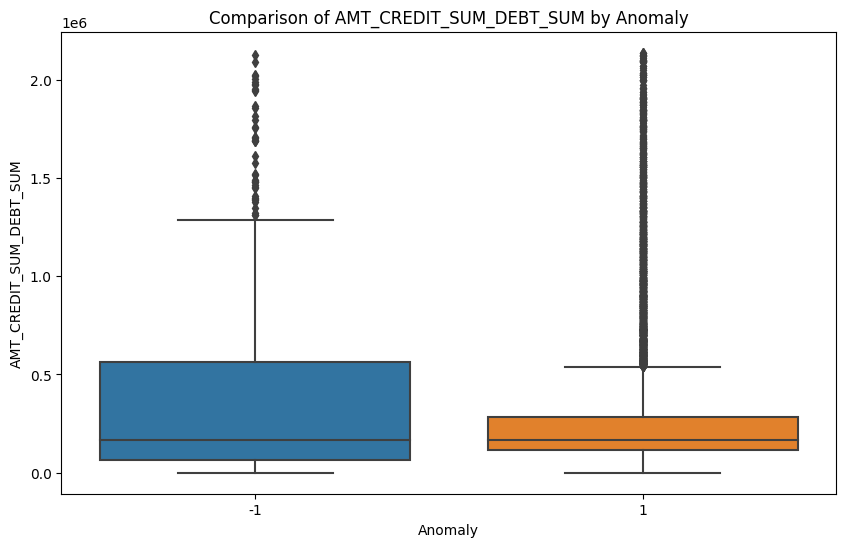

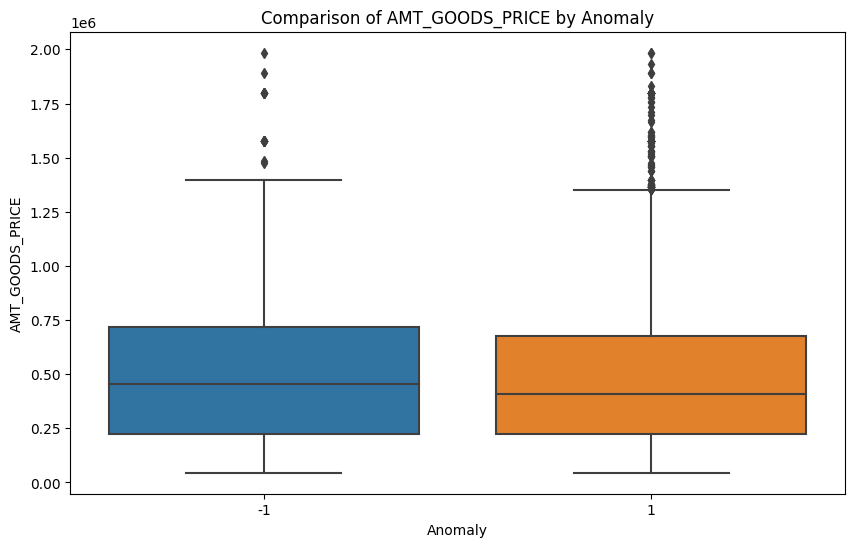

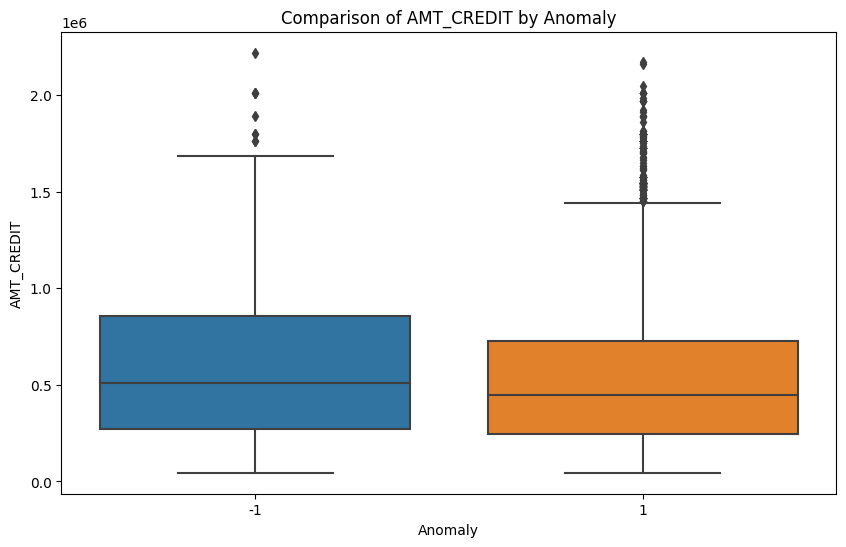

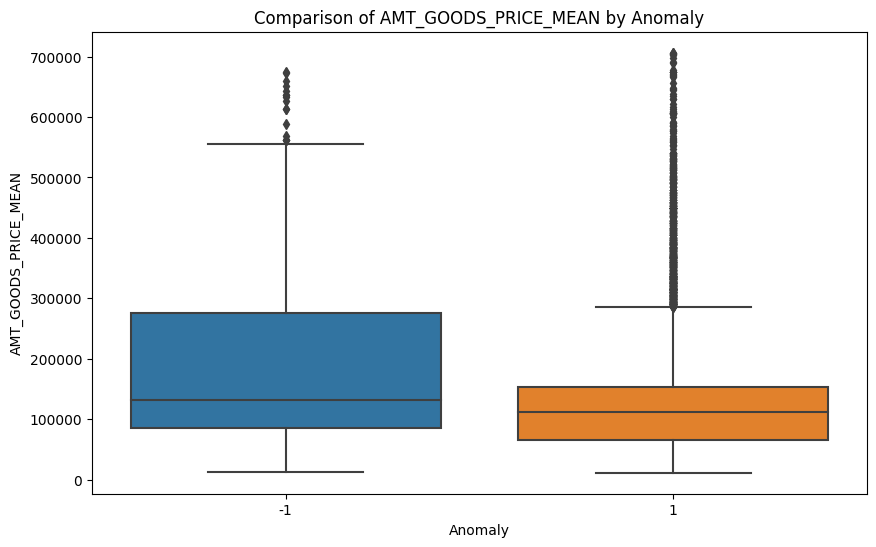

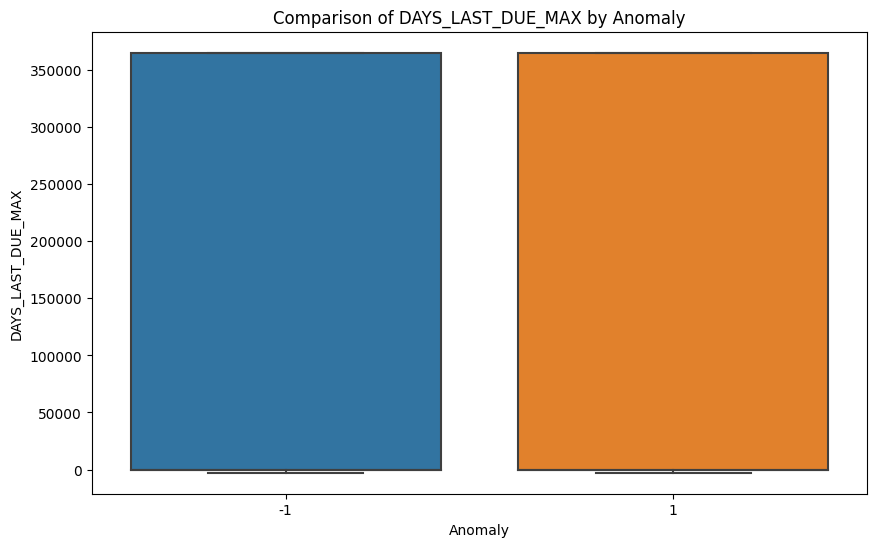

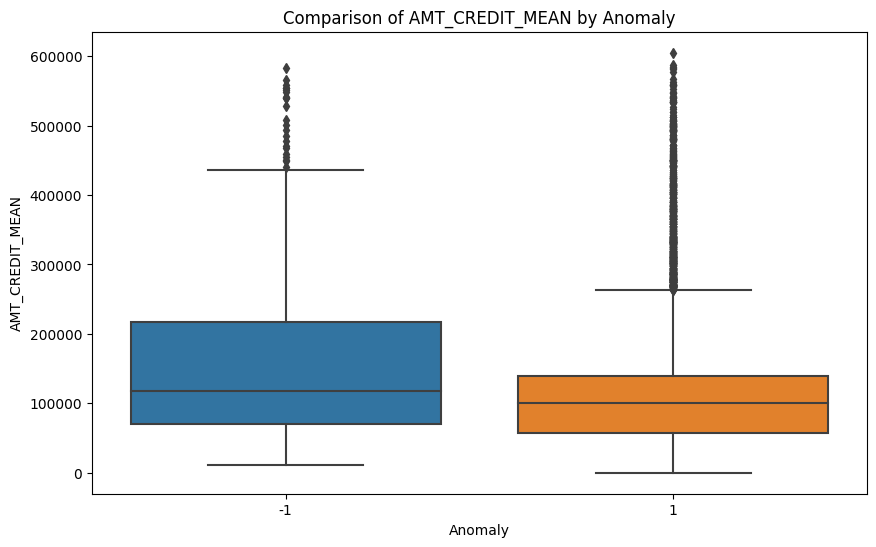

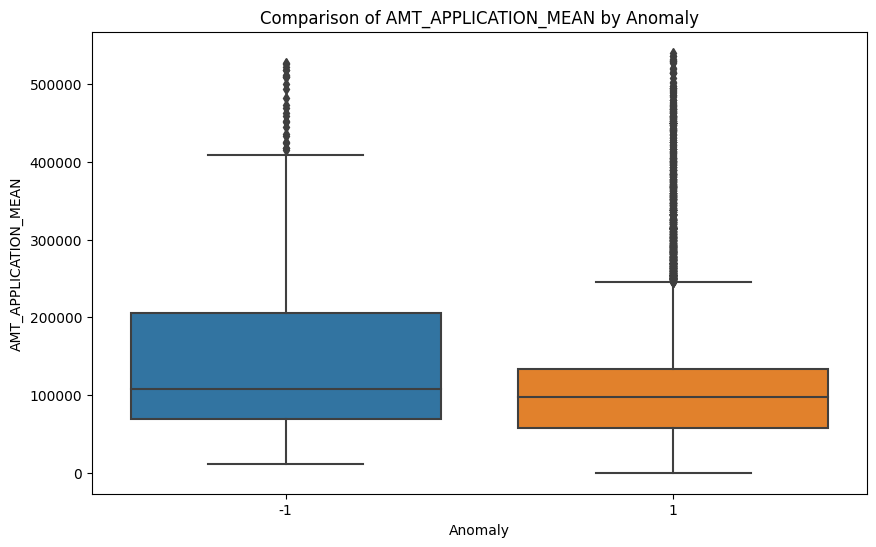

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
top_diff_columns = summary.sort_values('Difference', ascending=False).head(10).index

for col in top_diff_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Anomaly', y=col, data=final_data)
    plt.title(f'Comparison of {col} by Anomaly')
    plt.show()

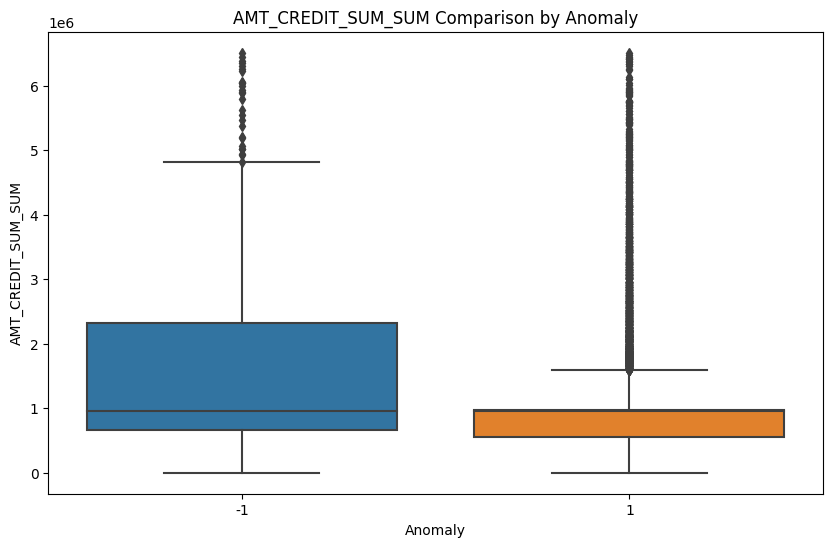

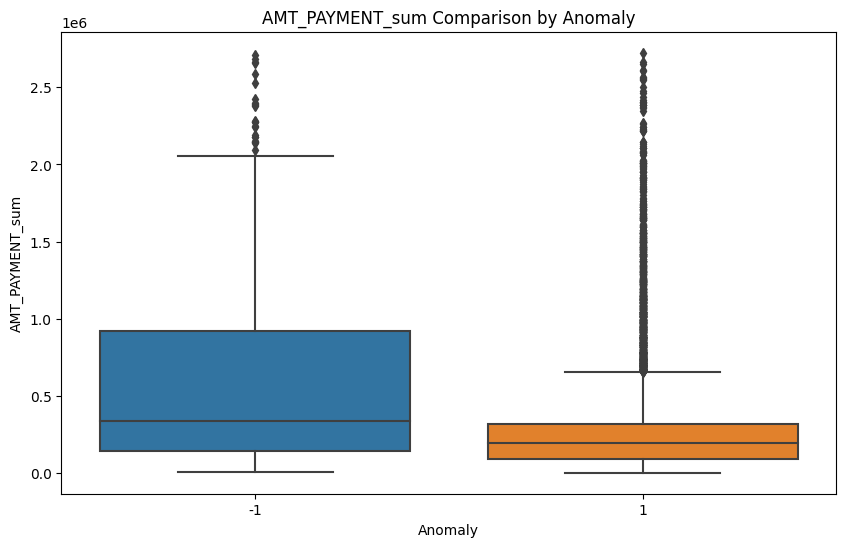

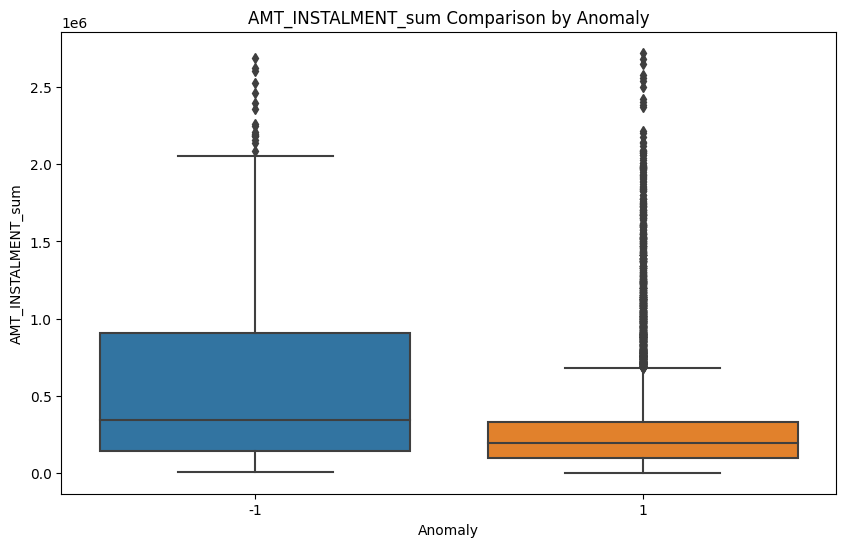

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = ['AMT_CREDIT_SUM_SUM', 'AMT_PAYMENT_sum', 'AMT_INSTALMENT_sum']

for col in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Anomaly', y=col, data=final_data)
    plt.title(f'{col} Comparison by Anomaly')
    plt.show()

In [228]:
summary.to_csv('anomalies_vs_normal_analysis.csv', index=True)
print("Analysis saved to 'anomalies_vs_normal_analysis.csv'.")

Analysis saved to 'anomalies_vs_normal_analysis.csv'.


In [229]:
features = final_data.drop(columns=['Anomaly'])

target = final_data['Anomaly']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (8234, 138)
Testing set shape: (2059, 138)


In [231]:
y_train = y_train.replace({-1: 0})
y_test = y_test.replace({-1: 0})

In [233]:
print("Distribution in y_train:")
print(y_train.value_counts())
print("\nDistribution in y_test:")
print(y_test.value_counts())

Distribution in y_train:
Anomaly
1    7822
0     412
Name: count, dtype: int64

Distribution in y_test:
Anomaly
1    1956
0     103
Name: count, dtype: int64


In [234]:
from xgboost import XGBClassifier
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       103
           1       0.99      0.98      0.98      1956

    accuracy                           0.97      2059
   macro avg       0.83      0.88      0.86      2059
weighted avg       0.97      0.97      0.97      2059

ROC-AUC Score: 0.9844392161534338


# Logistic Regression

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
y_pred_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logistic))

print("Logistic Regression - ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_logistic))


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.06      0.10       103
           1       0.95      1.00      0.97      1956

    accuracy                           0.95      2059
   macro avg       0.71      0.53      0.54      2059
weighted avg       0.93      0.95      0.93      2059

Logistic Regression - ROC-AUC Score: 0.7558321917128278


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [237]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest - ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       103
           1       0.98      0.99      0.98      1956

    accuracy                           0.97      2059
   macro avg       0.86      0.76      0.80      2059
weighted avg       0.96      0.97      0.96      2059

Random Forest - ROC-AUC Score: 0.9787832310838446


# Support Vector Machine (SVM)

In [238]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]

print("SVM - Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM - ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_svm))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.01      0.02       103
           1       0.95      1.00      0.97      1956

    accuracy                           0.95      2059
   macro avg       0.60      0.50      0.50      2059
weighted avg       0.92      0.95      0.93      2059

SVM - ROC-AUC Score: 0.5304614132269143


# Compare

In [243]:
import pandas as pd
results = []

results.append({
    "Model": "XGBoost",
    "Precision (0)": classification_report(y_test, y_pred, output_dict=True)['0']['precision'],
    "Recall (0)": classification_report(y_test, y_pred, output_dict=True)['0']['recall'],
    "F1-Score (0)": classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob)
})

results.append({
    "Model": "Random Forest",
    "Precision (0)": classification_report(y_test, y_pred_rf, output_dict=True)['0']['precision'],
    "Recall (0)": classification_report(y_test, y_pred_rf, output_dict=True)['0']['recall'],
    "F1-Score (0)": classification_report(y_test, y_pred_rf, output_dict=True)['0']['f1-score'],
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_rf)
})

results.append({
    "Model": "Logistic Regression",
    "Precision (0)": classification_report(y_test, y_pred_logistic, output_dict=True)['0']['precision'],
    "Recall (0)": classification_report(y_test, y_pred_logistic, output_dict=True)['0']['recall'],
    "F1-Score (0)": classification_report(y_test, y_pred_logistic, output_dict=True)['0']['f1-score'],
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_logistic)
})

results.append({
    "Model": "SVM",
    "Precision (0)": classification_report(y_test, y_pred_svm, output_dict=True)['0']['precision'],
    "Recall (0)": classification_report(y_test, y_pred_svm, output_dict=True)['0']['recall'],
    "F1-Score (0)": classification_report(y_test, y_pred_svm, output_dict=True)['0']['f1-score'],
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_svm)
})

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Precision (0)  Recall (0)  F1-Score (0)   ROC-AUC
0              XGBoost       0.680672    0.786408      0.729730  0.984439
1        Random Forest       0.743243    0.533981      0.621469  0.978783
2  Logistic Regression       0.461538    0.058252      0.103448  0.755832
3                  SVM       0.250000    0.009709      0.018692  0.530461


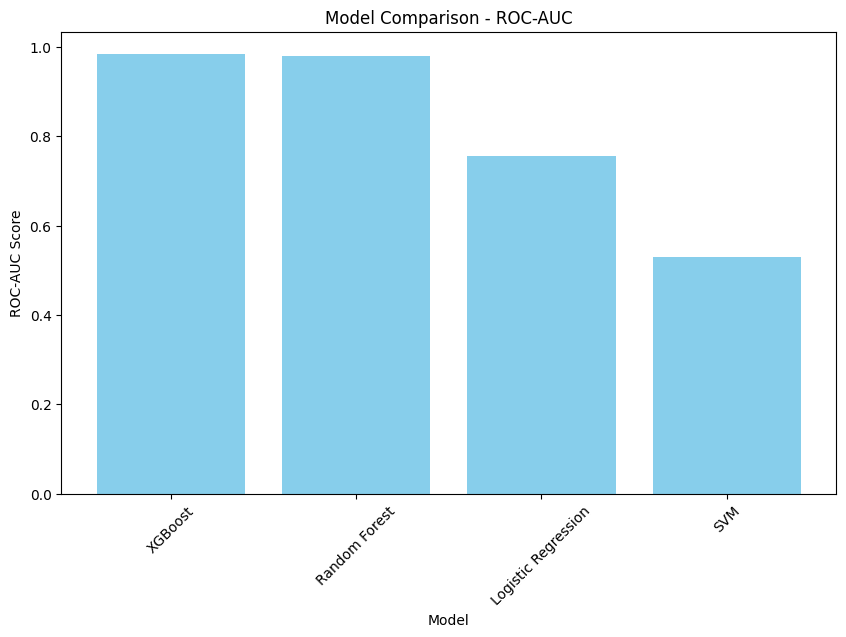

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['ROC-AUC'], color='skyblue')
plt.title('Model Comparison - ROC-AUC')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

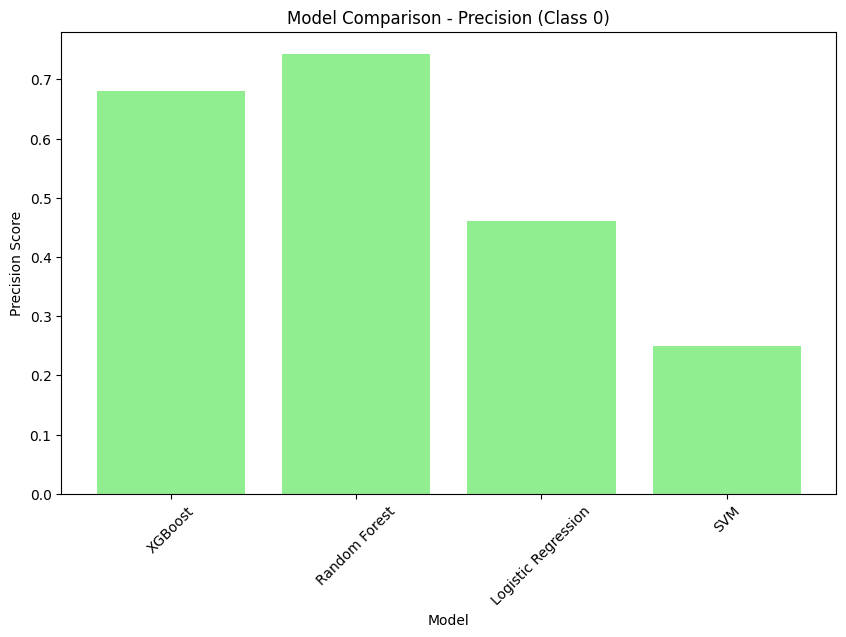

In [245]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Precision (0)'], color='lightgreen')
plt.title('Model Comparison - Precision (Class 0)')
plt.ylabel('Precision Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

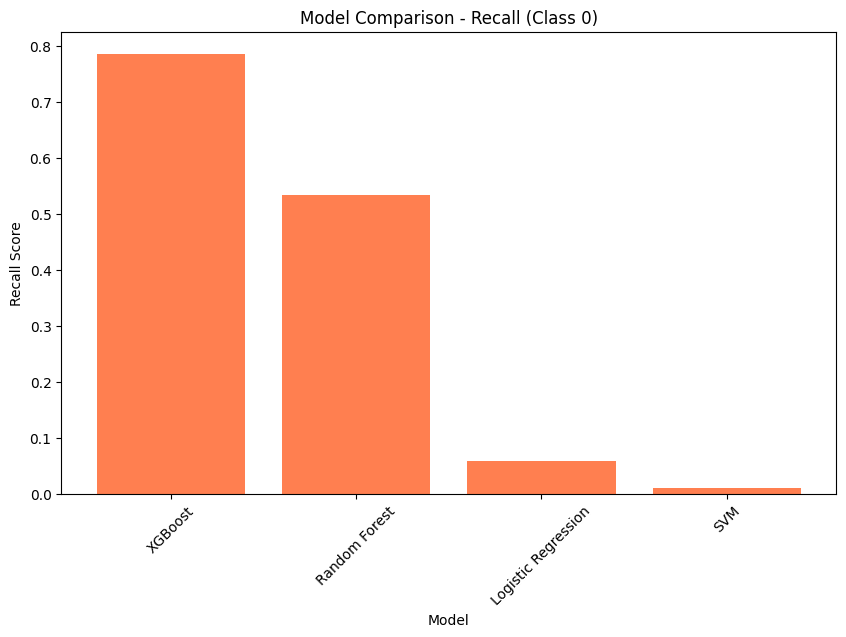

In [246]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Recall (0)'], color='coral')
plt.title('Model Comparison - Recall (Class 0)')
plt.ylabel('Recall Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

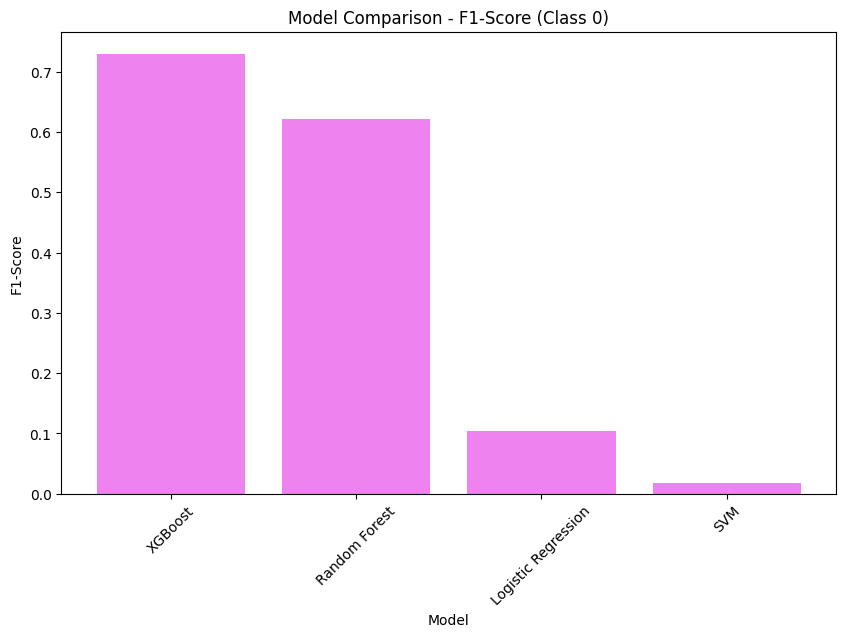

In [247]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['F1-Score (0)'], color='violet')
plt.title('Model Comparison - F1-Score (Class 0)')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x800 with 0 Axes>

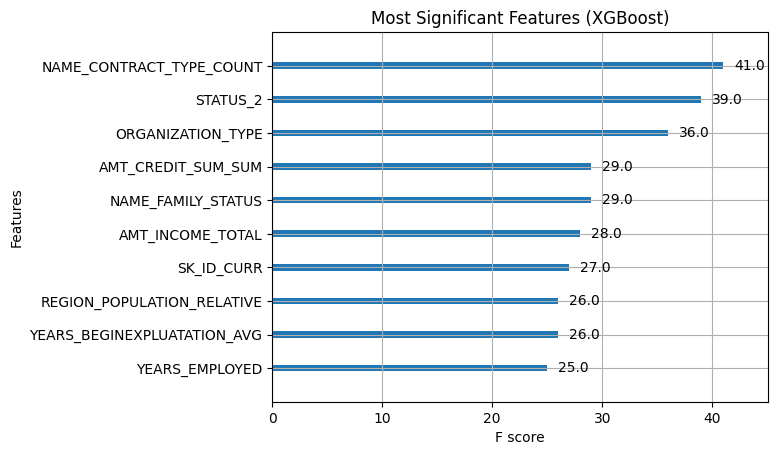

In [248]:
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Most Significant Features (XGBoost)')
plt.show()

In [249]:

xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 Features by XGBoost:")
print(xgb_feature_importance.head(10))

Top 10 Features by XGBoost:
                        Feature  Importance
12               ENTRANCES_MODE    0.470680
132    NAME_CONTRACT_TYPE_COUNT    0.046820
4                ELEVATORS_MODE    0.036270
72                     STATUS_2    0.029329
8                APARTMENTS_AVG    0.026990
96           AMT_INSTALMENT_sum    0.018138
19                FLOORSMAX_AVG    0.017389
17               FLOORSMAX_MODE    0.015974
64           AMT_CREDIT_SUM_SUM    0.015119
26   AMT_REQ_CREDIT_BUREAU_YEAR    0.012606


Top 10 Features by Random Forest:
            Feature  Importance
19    FLOORSMAX_AVG    0.034839
5     ELEVATORS_AVG    0.029827
4    ELEVATORS_MODE    0.028416
97  AMT_PAYMENT_sum    0.026471
15  LIVINGAREA_MODE    0.025484
23   TOTALAREA_MODE    0.025112
14   LIVINGAREA_AVG    0.024789
18   FLOORSMAX_MEDI    0.024545
10  APARTMENTS_MEDI    0.024205
8    APARTMENTS_AVG    0.023615


<Figure size 1000x600 with 0 Axes>

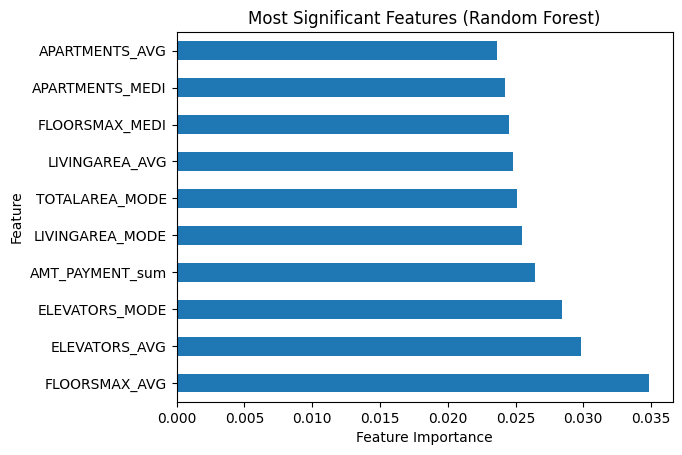

In [250]:
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 Features by Random Forest:")
print(rf_feature_importance.head(10))

plt.figure(figsize=(10, 6))
rf_feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Most Significant Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


Top 10 Features by Logistic Regression:
                    Feature  Coefficient
94      DAYS_INSTALMENT_min     0.000058
95   DAYS_ENTRY_PAYMENT_min     0.000058
68   DAYS_CREDIT_UPDATE_MIN     0.000039
120      AMT_ANNUITY_MEAN_y     0.000029
129      DAYS_FIRST_DUE_MIN     0.000026
126       DAYS_DECISION_MIN     0.000017
33   DAYS_LAST_PHONE_CHANGE     0.000014
31              AMT_ANNUITY     0.000012
119    AMT_APPLICATION_MEAN     0.000007
128  DAYS_FIRST_DRAWING_MIN     0.000006


<Figure size 1000x600 with 0 Axes>

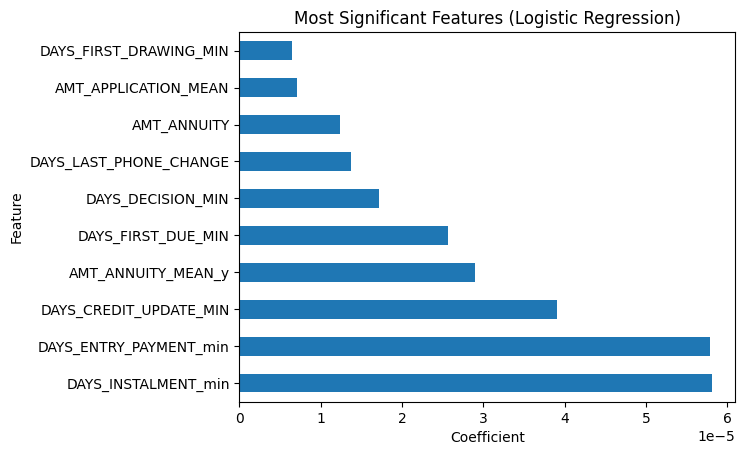

In [251]:
lr_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Top 10 Features by Logistic Regression:")
print(lr_feature_importance.head(10))

plt.figure(figsize=(10, 6))
lr_feature_importance.head(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False)
plt.title('Most Significant Features (Logistic Regression)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()